# Data collection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import ee, os, time, json, pandas as pd
from google.colab import drive

try:
    ee.Initialize(project='ee-faiz2009cu')
except:
    ee.Authenticate()
    ee.Initialize(project='ee-faiz2009cu')

In [ ]:
#  =====================================================
#  ENHANCED GEE PIPELINE FOR REMOTE SENSING FOCUS
#  Version: Agricultural-Only (No SDOH/Weather)
# =====================================================

import ee, os, time, json, pandas as pd
from google.colab import drive

try:
    ee.Initialize(project='ee-faiz2009cu')
except:
    ee.Authenticate()
    ee.Initialize(project='ee-faiz2009cu')

# ------------------- CONFIG -------------------
TEST_MODE = False
SCALE = 250
FOLDER = 'Agricultural_RS_LE_2025'
BASE = f'/content/drive/MyDrive/{FOLDER}'
os.makedirs(BASE, exist_ok=True)

if TEST_MODE:
    YEARS = [2020, 2021, 2022]
    STATES = ['06']  # California
else:
    YEARS = range(2000, 2025)
    STATES = None

# ------------------- EXPANDED BAND CATALOG -------------------
BANDS = {
    # Your existing sensors
    'landsat89': ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'],
    's2': ['B2', 'B3', 'B4', 'B8', 'B11', 'B12'],
    's1': ['VV', 'VH'],
    'cropland_usda': ['cropland'],
    'dynamic_world': ['water', 'trees', 'grass', 'flooded_vegetation',
                      'crops', 'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'],
    'water_jrc': ['waterClass'],
    'dem': ['DEM'],

    # NEW: Additional products
    'modis_ndvi': ['NDVI', 'EVI'],
    'modis_lst': ['LST_Day_1km', 'LST_Night_1km'],
    'soil_texture': ['b0'],  # Surface soil texture
    'nightlights': ['avg_rad'],  # Proxy for economic activity (optional)
}

# ------------------- EXPANDED ASSET MAP -------------------
ASSET_MAP = {
    # Existing
    'landsat89':     {'enabled': False, 'id': 'LANDSAT/LC08/C02/T1_L2', 'temporal': 'median', 'add_ndvi': True},
    's2':            {'enabled': False, 'id': 'COPERNICUS/S2_SR_HARMONIZED', 'temporal': 'median', 'add_ndvi': True},
    's1':            {'enabled': False, 'id': 'COPERNICUS/S1_GRD', 'temporal': 'median'},
    'cropland_usda': {'enabled': True, 'id': 'USDA/NASS/CDL', 'temporal': 'mode', 'categorical': True},
    'dynamic_world': {'enabled': True, 'id': 'GOOGLE/DYNAMICWORLD/V1', 'temporal': 'mode', 'categorical': True},
    'water_jrc':     {'enabled': True, 'id': 'JRC/GSW1_4/YearlyHistory', 'temporal': 'mode', 'categorical': True},
    'dem':           {'enabled': True, 'id': 'COPERNICUS/DEM/GLO30', 'static': True},

    # NEW: MODIS for longer time series
    'modis_ndvi': {
        'enabled': True,
        'id': 'MODIS/061/MOD13A1',
        'temporal': 'median',
        'scale_override': 500  # MODIS native resolution
    },

    'modis_lst': {
        'enabled': True,
        'id': 'MODIS/061/MOD11A2',
        'temporal': 'mean',
        'scale_override': 1000,
        'preprocessing': lambda img: img.multiply(0.02).subtract(273.15)  # Kelvin to Celsius
    },

    # NEW: Soil properties (static)
    'soil_texture': {
        'enabled': True,
        'id': 'OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02',
        'static': True
    },

    # OPTIONAL: VIIRS Nightlights (economic activity proxy)
    'nightlights': {
        'enabled': False,  # Set True if you want urban-rural gradient
        'id': 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
        'temporal': 'mean'
    }
}

# =====================================================
#               HELPER FUNCTIONS (ADDED FIXES)
# =====================================================

def mask_landsat(image):
    """
    Cloud masking for Landsat 8/9 using QA_PIXEL band.
    Scales optical bands to 0-1 surface reflectance.
    """
    qa = image.select('QA_PIXEL')
    # Mask Dilated Cloud, Cirrus, Cloud, and Cloud Shadow
    mask = qa.bitwiseAnd(1 << 1).eq(0) \
        .And(qa.bitwiseAnd(1 << 2).eq(0)) \
        .And(qa.bitwiseAnd(1 << 3).eq(0)) \
        .And(qa.bitwiseAnd(1 << 4).eq(0))

    # Apply scaling factors for Landsat Collection 2
    return image.updateMask(mask) \
        .multiply(0.0000275).add(-0.2) \
        .copyProperties(image, image.propertyNames())

def mask_s2(image):
    """
    Cloud masking for Sentinel-2 using QA60 band.
    Scales to 0-1 surface reflectance.
    """
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Scale to 0-1 (S2 data is typically 0-10000)
    return image.updateMask(mask).divide(10000) \
                .copyProperties(image, image.propertyNames())

def fix_cdl(image):
    """Ensure CDL has the correct band name."""
    return image.select(['cropland'])

# =====================================================

# ------------------- TEXTURE FEATURES (NEW) -------------------
def add_texture_features(img):
    """
    Compute GLCM texture metrics for Sentinel-1.
    Useful for crop structure characterization.
    """
    glcm = img.select(['VV']).glcmTexture(size=3)

    texture_bands = [
        'VV_asm',   # Angular Second Moment (uniformity)
        'VV_contrast',
        'VV_corr',  # Correlation
        'VV_ent'    # Entropy (randomness)
    ]

    return img.addBands(glcm.select(texture_bands))

# ------------------- SPECTRAL INDICES (EXPANDED) -------------------
def add_spectral_indices(img, sensor='landsat'):
    """
    Add comprehensive spectral indices for agricultural monitoring.
    """
    if sensor == 'landsat':
        nir, red, green, swir1 = 'SR_B5', 'SR_B4', 'SR_B3', 'SR_B6'
    else:  # sentinel-2
        nir, red, green, swir1 = 'B8', 'B4', 'B3', 'B11'

    # Vegetation indices
    ndvi = img.normalizedDifference([nir, red]).rename('NDVI')
    evi = img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {'NIR': img.select(nir), 'RED': img.select(red), 'BLUE': img.select('SR_B2' if sensor=='landsat' else 'B2')}
    ).rename('EVI')

    savi = img.expression(
        '((NIR - RED) / (NIR + RED + 0.5)) * 1.5',
        {'NIR': img.select(nir), 'RED': img.select(red)}
    ).rename('SAVI')

    # Moisture/water indices
    ndwi = img.normalizedDifference([green, nir]).rename('NDWI')
    ndmi = img.normalizedDifference([nir, swir1]).rename('NDMI')  # Normalized Difference Moisture Index

    # Soil/bare ground
    bsi = img.expression(
        '((SWIR + RED) - (NIR + BLUE)) / ((SWIR + RED) + (NIR + BLUE))',
        {
            'SWIR': img.select(swir1),
            'RED': img.select(red),
            'NIR': img.select(nir),
            'BLUE': img.select('SR_B2' if sensor=='landsat' else 'B2')
        }
    ).rename('BSI')

    return img.addBands([ndvi, evi, savi, ndwi, ndmi, bsi])

# ------------------- UPDATED PIPELINE -------------------
class AgricultureRSPipeline:
    def __init__(self):
        drive.mount('/content/drive')
        self.fc = ee.FeatureCollection('TIGER/2018/Counties')\
                  .filter(ee.Filter.inList('STATEFP',
                      ['02','15','60','66','69','72','78']).Not())
        self.states = STATES or self.fc.aggregate_array('STATEFP').distinct().getInfo()

    def export(self, table, name, year=None):
        """Export to Drive with error handling."""
        suffix = f"_{year}" if year else ""
        task_name = f"{name}{suffix}"

        task = ee.batch.Export.table.toDrive(
            collection=table,
            folder=FOLDER,
            description=task_name,
            fileNamePrefix=task_name,
            fileFormat='CSV'
        )

        try:
            task.start()
            print(f"→ Task submitted: {task_name}")
            return task
        except ee.EEException as e:
            print(f"!! FAILED: {task_name}. Error: {e}")
            return None

    def run(self):
        """Main execution loop."""
        active_task_count = 0
        QUEUE_LIMIT = 2900

        for asset, cfg in ASSET_MAP.items():
            if not cfg['enabled']:
                continue

            print(f"\n=== {asset.upper()} ===")
            bands = BANDS[asset]
            is_static = cfg.get('static', False)
            scale = cfg.get('scale_override', SCALE)

            for year in (YEARS if not is_static else [None]):
                for state in self.states:
                    # Check existing files
                    suffix = f"_{year}" if year else ""
                    file_path = os.path.join(BASE, f"{asset}_{state}{suffix}.csv")
                    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                        print(f"  -> File exists: {asset}_{state}{suffix}.csv. Skipping.")
                        continue

                    # Queue management
                    while active_task_count >= QUEUE_LIMIT:
                        print(f"  ...Queue full. Waiting 5 min...")
                        time.sleep(300)
                        active_tasks = [t for t in ee.batch.Task.list() if t.state in ['RUNNING', 'READY']]
                        active_task_count = len(active_tasks)

                    # Build image
                    counties = self.fc.filter(ee.Filter.eq('STATEFP', state))
                    geom = counties.geometry().bounds()

                    try:
                        if is_static:
                            img = ee.Image(cfg['id']).select(bands)
                        else:
                            start, end = f'{year}-01-01', f'{year}-12-31'
                            col = ee.ImageCollection(cfg['id']).filterDate(start, end).filterBounds(geom)

                            # Sensor-specific preprocessing
                            if asset == 'landsat89':
                                if year >= 2022:
                                    l9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterDate(start, end).filterBounds(geom)
                                    col = col.merge(l9)
                                # --- ERROR FIXED: mask_landsat was missing ---
                                col = col.map(mask_landsat)
                                col = col.map(lambda i: add_spectral_indices(i, 'landsat'))

                            elif asset == 's2':
                                # --- ERROR FIXED: mask_s2 was missing ---
                                col = col.map(mask_s2)
                                col = col.map(lambda i: add_spectral_indices(i, 's2'))

                            elif asset == 's1':
                                col = col.map(add_texture_features)

                            elif asset == 'modis_lst' and 'preprocessing' in cfg:
                                col = col.map(cfg['preprocessing'])

                            elif asset == 'cropland_usda':
                                # --- ERROR FIXED: fix_cdl was missing ---
                                col = col.map(fix_cdl)

                            # Temporal reduction
                            if cfg['temporal'] == 'median':
                                img = col.median()
                            elif cfg['temporal'] == 'mean':
                                img = col.mean()
                            else:
                                img = col.mode()

                            # Select final bands
                            all_bands = bands + (['NDVI', 'EVI', 'SAVI', 'NDWI', 'NDMI', 'BSI'] if cfg.get('add_ndvi') else [])
                            if asset == 's1':
                                all_bands += ['VV_asm', 'VV_contrast', 'VV_corr', 'VV_ent']

                            img = img.select([b for b in all_bands if b in img.bandNames().getInfo()])

                        # Reducers
                        red = ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True)
                        if cfg.get('categorical'):
                            red = red.combine(ee.Reducer.frequencyHistogram(), '', True)
                        else:
                            red = red.combine(ee.Reducer.percentile([10, 25, 50, 75, 90]), '', True)

                        # Spatial aggregation
                        stats = img.reduceRegions(
                            collection=counties,
                            reducer=red,
                            scale=scale,
                            tileScale=4
                        )

                        # Tag and export
                        def tag(f):
                            props = {'STATEFP': f.get('STATEFP'), 'COUNTYFP': f.get('COUNTYFP'), 'NAME': f.get('NAME')}
                            if year: props['year'] = year
                            return ee.Feature(None, props).copyProperties(f, f.propertyNames())

                        stats = stats.map(tag)
                        new_task = self.export(stats, f"{asset}_{state}", year)
                        if new_task:
                            active_task_count += 1

                    except Exception as e:
                        print(f"!! ERROR: {asset}_{state}_{year}: {e}")

        print(f"\nAll tasks queued! → Drive → {FOLDER}")

# RUN
pipeline = AgricultureRSPipeline()
pipeline.run()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== CROPLAND_USDA ===
→ Task submitted: cropland_usda_29_2000
→ Task submitted: cropland_usda_32_2000
→ Task submitted: cropland_usda_51_2000
→ Task submitted: cropland_usda_01_2000
→ Task submitted: cropland_usda_04_2000
→ Task submitted: cropland_usda_05_2000
→ Task submitted: cropland_usda_06_2000
→ Task submitted: cropland_usda_08_2000
→ Task submitted: cropland_usda_12_2000
→ Task submitted: cropland_usda_13_2000
→ Task submitted: cropland_usda_16_2000
→ Task submitted: cropland_usda_17_2000
→ Task submitted: cropland_usda_18_2000
→ Task submitted: cropland_usda_19_2000
→ Task submitted: cropland_usda_20_2000
→ Task submitted: cropland_usda_21_2000
→ Task submitted: cropland_usda_22_2000
→ Task submitted: cropland_usda_23_2000
→ Task submitted: cropland_usda_24_2000
→ Task submitted: cropland_usda_26_2000
→ Task submitted: cropland_usda_27_2000
→ Task s

!! FAILED: cropland_usda_23_2023. Error: A different Operation was already started with the given request_id.
→ Task submitted: cropland_usda_24_2023
→ Task submitted: cropland_usda_26_2023
→ Task submitted: cropland_usda_27_2023
→ Task submitted: cropland_usda_28_2023
→ Task submitted: cropland_usda_30_2023
→ Task submitted: cropland_usda_31_2023
→ Task submitted: cropland_usda_33_2023
→ Task submitted: cropland_usda_35_2023
→ Task submitted: cropland_usda_36_2023
→ Task submitted: cropland_usda_37_2023
→ Task submitted: cropland_usda_38_2023
→ Task submitted: cropland_usda_39_2023
→ Task submitted: cropland_usda_40_2023
→ Task submitted: cropland_usda_41_2023
→ Task submitted: cropland_usda_42_2023
→ Task submitted: cropland_usda_45_2023
→ Task submitted: cropland_usda_46_2023
→ Task submitted: cropland_usda_47_2023
→ Task submitted: cropland_usda_48_2023
→ Task submitted: cropland_usda_49_2023
→ Task submitted: cropland_usda_50_2023
→ Task submitted: cropland_usda_53_2023
→ Task sub

→ Task submitted: dynamic_world_49_2008
→ Task submitted: dynamic_world_50_2008
→ Task submitted: dynamic_world_53_2008
→ Task submitted: dynamic_world_54_2008
→ Task submitted: dynamic_world_55_2008
→ Task submitted: dynamic_world_56_2008
→ Task submitted: dynamic_world_25_2008
→ Task submitted: dynamic_world_34_2008
→ Task submitted: dynamic_world_10_2008
→ Task submitted: dynamic_world_11_2008
→ Task submitted: dynamic_world_09_2008
→ Task submitted: dynamic_world_44_2008
→ Task submitted: dynamic_world_29_2009
→ Task submitted: dynamic_world_32_2009
→ Task submitted: dynamic_world_51_2009
→ Task submitted: dynamic_world_01_2009
→ Task submitted: dynamic_world_04_2009
→ Task submitted: dynamic_world_05_2009
→ Task submitted: dynamic_world_06_2009
→ Task submitted: dynamic_world_08_2009
→ Task submitted: dynamic_world_12_2009
→ Task submitted: dynamic_world_13_2009
→ Task submitted: dynamic_world_16_2009
→ Task submitted: dynamic_world_17_2009
→ Task submitted: dynamic_world_18_2009


→ Task submitted: modis_lst_11_2016
→ Task submitted: modis_lst_09_2016
→ Task submitted: modis_lst_44_2016
→ Task submitted: modis_lst_29_2017
→ Task submitted: modis_lst_32_2017
→ Task submitted: modis_lst_51_2017
→ Task submitted: modis_lst_01_2017
→ Task submitted: modis_lst_04_2017
→ Task submitted: modis_lst_05_2017
→ Task submitted: modis_lst_06_2017
→ Task submitted: modis_lst_08_2017
→ Task submitted: modis_lst_12_2017
→ Task submitted: modis_lst_13_2017
→ Task submitted: modis_lst_16_2017
→ Task submitted: modis_lst_17_2017
→ Task submitted: modis_lst_18_2017
→ Task submitted: modis_lst_19_2017
  ...Queue full. Waiting 5 min...
→ Task submitted: modis_lst_20_2017
→ Task submitted: modis_lst_21_2017
→ Task submitted: modis_lst_22_2017
→ Task submitted: modis_lst_23_2017
→ Task submitted: modis_lst_24_2017
→ Task submitted: modis_lst_26_2017
→ Task submitted: modis_lst_27_2017
→ Task submitted: modis_lst_28_2017
→ Task submitted: modis_lst_30_2017
→ Task submitted: modis_lst_31

Run the code for the remaining dataset now then run merge code

In [ ]:
#  =====================================================
#  ENHANCED GEE PIPELINE FOR REMOTE SENSING FOCUS
#  Version: Agricultural-Only (No SDOH/Weather)
# =====================================================

import ee, os, time, json, pandas as pd
from google.colab import drive

try:
    ee.Initialize(project='ee-faiz2009cu')
except:
    ee.Authenticate()
    ee.Initialize(project='ee-faiz2009cu')

# ------------------- CONFIG -------------------
TEST_MODE = False
SCALE = 250
FOLDER = 'Agricultural_RS_LE_2025'
BASE = f'/content/drive/MyDrive/{FOLDER}'
os.makedirs(BASE, exist_ok=True)

if TEST_MODE:
    YEARS = [2020, 2021, 2022]
    STATES = ['06']  # California
else:
    YEARS = range(2000, 2025)
    STATES = None

# ------------------- EXPANDED BAND CATALOG -------------------
BANDS = {
    # Your existing sensors
    'landsat89': ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'],
    's2': ['B2', 'B3', 'B4', 'B8', 'B11', 'B12'],
    's1': ['VV', 'VH'],
    'cropland_usda': ['cropland'],
    'dynamic_world': ['water', 'trees', 'grass', 'flooded_vegetation',
                      'crops', 'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'],
    'water_jrc': ['waterClass'],
    'dem': ['DEM'],

    # NEW: Additional products
    'modis_ndvi': ['NDVI', 'EVI'],
    'modis_lst': ['LST_Day_1km', 'LST_Night_1km'],
    'soil_texture': ['b0'],  # Surface soil texture
    'nightlights': ['avg_rad'],  # Proxy for economic activity (optional)
}

# ------------------- EXPANDED ASSET MAP -------------------
ASSET_MAP = {
    # Existing
    'landsat89':     {'enabled': True, 'id': 'LANDSAT/LC08/C02/T1_L2', 'temporal': 'median', 'add_ndvi': True},
    's2':            {'enabled': True, 'id': 'COPERNICUS/S2_SR_HARMONIZED', 'temporal': 'median', 'add_ndvi': True},
    's1':            {'enabled': True, 'id': 'COPERNICUS/S1_GRD', 'temporal': 'median'},
    'cropland_usda': {'enabled': False, 'id': 'USDA/NASS/CDL', 'temporal': 'mode', 'categorical': True},
    'dynamic_world': {'enabled': False, 'id': 'GOOGLE/DYNAMICWORLD/V1', 'temporal': 'mode', 'categorical': True},
    'water_jrc':     {'enabled': False, 'id': 'JRC/GSW1_4/YearlyHistory', 'temporal': 'mode', 'categorical': True},
    'dem':           {'enabled': False, 'id': 'COPERNICUS/DEM/GLO30', 'static': True},

    # NEW: MODIS for longer time series
    'modis_ndvi': {
        'enabled': True,
        'id': 'MODIS/061/MOD13A1',
        'temporal': 'median',
        'scale_override': 500  # MODIS native resolution
    },

    'modis_lst': {
        'enabled': True,
        'id': 'MODIS/061/MOD11A2',
        'temporal': 'mean',
        'scale_override': 1000,
        'preprocessing': lambda img: img.multiply(0.02).subtract(273.15)  # Kelvin to Celsius
    },

    # NEW: Soil properties (static)
    'soil_texture': {
        'enabled': True,
        'id': 'OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02',
        'static': True
    },

    # OPTIONAL: VIIRS Nightlights (economic activity proxy)
    'nightlights': {
        'enabled': False,  # Set True if you want urban-rural gradient
        'id': 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
        'temporal': 'mean'
    }
}

# =====================================================
#               HELPER FUNCTIONS (ADDED FIXES)
# =====================================================

def mask_landsat(image):
    """
    Cloud masking for Landsat 8/9 using QA_PIXEL band.
    Scales optical bands to 0-1 surface reflectance.
    """
    qa = image.select('QA_PIXEL')
    # Mask Dilated Cloud, Cirrus, Cloud, and Cloud Shadow
    mask = qa.bitwiseAnd(1 << 1).eq(0) \
        .And(qa.bitwiseAnd(1 << 2).eq(0)) \
        .And(qa.bitwiseAnd(1 << 3).eq(0)) \
        .And(qa.bitwiseAnd(1 << 4).eq(0))

    # Apply scaling factors for Landsat Collection 2
    return image.updateMask(mask) \
        .multiply(0.0000275).add(-0.2) \
        .copyProperties(image, image.propertyNames())

def mask_s2(image):
    """
    Cloud masking for Sentinel-2 using QA60 band.
    Scales to 0-1 surface reflectance.
    """
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Scale to 0-1 (S2 data is typically 0-10000)
    return image.updateMask(mask).divide(10000) \
                .copyProperties(image, image.propertyNames())

def fix_cdl(image):
    """Ensure CDL has the correct band name."""
    return image.select(['cropland'])

# =====================================================

# ------------------- TEXTURE FEATURES (NEW) -------------------
def add_texture_features(img):
    """
    Compute GLCM texture metrics for Sentinel-1.
    Useful for crop structure characterization.
    """
    glcm = img.select(['VV']).glcmTexture(size=3)

    texture_bands = [
        'VV_asm',   # Angular Second Moment (uniformity)
        'VV_contrast',
        'VV_corr',  # Correlation
        'VV_ent'    # Entropy (randomness)
    ]

    return img.addBands(glcm.select(texture_bands))

# ------------------- SPECTRAL INDICES (EXPANDED) -------------------
def add_spectral_indices(img, sensor='landsat'):
    """
    Add comprehensive spectral indices for agricultural monitoring.
    """
    if sensor == 'landsat':
        nir, red, green, swir1 = 'SR_B5', 'SR_B4', 'SR_B3', 'SR_B6'
    else:  # sentinel-2
        nir, red, green, swir1 = 'B8', 'B4', 'B3', 'B11'

    # Vegetation indices
    ndvi = img.normalizedDifference([nir, red]).rename('NDVI')
    evi = img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {'NIR': img.select(nir), 'RED': img.select(red), 'BLUE': img.select('SR_B2' if sensor=='landsat' else 'B2')}
    ).rename('EVI')

    savi = img.expression(
        '((NIR - RED) / (NIR + RED + 0.5)) * 1.5',
        {'NIR': img.select(nir), 'RED': img.select(red)}
    ).rename('SAVI')

    # Moisture/water indices
    ndwi = img.normalizedDifference([green, nir]).rename('NDWI')
    ndmi = img.normalizedDifference([nir, swir1]).rename('NDMI')  # Normalized Difference Moisture Index

    # Soil/bare ground
    bsi = img.expression(
        '((SWIR + RED) - (NIR + BLUE)) / ((SWIR + RED) + (NIR + BLUE))',
        {
            'SWIR': img.select(swir1),
            'RED': img.select(red),
            'NIR': img.select(nir),
            'BLUE': img.select('SR_B2' if sensor=='landsat' else 'B2')
        }
    ).rename('BSI')

    return img.addBands([ndvi, evi, savi, ndwi, ndmi, bsi])

# ------------------- UPDATED PIPELINE -------------------
class AgricultureRSPipeline:
    def __init__(self):
        drive.mount('/content/drive')
        self.fc = ee.FeatureCollection('TIGER/2018/Counties')\
                  .filter(ee.Filter.inList('STATEFP',
                      ['02','15','60','66','69','72','78']).Not())
        self.states = STATES or self.fc.aggregate_array('STATEFP').distinct().getInfo()

    def export(self, table, name, year=None):
        """Export to Drive with error handling."""
        suffix = f"_{year}" if year else ""
        task_name = f"{name}{suffix}"

        task = ee.batch.Export.table.toDrive(
            collection=table,
            folder=FOLDER,
            description=task_name,
            fileNamePrefix=task_name,
            fileFormat='CSV'
        )

        try:
            task.start()
            print(f"→ Task submitted: {task_name}")
            return task
        except ee.EEException as e:
            print(f"!! FAILED: {task_name}. Error: {e}")
            return None

    def run(self):
        """Main execution loop."""
        active_task_count = 0
        QUEUE_LIMIT = 2900

        for asset, cfg in ASSET_MAP.items():
            if not cfg['enabled']:
                continue

            print(f"\n=== {asset.upper()} ===")
            bands = BANDS[asset]
            is_static = cfg.get('static', False)
            scale = cfg.get('scale_override', SCALE)

            for year in (YEARS if not is_static else [None]):
                for state in self.states:
                    # Check existing files
                    suffix = f"_{year}" if year else ""
                    file_path = os.path.join(BASE, f"{asset}_{state}{suffix}.csv")
                    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                        print(f"  -> File exists: {asset}_{state}{suffix}.csv. Skipping.")
                        continue

                    # Queue management
                    while active_task_count >= QUEUE_LIMIT:
                        print(f"  ...Queue full. Waiting 5 min...")
                        time.sleep(300)
                        active_tasks = [t for t in ee.batch.Task.list() if t.state in ['RUNNING', 'READY']]
                        active_task_count = len(active_tasks)

                    # Build image
                    counties = self.fc.filter(ee.Filter.eq('STATEFP', state))
                    geom = counties.geometry().bounds()

                    try:
                        if is_static:
                            img = ee.Image(cfg['id']).select(bands)
                        else:
                            start, end = f'{year}-01-01', f'{year}-12-31'
                            col = ee.ImageCollection(cfg['id']).filterDate(start, end).filterBounds(geom)

                            # Sensor-specific preprocessing
                            if asset == 'landsat89':
                                if year >= 2022:
                                    l9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterDate(start, end).filterBounds(geom)
                                    col = col.merge(l9)
                                # --- ERROR FIXED: mask_landsat was missing ---
                                col = col.map(mask_landsat)
                                col = col.map(lambda i: add_spectral_indices(i, 'landsat'))

                            elif asset == 's2':
                                # --- ERROR FIXED: mask_s2 was missing ---
                                col = col.map(mask_s2)
                                col = col.map(lambda i: add_spectral_indices(i, 's2'))

                            elif asset == 's1':
                                col = col.map(add_texture_features)

                            elif asset == 'modis_lst' and 'preprocessing' in cfg:
                                col = col.map(cfg['preprocessing'])

                            elif asset == 'cropland_usda':
                                # --- ERROR FIXED: fix_cdl was missing ---
                                col = col.map(fix_cdl)

                            # Temporal reduction
                            if cfg['temporal'] == 'median':
                                img = col.median()
                            elif cfg['temporal'] == 'mean':
                                img = col.mean()
                            else:
                                img = col.mode()

                            # Select final bands
                            all_bands = bands + (['NDVI', 'EVI', 'SAVI', 'NDWI', 'NDMI', 'BSI'] if cfg.get('add_ndvi') else [])
                            if asset == 's1':
                                all_bands += ['VV_asm', 'VV_contrast', 'VV_corr', 'VV_ent']

                            img = img.select([b for b in all_bands if b in img.bandNames().getInfo()])

                        # Reducers
                        red = ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True)
                        if cfg.get('categorical'):
                            red = red.combine(ee.Reducer.frequencyHistogram(), '', True)
                        else:
                            red = red.combine(ee.Reducer.percentile([10, 25, 50, 75, 90]), '', True)

                        # Spatial aggregation
                        stats = img.reduceRegions(
                            collection=counties,
                            reducer=red,
                            scale=scale,
                            tileScale=4
                        )

                        # Tag and export
                        def tag(f):
                            props = {'STATEFP': f.get('STATEFP'), 'COUNTYFP': f.get('COUNTYFP'), 'NAME': f.get('NAME')}
                            if year: props['year'] = year
                            return ee.Feature(None, props).copyProperties(f, f.propertyNames())

                        stats = stats.map(tag)
                        new_task = self.export(stats, f"{asset}_{state}", year)
                        if new_task:
                            active_task_count += 1

                    except Exception as e:
                        print(f"!! ERROR: {asset}_{state}_{year}: {e}")

        print(f"\nAll tasks queued! → Drive → {FOLDER}")

# RUN
pipeline = AgricultureRSPipeline()
pipeline.run()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== LANDSAT89 ===
→ Task submitted: landsat89_29_2000
→ Task submitted: landsat89_32_2000
→ Task submitted: landsat89_51_2000
→ Task submitted: landsat89_01_2000
→ Task submitted: landsat89_04_2000
→ Task submitted: landsat89_05_2000
→ Task submitted: landsat89_06_2000
→ Task submitted: landsat89_08_2000
→ Task submitted: landsat89_12_2000
→ Task submitted: landsat89_13_2000
→ Task submitted: landsat89_16_2000
→ Task submitted: landsat89_17_2000
→ Task submitted: landsat89_18_2000
→ Task submitted: landsat89_19_2000
→ Task submitted: landsat89_20_2000
→ Task submitted: landsat89_21_2000
→ Task submitted: landsat89_22_2000
→ Task submitted: landsat89_23_2000
→ Task submitted: landsat89_24_2000
→ Task submitted: landsat89_26_2000
→ Task submitted: landsat89_27_2000
→ Task submitted: landsat89_28_2000
→ Task submitted: landsat89_30_2000
→ Task submitted: landsa

→ Task submitted: landsat89_35_2018
→ Task submitted: landsat89_36_2018
→ Task submitted: landsat89_37_2018
→ Task submitted: landsat89_38_2018
→ Task submitted: landsat89_39_2018
→ Task submitted: landsat89_40_2018
→ Task submitted: landsat89_41_2018
→ Task submitted: landsat89_42_2018
→ Task submitted: landsat89_45_2018
→ Task submitted: landsat89_46_2018
→ Task submitted: landsat89_47_2018
→ Task submitted: landsat89_48_2018
→ Task submitted: landsat89_49_2018
→ Task submitted: landsat89_50_2018
→ Task submitted: landsat89_53_2018
→ Task submitted: landsat89_54_2018
→ Task submitted: landsat89_55_2018
→ Task submitted: landsat89_56_2018
→ Task submitted: landsat89_25_2018
→ Task submitted: landsat89_34_2018
→ Task submitted: landsat89_10_2018
→ Task submitted: landsat89_11_2018
→ Task submitted: landsat89_09_2018
→ Task submitted: landsat89_44_2018
→ Task submitted: landsat89_29_2019
→ Task submitted: landsat89_32_2019
→ Task submitted: landsat89_51_2019
→ Task submitted: landsat89_

→ Task submitted: landsat89_17_2019
→ Task submitted: landsat89_18_2019
→ Task submitted: landsat89_19_2019


→ Task submitted: landsat89_20_2019


→ Task submitted: landsat89_21_2019
→ Task submitted: landsat89_22_2019
→ Task submitted: landsat89_23_2019
→ Task submitted: landsat89_24_2019
→ Task submitted: landsat89_26_2019


→ Task submitted: landsat89_27_2019


→ Task submitted: landsat89_28_2019
→ Task submitted: landsat89_30_2019
→ Task submitted: landsat89_31_2019
→ Task submitted: landsat89_33_2019
→ Task submitted: landsat89_35_2019
→ Task submitted: landsat89_36_2019
→ Task submitted: landsat89_37_2019


→ Task submitted: landsat89_38_2019
→ Task submitted: landsat89_39_2019
→ Task submitted: landsat89_40_2019
→ Task submitted: landsat89_41_2019
→ Task submitted: landsat89_42_2019
→ Task submitted: landsat89_45_2019
→ Task submitted: landsat89_46_2019
→ Task submitted: landsat89_47_2019
→ Task submitted: landsat89_48_2019
→ Task submitted: landsat89_49_2019
→ Task submitted: landsat89_50_2019
→ Task submitted: landsat89_53_2019
→ Task submitted: landsat89_54_2019
→ Task submitted: landsat89_55_2019
→ Task submitted: landsat89_56_2019
→ Task submitted: landsat89_25_2019
→ Task submitted: landsat89_34_2019
→ Task submitted: landsat89_10_2019
→ Task submitted: landsat89_11_2019
→ Task submitted: landsat89_09_2019
→ Task submitted: landsat89_44_2019
→ Task submitted: landsat89_29_2020
→ Task submitted: landsat89_32_2020
→ Task submitted: landsat89_51_2020
→ Task submitted: landsat89_01_2020
→ Task submitted: landsat89_04_2020
→ Task submitted: landsat89_05_2020
→ Task submitted: landsat89_

→ Task submitted: landsat89_24_2022
→ Task submitted: landsat89_26_2022
→ Task submitted: landsat89_27_2022
→ Task submitted: landsat89_28_2022
→ Task submitted: landsat89_30_2022
→ Task submitted: landsat89_31_2022
→ Task submitted: landsat89_33_2022
→ Task submitted: landsat89_35_2022
→ Task submitted: landsat89_36_2022
→ Task submitted: landsat89_37_2022
→ Task submitted: landsat89_38_2022
→ Task submitted: landsat89_39_2022
→ Task submitted: landsat89_40_2022
→ Task submitted: landsat89_41_2022
→ Task submitted: landsat89_42_2022
→ Task submitted: landsat89_45_2022
→ Task submitted: landsat89_46_2022
→ Task submitted: landsat89_47_2022
→ Task submitted: landsat89_48_2022
→ Task submitted: landsat89_49_2022
→ Task submitted: landsat89_50_2022
→ Task submitted: landsat89_53_2022
→ Task submitted: landsat89_54_2022
→ Task submitted: landsat89_55_2022
→ Task submitted: landsat89_56_2022
→ Task submitted: landsat89_25_2022
→ Task submitted: landsat89_34_2022
→ Task submitted: landsat89_

→ Task submitted: s2_36_2020
→ Task submitted: s2_37_2020
→ Task submitted: s2_38_2020
→ Task submitted: s2_39_2020
→ Task submitted: s2_40_2020
→ Task submitted: s2_41_2020
→ Task submitted: s2_42_2020
→ Task submitted: s2_45_2020
→ Task submitted: s2_46_2020
→ Task submitted: s2_47_2020
→ Task submitted: s2_48_2020
→ Task submitted: s2_49_2020
→ Task submitted: s2_50_2020
→ Task submitted: s2_53_2020
→ Task submitted: s2_54_2020
→ Task submitted: s2_55_2020
→ Task submitted: s2_56_2020
→ Task submitted: s2_25_2020
→ Task submitted: s2_34_2020
→ Task submitted: s2_10_2020
→ Task submitted: s2_11_2020
→ Task submitted: s2_09_2020
→ Task submitted: s2_44_2020
→ Task submitted: s2_29_2021
→ Task submitted: s2_32_2021
→ Task submitted: s2_51_2021
→ Task submitted: s2_01_2021
→ Task submitted: s2_04_2021
→ Task submitted: s2_05_2021
→ Task submitted: s2_06_2021
→ Task submitted: s2_08_2021
→ Task submitted: s2_12_2021
→ Task submitted: s2_13_2021
→ Task submitted: s2_16_2021
→ Task submitt

→ Task submitted: s1_42_2011
→ Task submitted: s1_45_2011
→ Task submitted: s1_46_2011
→ Task submitted: s1_47_2011
→ Task submitted: s1_48_2011
→ Task submitted: s1_49_2011
→ Task submitted: s1_50_2011
→ Task submitted: s1_53_2011
→ Task submitted: s1_54_2011
→ Task submitted: s1_55_2011
→ Task submitted: s1_56_2011
→ Task submitted: s1_25_2011
→ Task submitted: s1_34_2011
→ Task submitted: s1_10_2011
→ Task submitted: s1_11_2011
→ Task submitted: s1_09_2011
→ Task submitted: s1_44_2011
→ Task submitted: s1_29_2012
→ Task submitted: s1_32_2012
→ Task submitted: s1_51_2012
→ Task submitted: s1_01_2012
→ Task submitted: s1_04_2012
→ Task submitted: s1_05_2012
→ Task submitted: s1_06_2012
→ Task submitted: s1_08_2012
→ Task submitted: s1_12_2012
→ Task submitted: s1_13_2012
→ Task submitted: s1_16_2012
→ Task submitted: s1_17_2012
→ Task submitted: s1_18_2012
→ Task submitted: s1_19_2012
→ Task submitted: s1_20_2012
→ Task submitted: s1_21_2012
→ Task submitted: s1_22_2012
→ Task submitt

#Management - canceling ongoing tasks to get improved code start

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-faiz2009cu')

print("Canceling all running or ready tasks...")
task_list = ee.batch.Task.list()
canceled_count = 0
for task in task_list:
    if task.state in ['RUNNING', 'READY']:
        try:
            task.cancel()
            canceled_count += 1
        except Exception as e:
            print(f"Could not cancel task {task.id}: {e}")

print(f"Canceled {canceled_count} tasks.")
print("You are now safe to run the new pipeline.")

Canceling all running or ready tasks...
Canceled 266 tasks.
You are now safe to run the new pipeline.


#Getting impacted dataset back

In [ ]:
import ee, os, time, json, pandas as pd
from google.colab import drive

# ------------------- AUTHENTICATION -------------------
try:
    ee.Initialize(project='ee-faiz2009cu')
except:
    ee.Authenticate()
    ee.Initialize(project='ee-faiz2009cu')

# ------------------- CONFIG -------------------
TEST_MODE = False
SCALE = 250
FOLDER = 'Agricultural_RS_LE_2025'
BASE = f'/content/drive/MyDrive/{FOLDER}'
os.makedirs(BASE, exist_ok=True)

if TEST_MODE:
    YEARS = range(2020, 2021) # Reduced for testing
    STATES = ['06']  # California
else:
    YEARS = range(2000, 2025)
    STATES = None

# ------------------- BAND CATALOG -------------------
BANDS = {
    'landsat89': ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'],
    's2': ['B2', 'B3', 'B4', 'B8', 'B11', 'B12'],
    's1': ['VV', 'VH'], # We will strictly enforce VV/VH to prevent errors
}

# ------------------- ASSET MAP -------------------
ASSET_MAP = {
    'landsat89': {'enabled': False, 'id': 'LANDSAT/LC08/C02/T1_L2', 'temporal': 'median', 'add_ndvi': True},
    's2': {'enabled': False, 'id': 'COPERNICUS/S2_SR_HARMONIZED', 'temporal': 'median', 'add_ndvi': True},
    's1': {'enabled': True, 'id': 'COPERNICUS/S1_GRD', 'temporal': 'median'},
    'cropland_usda': {'enabled': False, 'id': 'USDA/NASS/CDL', 'temporal': 'mode', 'categorical': True},
    'dynamic_world': {'enabled': False, 'id': 'GOOGLE/DYNAMICWORLD/V1', 'temporal': 'mode', 'categorical': True},
    'water_jrc': {'enabled': False, 'id': 'JRC/GSW1_4/YearlyHistory', 'temporal': 'mode', 'categorical': True},
    'dem': {'enabled': False, 'id': 'COPERNICUS/DEM/GLO30', 'static': True},
    'modis_ndvi': {'enabled': False, 'id': 'MODIS/061/MOD13A1', 'temporal': 'median', 'scale_override': 500},
    'modis_lst': {'enabled': False, 'id': 'MODIS/061/MOD11A2', 'temporal': 'mean', 'scale_override': 1000, 'preprocessing': lambda img: img.multiply(0.02).subtract(273.15)},
    'nightlights': {'enabled': False, 'id': 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG', 'temporal': 'mean'}
}

# ------------------- HELPER FUNCTIONS -------------------
def mask_landsat(image):
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 1).eq(0) \
        .And(qa.bitwiseAnd(1 << 2).eq(0)) \
        .And(qa.bitwiseAnd(1 << 3).eq(0)) \
        .And(qa.bitwiseAnd(1 << 4).eq(0))
    return image.updateMask(mask) \
        .multiply(0.0000275).add(-0.2) \
        .copyProperties(image, image.propertyNames())

def mask_s2(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
                 qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000) \
        .copyProperties(image, image.propertyNames())

def add_spectral_indices(img, sensor='landsat'):
    if sensor == 'landsat':
        nir, red = 'SR_B5', 'SR_B4'
    else:
        nir, red = 'B8', 'B4'

    ndvi = img.normalizedDifference([nir, red]).rename('NDVI')
    return img.addBands([ndvi])

# ------------------- ROBUST S1 TEXTURE FUNCTION -------------------
def add_s1_texture(img):
    """
    Computes GLCM on VV band.
    Assumes input image has 'VV' band (guaranteed by filter in main loop).
    """
    # 1. Select VV band
    vv = img.select('VV')

    # 2. Fix for "Only 32-bit integers":
    # Scale float (-20 to 0) to integer (-2000 to 0) so GLCM works.
    # .toInt32() is CRITICAL here.
    vv_int = vv.multiply(100).toInt32()

    # 3. Compute GLCM
    # Neighborhood size 3 is standard/efficient
    glcm = vv_int.glcmTexture(size=3)

    # 4. Select only the useful metrics and rename them cleanly
    # Default names are usually 'VV_asm', 'VV_contrast' etc.
    bands_to_keep = ['VV_asm', 'VV_contrast', 'VV_corr', 'VV_ent']

    return img.addBands(glcm.select(bands_to_keep))

# ------------------- PIPELINE CLASS -------------------
class AgricultureRSPipeline:
    def __init__(self):
        try:
            drive.mount('/content/drive')
        except:
            pass
        # Exclude territories for cleaner US data
        self.fc = ee.FeatureCollection('TIGER/2018/Counties') \
            .filter(ee.Filter.inList('STATEFP', ['02', '15', '60', '66', '69', '72', '78']).Not())

        if STATES:
             self.states = STATES
        else:
             # Get list of states dynamically
             self.states = self.fc.aggregate_array('STATEFP').distinct().getInfo()

    def export(self, table, name, year=None):
        """Export to Drive with error handling."""
        suffix = f"_{year}" if year else ""
        task_name = f"{name}{suffix}"

        task = ee.batch.Export.table.toDrive(
            collection=table,
            folder=FOLDER,
            description=task_name,
            fileNamePrefix=task_name,
            fileFormat='CSV'
        )

        try:
            task.start()
            print(f"→ Task submitted: {task_name}")
            return task
        except ee.EEException as e:
            print(f"!! FAILED: {task_name}. Error: {e}")
            return None

    def run(self):
        """Main execution loop."""
        active_task_count = 0

        for asset, cfg in ASSET_MAP.items():
            if not cfg['enabled']:
                continue

            print(f"\n=== {asset.upper()} ===")
            bands = BANDS.get(asset, [])
            is_static = cfg.get('static', False)
            scale = cfg.get('scale_override', SCALE)

            for year in (YEARS if not is_static else [None]):
                for state in self.states:
                    # Check existing files to skip processing
                    suffix = f"_{year}" if year else ""
                    file_path = os.path.join(BASE, f"{asset}_{state}{suffix}.csv")
                    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                        print(f"  -> File exists: {asset}_{state}{suffix}.csv. Skipping.")
                        continue

                    # Define ROI
                    counties = self.fc.filter(ee.Filter.eq('STATEFP', state))
                    geom = counties.geometry().bounds()

                    try:
                        if is_static:
                            img = ee.Image(cfg['id']).select(bands)
                        else:
                            start, end = f'{year}-01-01', f'{year}-12-31'
                            col = ee.ImageCollection(cfg['id']).filterDate(start, end).filterBounds(geom)

                            # --- SENSOR SPECIFIC PROCESSING ---
                            if asset == 'landsat89':
                                if year >= 2022:
                                    l9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterDate(start, end).filterBounds(geom)
                                    col = col.merge(l9)
                                col = col.map(mask_landsat).map(lambda i: add_spectral_indices(i, 'landsat'))

                            elif asset == 's2':
                                col = col.map(mask_s2).map(lambda i: add_spectral_indices(i, 's2'))

                            elif asset == 's1':
                                # --- FIX: PRE-FILTERING IS KEY ---
                                # Filter for IW mode (standard over land)
                                col = col.filter(ee.Filter.eq('instrumentMode', 'IW'))
                                # Filter for images that actually have VV and VH bands
                                col = col.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                                col = col.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                                # Direction Pass (Ascending/Descending mix can cause noise, but usually handled by median)
                                # Now map the texture function safely
                                col = col.map(add_s1_texture)

                            elif asset == 'modis_lst' and 'preprocessing' in cfg:
                                col = col.map(cfg['preprocessing'])

                            elif asset == 'cropland_usda':
                                def fix_cdl(image): return image.select(['cropland'])
                                col = col.map(fix_cdl)

                            # Check if collection is empty after filtering
                            # (We use .first() to check without downloading everything)
                            if col.size().getInfo() == 0:
                                print(f"  !! No data found for {asset} in state {state} for {year}")
                                continue

                            # Temporal reduction
                            if cfg['temporal'] == 'median':
                                img = col.median()
                            elif cfg['temporal'] == 'mean':
                                img = col.mean()
                            else:
                                img = col.mode()

                            # --- DYNAMIC BAND SELECTION ---
                            # We construct the list of bands we expect to be present
                            expected_bands = list(bands)
                            if cfg.get('add_ndvi'):
                                expected_bands += ['NDVI']
                            if asset == 's1':
                                # Add the texture bands we created
                                expected_bands += ['VV_asm', 'VV_contrast', 'VV_corr', 'VV_ent']

                            # Select only bands that actually exist in the composite
                            available_bands = img.bandNames()
                            img = img.select(available_bands.filter(ee.Filter.inList('item', expected_bands)))

                        # Reducers
                        red = ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True)
                        if cfg.get('categorical'):
                            red = red.combine(ee.Reducer.frequencyHistogram(), '', True)
                        else:
                            red = red.combine(ee.Reducer.percentile([10, 25, 50, 75, 90]), '', True)

                        # Spatial aggregation
                        stats = img.reduceRegions(
                            collection=counties,
                            reducer=red,
                            scale=scale,
                            tileScale=4 # Increased tileScale for heavy S1 computation
                        )

                        # Tag and export
                        def tag(f):
                            props = {'STATEFP': f.get('STATEFP'), 'COUNTYFP': f.get('COUNTYFP'), 'NAME': f.get('NAME')}
                            if year: props['year'] = year
                            return ee.Feature(None, props).copyProperties(f, f.propertyNames())

                        stats = stats.map(tag)

                        # Final check: Don't export empty results
                        new_task = self.export(stats, f"{asset}_{state}", year)
                        if new_task:
                            active_task_count += 1

                    except Exception as e:
                        print(f"!! ERROR processing {asset} for State {state} in {year}: {e}")

        print(f"\nAll tasks queued! → Drive → {FOLDER}")

# RUN
pipeline = AgricultureRSPipeline()
pipeline.run()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== S1 ===
  !! No data found for s1 in state 29 for 2000
  !! No data found for s1 in state 32 for 2000
  !! No data found for s1 in state 51 for 2000
  !! No data found for s1 in state 01 for 2000
  !! No data found for s1 in state 04 for 2000
  !! No data found for s1 in state 05 for 2000
  !! No data found for s1 in state 06 for 2000
  !! No data found for s1 in state 08 for 2000
  !! No data found for s1 in state 12 for 2000
  !! No data found for s1 in state 13 for 2000
  !! No data found for s1 in state 16 for 2000
  !! No data found for s1 in state 17 for 2000
  !! No data found for s1 in state 18 for 2000
  !! No data found for s1 in state 19 for 2000
  !! No data found for s1 in state 20 for 2000
  !! No data found for s1 in state 21 for 2000
  !! No data found for s1 in state 22 for 2000
  !! No data found for s1 in state 23 for 2000
  !! No data 

In [ ]:
import ee, os, time, json, pandas as pd
from google.colab import drive

# ------------------- AUTHENTICATION -------------------
try:
    ee.Initialize(project='ee-faiz2009cu')
except:
    ee.Authenticate()
    ee.Initialize(project='ee-faiz2009cu')

# ------------------- CONFIG -------------------
TEST_MODE = False
SCALE = 250
FOLDER = 'Agricultural_RS_LE_2025'
BASE = f'/content/drive/MyDrive/{FOLDER}'
os.makedirs(BASE, exist_ok=True)

if TEST_MODE:
    YEARS = range(2020, 2021)
    STATES = ['06']
else:
    YEARS = range(2000, 2025)
    STATES = None

# ------------------- BAND CATALOG -------------------
BANDS = {
    'landsat89': ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'],
    's2': ['B2', 'B3', 'B4', 'B8', 'B11', 'B12'],
    's1': ['VV', 'VH'],
    'dem': ['DEM'], # Added explicit band for DEM
}

# ------------------- ASSET MAP -------------------
# ONLY DEM IS ENABLED
ASSET_MAP = {
    'landsat89': {'enabled': False, 'id': 'LANDSAT/LC08/C02/T1_L2', 'temporal': 'median', 'add_ndvi': True},
    's2': {'enabled': False, 'id': 'COPERNICUS/S2_SR_HARMONIZED', 'temporal': 'median', 'add_ndvi': True},
    's1': {'enabled': False, 'id': 'COPERNICUS/S1_GRD', 'temporal': 'median'},
    'cropland_usda': {'enabled': False, 'id': 'USDA/NASS/CDL', 'temporal': 'mode', 'categorical': True},
    'dynamic_world': {'enabled': False, 'id': 'GOOGLE/DYNAMICWORLD/V1', 'temporal': 'mode', 'categorical': True},
    'water_jrc': {'enabled': False, 'id': 'JRC/GSW1_4/YearlyHistory', 'temporal': 'mode', 'categorical': True},
    'dem': {'enabled': True, 'id': 'COPERNICUS/DEM/GLO30', 'static': True},
    'modis_ndvi': {'enabled': False, 'id': 'MODIS/061/MOD13A1', 'temporal': 'median', 'scale_override': 500},
    'modis_lst': {'enabled': False, 'id': 'MODIS/061/MOD11A2', 'temporal': 'mean', 'scale_override': 1000, 'preprocessing': lambda img: img.multiply(0.02).subtract(273.15)},
    'nightlights': {'enabled': False, 'id': 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG', 'temporal': 'mean'}
}

# ------------------- HELPER FUNCTIONS -------------------
def mask_landsat(image):
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 1).eq(0) \
        .And(qa.bitwiseAnd(1 << 2).eq(0)) \
        .And(qa.bitwiseAnd(1 << 3).eq(0)) \
        .And(qa.bitwiseAnd(1 << 4).eq(0))
    return image.updateMask(mask) \
        .multiply(0.0000275).add(-0.2) \
        .copyProperties(image, image.propertyNames())

def mask_s2(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
                 qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000) \
        .copyProperties(image, image.propertyNames())

def add_spectral_indices(img, sensor='landsat'):
    if sensor == 'landsat':
        nir, red = 'SR_B5', 'SR_B4'
    else:
        nir, red = 'B8', 'B4'

    ndvi = img.normalizedDifference([nir, red]).rename('NDVI')
    return img.addBands([ndvi])

def add_s1_texture(img):
    vv = img.select('VV')
    vv_int = vv.multiply(100).toInt32()
    glcm = vv_int.glcmTexture(size=3)
    bands_to_keep = ['VV_asm', 'VV_contrast', 'VV_corr', 'VV_ent']
    return img.addBands(glcm.select(bands_to_keep))

# ------------------- PIPELINE CLASS -------------------
class AgricultureRSPipeline:
    def __init__(self):
        try:
            drive.mount('/content/drive')
        except:
            pass
        self.fc = ee.FeatureCollection('TIGER/2018/Counties') \
            .filter(ee.Filter.inList('STATEFP', ['02', '15', '60', '66', '69', '72', '78']).Not())

        if STATES:
             self.states = STATES
        else:
             self.states = self.fc.aggregate_array('STATEFP').distinct().getInfo()

    def export(self, table, name, year=None):
        suffix = f"_{year}" if year else ""
        task_name = f"{name}{suffix}"

        task = ee.batch.Export.table.toDrive(
            collection=table,
            folder=FOLDER,
            description=task_name,
            fileNamePrefix=task_name,
            fileFormat='CSV'
        )

        try:
            task.start()
            print(f"→ Task submitted: {task_name}")
            return task
        except ee.EEException as e:
            print(f"!! FAILED: {task_name}. Error: {e}")
            return None

    def run(self):
        active_task_count = 0

        for asset, cfg in ASSET_MAP.items():
            if not cfg['enabled']:
                continue

            print(f"\n=== {asset.upper()} ===")
            bands = BANDS.get(asset, [])
            is_static = cfg.get('static', False)
            scale = cfg.get('scale_override', SCALE)

            for year in (YEARS if not is_static else [None]):
                for state in self.states:
                    # Check existing files
                    suffix = f"_{year}" if year else ""
                    file_path = os.path.join(BASE, f"{asset}_{state}{suffix}.csv")
                    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                        print(f"  -> File exists: {asset}_{state}{suffix}.csv. Skipping.")
                        continue

                    # Define ROI
                    counties = self.fc.filter(ee.Filter.eq('STATEFP', state))
                    # Using counties as geometry for reducing regions is more efficient than reducing bounds
                    # But we need bounds for filtering collections
                    geom = counties.geometry().bounds()

                    try:
                        if is_static:
                            # --- FIX FOR DEM / STATIC COLLECTIONS ---
                            if asset == 'dem':
                                # Load collection, select band, and mosaic
                                img = ee.ImageCollection(cfg['id']).select(bands).mosaic()
                            else:
                                # Standard static image loading
                                img = ee.Image(cfg['id']).select(bands)
                        else:
                            start, end = f'{year}-01-01', f'{year}-12-31'
                            col = ee.ImageCollection(cfg['id']).filterDate(start, end).filterBounds(geom)

                            if asset == 'landsat89':
                                if year >= 2022:
                                    l9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterDate(start, end).filterBounds(geom)
                                    col = col.merge(l9)
                                col = col.map(mask_landsat).map(lambda i: add_spectral_indices(i, 'landsat'))

                            elif asset == 's2':
                                col = col.map(mask_s2).map(lambda i: add_spectral_indices(i, 's2'))

                            elif asset == 's1':
                                col = col.filter(ee.Filter.eq('instrumentMode', 'IW'))
                                col = col.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                                col = col.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                                col = col.map(add_s1_texture)

                            elif asset == 'modis_lst' and 'preprocessing' in cfg:
                                col = col.map(cfg['preprocessing'])

                            elif asset == 'cropland_usda':
                                def fix_cdl(image): return image.select(['cropland'])
                                col = col.map(fix_cdl)

                            if col.size().getInfo() == 0:
                                print(f"  !! No data found for {asset} in state {state} for {year}")
                                continue

                            if cfg['temporal'] == 'median':
                                img = col.median()
                            elif cfg['temporal'] == 'mean':
                                img = col.mean()
                            else:
                                img = col.mode()

                            expected_bands = list(bands)
                            if cfg.get('add_ndvi'): expected_bands += ['NDVI']
                            if asset == 's1': expected_bands += ['VV_asm', 'VV_contrast', 'VV_corr', 'VV_ent']

                            available_bands = img.bandNames()
                            img = img.select(available_bands.filter(ee.Filter.inList('item', expected_bands)))

                        # Reducers
                        red = ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True)
                        if cfg.get('categorical'):
                            red = red.combine(ee.Reducer.frequencyHistogram(), '', True)
                        else:
                            red = red.combine(ee.Reducer.percentile([10, 25, 50, 75, 90]), '', True)

                        # Spatial aggregation
                        stats = img.reduceRegions(
                            collection=counties,
                            reducer=red,
                            scale=scale,
                            tileScale=4
                        )

                        # Tag and export
                        def tag(f):
                            props = {'STATEFP': f.get('STATEFP'), 'COUNTYFP': f.get('COUNTYFP'), 'NAME': f.get('NAME')}
                            if year: props['year'] = year
                            return ee.Feature(None, props).copyProperties(f, f.propertyNames())

                        stats = stats.map(tag)

                        new_task = self.export(stats, f"{asset}_{state}", year)
                        if new_task:
                            active_task_count += 1

                    except Exception as e:
                        print(f"!! ERROR processing {asset} for State {state} in {year}: {e}")

        print(f"\nAll tasks queued! → Drive → {FOLDER}")

# RUN
pipeline = AgricultureRSPipeline()
pipeline.run()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== DEM ===
→ Task submitted: dem_29
→ Task submitted: dem_32
→ Task submitted: dem_51
→ Task submitted: dem_01
→ Task submitted: dem_04
→ Task submitted: dem_05
→ Task submitted: dem_06
→ Task submitted: dem_08
→ Task submitted: dem_12
→ Task submitted: dem_13
→ Task submitted: dem_16
→ Task submitted: dem_17
→ Task submitted: dem_18
→ Task submitted: dem_19
→ Task submitted: dem_20
→ Task submitted: dem_21
→ Task submitted: dem_22
→ Task submitted: dem_23
→ Task submitted: dem_24
→ Task submitted: dem_26
→ Task submitted: dem_27
→ Task submitted: dem_28
→ Task submitted: dem_30
→ Task submitted: dem_31
→ Task submitted: dem_33
→ Task submitted: dem_35
→ Task submitted: dem_36
→ Task submitted: dem_37
→ Task submitted: dem_38
→ Task submitted: dem_39
→ Task submitted: dem_40
→ Task submitted: dem_41
→ Task submitted: dem_42
→ Task submitted: dem_45
→ Task s

checking the running jobs

In [ ]:
import ee
# ee.Initialize() # Make sure to initialize the API first

# Get a list of all tasks submitted by the current user
tasks = ee.data.listOperations()

# Filter for active tasks (RUNNING or PENDING)
active_tasks = [task for task in tasks if task['metadata']['state'] in ['RUNNING', 'PENDING']]

# Print active tasks
for task in active_tasks:
    print(f"Task ID: {task['name']}, State: {task['metadata']['state']}")


# Checking the files from GEE in the Drive

In [ ]:
import os
from collections import defaultdict
import re

# --- Configuration (from previous cells and user input) ---
BASE = '/content/drive/MyDrive/Agricultural_RS_LE_2025'

# User-provided ASSET_MAP keys for analysis
# This should be a comprehensive list of all assets that might be in the folder
USER_ASSET_MAP = {
    'landsat89':     {},
    's2':            {},
    's1':            {},
    'cropland_usda': {},
    'dynamic_world': {},
    'water_jrc':     {},
    'dem':           {'static': True}, # Indicate static for proper handling
    'modis_ndvi':    {},
    'modis_lst':     {},
    'soil_texture':  {'static': True}, # Indicate static for proper handling
    'nightlights':   {}
}

ASSET_MAP_KEYS = list(USER_ASSET_MAP.keys())

# Dictionary to group filenames by their logical key (e.g., 'cropland_usda_29_2000')
grouped_files = defaultdict(list)
total_csv_files_found = 0

print(f"Checking for files in: {BASE}")

if not os.path.exists(BASE):
    print(f"Error: The directory '{BASE}' does not exist. Please check the path or ensure Drive is mounted correctly.")
else:
    all_files_in_folder = [f for f in os.listdir(BASE) if f.endswith('.csv')]
    total_csv_files_found = len(all_files_in_folder)

    # First pass: Group files by their logical key (asset_STATEFP_YEAR) and identify the asset_key
    for filename in all_files_in_folder:
        matched_asset_key = None
        current_logical_key = None # To store the extracted logical key

        for asset_key_name in ASSET_MAP_KEYS:
            name_without_ext = filename[:-4] # Remove .csv extension

            # Attempt to match time-series pattern: asset_STATEFP_YEAR[_N]
            time_series_pattern = rf"^{re.escape(asset_key_name)}_(\d{{2}})_(\d{{4}})(?:_\d+)?$"
            time_series_match = re.match(time_series_pattern, name_without_ext)

            if time_series_match:
                matched_asset_key = asset_key_name
                state_fp = time_series_match.group(1)
                year = time_series_match.group(2)
                current_logical_key = f"{matched_asset_key}_{state_fp}_{year}"
                break # Found a match, exit inner loop

            # Attempt to match static pattern: asset[_STATEFP][.csv] (without year)
            # We check for static flag in USER_ASSET_MAP to avoid misclassifying time-series assets
            is_static_asset = USER_ASSET_MAP.get(asset_key_name, {}).get('static', False)
            if is_static_asset:
                static_pattern_no_year = rf"^{re.escape(asset_key_name)}(?:_\d{{2}})?$"
                static_match = re.match(static_pattern_no_year, name_without_ext)

                # Ensure it's a static match and doesn't also contain a year pattern
                if static_match and not re.search(r'_\d{4}$', name_without_ext): # Heuristic to exclude year
                    matched_asset_key = asset_key_name
                    current_logical_key = name_without_ext # For static, the logical key is often just its base name
                    break # Found a match, exit inner loop

        if matched_asset_key and current_logical_key:
            grouped_files[current_logical_key].append(filename)

    # Analyze the grouped files to generate summary
    asset_summary = defaultdict(lambda: {'total_files_in_folder': 0, 'unique_data_points': 0, 'duplicate_exports': 0})

    for logical_key, filenames in grouped_files.items():
        # Determine the primary asset key from the logical_key
        identified_asset_key = None
        for ak in ASSET_MAP_KEYS:
            if logical_key.startswith(ak + '_') or logical_key == ak:
                identified_asset_key = ak
                break

        if identified_asset_key:
            summary = asset_summary[identified_asset_key]
            summary['total_files_in_folder'] += len(filenames)
            summary['unique_data_points'] += 1 # This now correctly counts each distinct logical_key (asset_STATEFP_YEAR)
            if len(filenames) > 1:
                summary['duplicate_exports'] += (len(filenames) - 1) # Count actual duplicates

    print(f"\n--- Analysis Results for '{BASE}' ---")
    print(f"Total .csv files found in folder: {total_csv_files_found}\n")

    if not grouped_files:
        print("No relevant CSV files matching the ASSET_MAP keys were found in the directory.")
    else:
        for asset_key in ASSET_MAP_KEYS:
            summary = asset_summary[asset_key]
            print(f"=== Asset: {asset_key} ===")
            if summary['total_files_in_folder'] > 0:
                print(f"  Total files found for this asset: {summary['total_files_in_folder']}")
                print(f"  Unique data points (e.g., asset_STATEFP_YEAR): {summary['unique_data_points']}")
                print(f"  Duplicate exports detected (e.g., files ending in _1, _2, etc.): {summary['duplicate_exports']}")
                if summary['duplicate_exports'] > 0:
                    print("  (Multiple files for the same unique data point indicate potential re-runs or issues. You might want to clean them up before merging.)")
            else:
                print("  No files found for this asset.")


Checking for files in: /content/drive/MyDrive/Agricultural_RS_LE_2025

--- Analysis Results for '/content/drive/MyDrive/Agricultural_RS_LE_2025' ---
Total .csv files found in folder: 6132

=== Asset: landsat89 ===
  Total files found for this asset: 588
  Unique data points (e.g., asset_STATEFP_YEAR): 588
  Duplicate exports detected (e.g., files ending in _1, _2, etc.): 0
=== Asset: s2 ===
  Total files found for this asset: 229
  Unique data points (e.g., asset_STATEFP_YEAR): 229
  Duplicate exports detected (e.g., files ending in _1, _2, etc.): 0
=== Asset: s1 ===
  Total files found for this asset: 492
  Unique data points (e.g., asset_STATEFP_YEAR): 492
  Duplicate exports detected (e.g., files ending in _1, _2, etc.): 0
=== Asset: cropland_usda ===
  Total files found for this asset: 1096
  Unique data points (e.g., asset_STATEFP_YEAR): 1096
  Duplicate exports detected (e.g., files ending in _1, _2, etc.): 0
=== Asset: dynamic_world ===
  Total files found for this asset: 104
  

In [ ]:
import os
import pandas as pd
import random
from collections import defaultdict

# Assuming BASE and ASSET_MAP_KEYS are defined from previous cells
# BASE = '/content/drive/MyDrive/Agricultural_RS_LE_2025'
# ASSET_MAP_KEYS = ['landsat89', 's2', 's1', 'cropland_usda', 'dynamic_world', 'water_jrc', 'dem', 'modis_ndvi', 'modis_lst', 'soil_texture', 'nightlights']

print(f"Inspecting sample files from: {BASE}\n")

for asset_key in ASSET_MAP_KEYS:
    print(f"=== Inspecting Asset: {asset_key.upper()} ===")

    # List all files for the current asset
    asset_files = [f for f in os.listdir(BASE) if f.startswith(f'{asset_key}_') and f.endswith('.csv')]

    # If no files found for this asset, check for static asset pattern (e.g., 'dem.csv' or 'dem_06.csv')
    if not asset_files:
        # Simplified check for static assets without a year/state prefix in the filename for listing
        # This is a heuristic and might need adjustment based on actual filenames
        if USER_ASSET_MAP.get(asset_key, {}).get('static', False):
            static_asset_pattern_start = f'{asset_key}'
            asset_files = [f for f in os.listdir(BASE) if f.startswith(static_asset_pattern_start) and f.endswith('.csv')]

    if not asset_files:
        print(f"  No files found for {asset_key}. Skipping inspection.\n")
        continue

    # Select 1 or 2 random files for inspection
    num_samples = min(len(asset_files), 2)
    sample_files = random.sample(asset_files, num_samples)

    for i, file_name in enumerate(sample_files):
        file_path = os.path.join(BASE, file_name)
        print(f"  --- Sample File {i+1}/{num_samples}: {file_name} ---")
        try:
            df = pd.read_csv(file_path)
            print("    Column Headers:")
            print(df.columns.tolist())
            print("\n    First Row of Data:")
            display(df.head(1))
            print("\n    Data Types:")
            df.info(verbose=True, show_counts=True)
            print("\n")
        except Exception as e:
            print(f"    Error reading or processing {file_name}: {e}\n")
    print("\n")


Inspecting sample files from: /content/drive/MyDrive/Agricultural_RS_LE_2025

=== Inspecting Asset: LANDSAT89 ===
  --- Sample File 1/2: landsat89_47_2020.csv ---
    Column Headers:
['system:index', 'ALAND', 'AWATER', 'BSI_mean', 'BSI_p10', 'BSI_p25', 'BSI_p50', 'BSI_p75', 'BSI_p90', 'BSI_stdDev', 'CBSAFP', 'CLASSFP', 'COUNTYFP', 'COUNTYNS', 'CSAFP', 'EVI_mean', 'EVI_p10', 'EVI_p25', 'EVI_p50', 'EVI_p75', 'EVI_p90', 'EVI_stdDev', 'FUNCSTAT', 'GEOID', 'INTPTLAT', 'INTPTLON', 'LSAD', 'METDIVFP', 'MTFCC', 'NAME', 'NAMELSAD', 'NDMI_mean', 'NDMI_p10', 'NDMI_p25', 'NDMI_p50', 'NDMI_p75', 'NDMI_p90', 'NDMI_stdDev', 'NDVI_mean', 'NDVI_p10', 'NDVI_p25', 'NDVI_p50', 'NDVI_p75', 'NDVI_p90', 'NDVI_stdDev', 'NDWI_mean', 'NDWI_p10', 'NDWI_p25', 'NDWI_p50', 'NDWI_p75', 'NDWI_p90', 'NDWI_stdDev', 'SAVI_mean', 'SAVI_p10', 'SAVI_p25', 'SAVI_p50', 'SAVI_p75', 'SAVI_p90', 'SAVI_stdDev', 'SR_B2_mean', 'SR_B2_p10', 'SR_B2_p25', 'SR_B2_p50', 'SR_B2_p75', 'SR_B2_p90', 'SR_B2_stdDev', 'SR_B3_mean', 'SR_B3_p10

system:index       ALAND   AWATER  BSI_mean   BSI_p10   BSI_p25  \
0  000000000000000001be  1598348832  2228678 -0.075344 -0.205184 -0.142556   

    BSI_p50  BSI_p75   BSI_p90  BSI_stdDev  ...  SR_B7_mean SR_B7_p10  \
0 -0.076179 -0.00581  0.060503    0.101324  ...    0.111872  0.084984   

   SR_B7_p25  SR_B7_p50  SR_B7_p75  SR_B7_p90  SR_B7_stdDev  STATEFP  year  \
0   0.098648   0.112306   0.125953    0.13768      0.022445       47  2020   

                                     .geo  
0  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 104 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 104 columns):
 #    Column        Non-Null Count  Dtype  
---   ------        --------------  -----  
 0    system:index  95 non-null     object 
 1    ALAND         95 non-null     int64  
 2    AWATER        95 non-null     int64  
 3    BSI_mean      95 non-null     float64
 4    BSI_p10       95 non-null     float64
 5    BSI_p25       95 non-null     float64
 6    BSI_p50       95 non-null     float64
 7    BSI_p75       95 non-null     float64
 8    BSI_p90       95 non-null     float64
 9    BSI_stdDev    95 non-null     float64
 10   CBSAFP        63 non-null     float64
 11   CLASSFP       95 non-null     object 
 12   COUNTYFP      95 non-null     int64  
 13   COUNTYNS      95 non-null     int64  
 14   CSAFP         51 non-null     float64
 15   EVI_mean      95 non-null     float64
 16   EVI_p10       95 non-null     float64
 17   EVI_p25       95 non-null     float64

system:index       ALAND    AWATER  BSI_mean   BSI_p10   BSI_p25  \
0  00000000000000000754  3319506407  32184273   0.11493 -0.037016  0.052716   

    BSI_p50   BSI_p75  BSI_p90  BSI_stdDev  ...  SR_B7_mean SR_B7_p10  \
0  0.134741  0.189456  0.24033    0.112243  ...    0.164439  0.112298   

   SR_B7_p25  SR_B7_p50  SR_B7_p75  SR_B7_p90  SR_B7_stdDev  STATEFP  year  \
0   0.135757   0.163085   0.194318     0.2197      0.042614       38  2020   

                                     .geo  
0  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 104 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 104 columns):
 #    Column        Non-Null Count  Dtype  
---   ------        --------------  -----  
 0    system:index  53 non-null     object 
 1    ALAND         53 non-null     int64  
 2    AWATER        53 non-null     int64  
 3    BSI_mean      53 non-null     float64
 4    BSI_p10       53 non-null     float64
 5    BSI_p25       53 non-null     float64
 6    BSI_p50       53 non-null     float64
 7    BSI_p75       53 non-null     float64
 8    BSI_p90       53 non-null     float64
 9    BSI_stdDev    53 non-null     float64
 10   CBSAFP        13 non-null     float64
 11   CLASSFP       53 non-null     object 
 12   COUNTYFP      53 non-null     int64  
 13   COUNTYNS      53 non-null     int64  
 14   CSAFP         2 non-null      float64
 15   EVI_mean      53 non-null     float64
 16   EVI_p10       53 non-null     float64
 17   EVI_p25       53 non-null     float64

system:index        ALAND    AWATER  B11_mean   B11_p10   B11_p25  \
0  00000000000000000055  12284943825  19803411  0.293666  0.232437  0.267603   

    B11_p50   B11_p75   B11_p90  B11_stdDev  ...  SAVI_mean  SAVI_p10  \
0  0.298811  0.322236  0.349571    0.050043  ...   0.128588  0.084018   

   SAVI_p25  SAVI_p50  SAVI_p75  SAVI_p90  SAVI_stdDev  STATEFP  year  \
0  0.095722  0.115188    0.1504  0.189433      0.04478        8  2017   

                                     .geo  
0  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 104 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 104 columns):
 #    Column        Non-Null Count  Dtype  
---   ------        --------------  -----  
 0    system:index  64 non-null     object 
 1    ALAND         64 non-null     int64  
 2    AWATER        64 non-null     int64  
 3    B11_mean      64 non-null     float64
 4    B11_p10       64 non-null     float64
 5    B11_p25       64 non-null     float64
 6    B11_p50       64 non-null     float64
 7    B11_p75       64 non-null     float64
 8    B11_p90       64 non-null     float64
 9    B11_stdDev    64 non-null     float64
 10   B12_mean      64 non-null     float64
 11   B12_p10       64 non-null     float64
 12   B12_p25       64 non-null     float64
 13   B12_p50       64 non-null     float64
 14   B12_p75       64 non-null     float64
 15   B12_p90       64 non-null     float64
 16   B12_stdDev    64 non-null     float64
 17   B2_mean       64 non-null     float64

system:index       ALAND     AWATER  B11_mean   B11_p10   B11_p25  \
0  00000000000000000057  1570616088  334902007  0.144075  0.026354  0.126004   

    B11_p50   B11_p75   B11_p90  B11_stdDev  ...  SAVI_mean  SAVI_p10  \
0  0.149397  0.174826  0.215819    0.066439  ...   0.291591 -0.017461   

   SAVI_p25  SAVI_p50  SAVI_p75  SAVI_p90  SAVI_stdDev  STATEFP  year  \
0   0.26373  0.357404  0.392656  0.415969     0.153183       12  2016   

                                     .geo  
0  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 104 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 104 columns):
 #    Column        Non-Null Count  Dtype  
---   ------        --------------  -----  
 0    system:index  67 non-null     object 
 1    ALAND         67 non-null     int64  
 2    AWATER        67 non-null     int64  
 3    B11_mean      67 non-null     float64
 4    B11_p10       67 non-null     float64
 5    B11_p25       67 non-null     float64
 6    B11_p50       67 non-null     float64
 7    B11_p75       67 non-null     float64
 8    B11_p90       67 non-null     float64
 9    B11_stdDev    67 non-null     float64
 10   B12_mean      67 non-null     float64
 11   B12_p10       67 non-null     float64
 12   B12_p25       67 non-null     float64
 13   B12_p50       67 non-null     float64
 14   B12_p75       67 non-null     float64
 15   B12_p90       67 non-null     float64
 16   B12_stdDev    67 non-null     float64
 17   B2_mean       67 non-null     float64

system:index       ALAND     AWATER   CBSAFP CLASSFP  COUNTYFP  \
0  00000000000000000000  1145397300  488150978  13020.0      H1        17   

   COUNTYNS  CSAFP FUNCSTAT  GEOID  ...  VV_ent_stdDev    VV_mean     VV_p10  \
0   1622951  474.0        A  26017  ...       0.003804 -11.435254 -16.560862   

      VV_p25   VV_p50    VV_p75   VV_p90  VV_stdDev  year  \
0 -15.939534 -9.93635 -9.061273 -8.44089   3.310682  2022   

                                     .geo  
0  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 62 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 62 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   system:index        83 non-null     object 
 1   ALAND               83 non-null     int64  
 2   AWATER              83 non-null     int64  
 3   CBSAFP              51 non-null     float64
 4   CLASSFP             83 non-null     object 
 5   COUNTYFP            83 non-null     int64  
 6   COUNTYNS            83 non-null     int64  
 7   CSAFP               33 non-null     float64
 8   FUNCSTAT            83 non-null     object 
 9   GEOID               83 non-null     int64  
 10  INTPTLAT            83 non-null     float64
 11  INTPTLON            83 non-null     float64
 12  LSAD                83 non-null     int64  
 13  METDIVFP            6 non-null      float64
 14  MTFCC               83 non-null     object 
 15  NAME                83 non-null     object

system:index       ALAND    AWATER  CBSAFP CLASSFP  COUNTYFP  \
0  0000000000000000012f  1371231229  29249902     NaN      H1        21   

   COUNTYNS  CSAFP FUNCSTAT  GEOID  ...  VV_ent_stdDev  VV_mean     VV_p10  \
0    558477    NaN        A  22021  ...       0.005795 -9.11269 -10.683582   

      VV_p25    VV_p50   VV_p75    VV_p90  VV_stdDev  year  \
0 -10.063096 -9.062173 -8.06253 -7.438792   1.348736  2015   

                                     .geo  
0  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 62 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 62 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   system:index        64 non-null     object 
 1   ALAND               64 non-null     int64  
 2   AWATER              64 non-null     int64  
 3   CBSAFP              45 non-null     float64
 4   CLASSFP             64 non-null     object 
 5   COUNTYFP            64 non-null     int64  
 6   COUNTYNS            64 non-null     int64  
 7   CSAFP               26 non-null     float64
 8   FUNCSTAT            64 non-null     object 
 9   GEOID               64 non-null     int64  
 10  INTPTLAT            64 non-null     float64
 11  INTPTLON            64 non-null     float64
 12  LSAD                64 non-null     int64  
 13  METDIVFP            0 non-null      float64
 14  MTFCC               64 non-null     object 
 15  NAME                64 non-null     object

system:index       ALAND    AWATER  CBSAFP CLASSFP  COUNTYFP  \
0  00000000000000000754  3319506407  32184273     NaN      H1        99   

   COUNTYNS  CSAFP FUNCSTAT  GEOID  ...  METDIVFP  MTFCC   NAME      NAMELSAD  \
0   1034214    NaN        A  38099  ...       NaN  G4020  Walsh  Walsh County   

  STATEFP                                          histogram      mean  \
0      38  {29=276.87450980392157, 25=23.623529411764707,...  55.65519   

      stdDev  year                                    .geo  
0  54.560038  2004  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 23 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  53 non-null     object 
 1   ALAND         53 non-null     int64  
 2   AWATER        53 non-null     int64  
 3   CBSAFP        13 non-null     float64
 4   CLASSFP       53 non-null     object 
 5   COUNTYFP      53 non-null     int64  
 6   COUNTYNS      53 non-null     int64  
 7   CSAFP         2 non-null      float64
 8   FUNCSTAT      53 non-null     object 
 9   GEOID         53 non-null     int64  
 10  INTPTLAT      53 non-null     float64
 11  INTPTLON      53 non-null     float64
 12  LSAD          53 non-null     int64  
 13  METDIVFP      0 non-null      float64
 14  MTFCC         53 non-null     object 
 15  NAME          53 non-null     object 
 16  NAMELSAD      53 non-null     object 
 17  STATEFP       53 non-null     int64  
 18  histogram     5

system:index       ALAND   AWATER   CBSAFP CLASSFP  COUNTYFP  \
0  0000000000000000002a  1037013502  8855056  25980.0      H1       183   

   COUNTYNS  CSAFP FUNCSTAT  GEOID  ...  METDIVFP  MTFCC  NAME     NAMELSAD  \
0    326719  496.0        A  13183  ...       NaN  G4020  Long  Long County   

  STATEFP                                          histogram        mean  \
0      13  {111=116.89019607843137, 29=3.0784313725490198...  162.514178   

      stdDev  year                                    .geo  
0  26.138928  2024  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 23 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  159 non-null    object 
 1   ALAND         159 non-null    int64  
 2   AWATER        159 non-null    int64  
 3   CBSAFP        103 non-null    float64
 4   CLASSFP       159 non-null    object 
 5   COUNTYFP      159 non-null    int64  
 6   COUNTYNS      159 non-null    int64  
 7   CSAFP         66 non-null     float64
 8   FUNCSTAT      159 non-null    object 
 9   GEOID         159 non-null    int64  
 10  INTPTLAT      159 non-null    float64
 11  INTPTLON      159 non-null    float64
 12  LSAD          159 non-null    int64  
 13  METDIVFP      0 non-null      float64
 14  MTFCC         159 non-null    object 
 15  NAME          159 non-null    object 
 16  NAMELSAD      159 non-null    object 
 17  STATEFP       159 non-null    int64  
 18  histogram    

system:index      ALAND     AWATER  CBSAFP CLASSFP  COUNTYFP  \
0  0001000000000000013f  852827384  604769902   39300      H4         9   

   COUNTYNS  CSAFP FUNCSTAT  GEOID  ...  snow_and_ice_mean  \
0   1219782    148        N  44009  ...            0.03257   

   snow_and_ice_stdDev                                    trees_histogram  \
0             0.004517  {0.037461659288965166=1.0, 0.7353998427458394=...   

   trees_mean trees_stdDev                                    water_histogram  \
0    0.302822     0.310099  {0.03329891837202013=1.0, 0.7439250166709017=1...   

  water_mean  water_stdDev  year                                    .geo  
0   0.321244      0.344566  2024  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 47 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 47 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   system:index                  5 non-null      object 
 1   ALAND                         5 non-null      int64  
 2   AWATER                        5 non-null      int64  
 3   CBSAFP                        5 non-null      int64  
 4   CLASSFP                       5 non-null      object 
 5   COUNTYFP                      5 non-null      int64  
 6   COUNTYNS                      5 non-null      int64  
 7   CSAFP                         5 non-null      int64  
 8   FUNCSTAT                      5 non-null      object 
 9   GEOID                         5 non-null      int64  
 10  INTPTLAT                      5 non-null      float64
 11  INTPTLON                      5 non-null      float64
 12  LSAD                          5 non-null      int64

system:index      ALAND    AWATER  CBSAFP CLASSFP  COUNTYFP  \
0  0001000000000000008a  923422762  15836120   10900      H1        41   

   COUNTYNS  CSAFP FUNCSTAT  GEOID  ...  snow_and_ice_mean  \
0    882237    408        A  34041  ...           0.030193   

   snow_and_ice_stdDev                                    trees_histogram  \
0             0.015071  {0.7526229659561068=1.0, 0.07610917091369629=1...   

   trees_mean trees_stdDev                                    water_histogram  \
0    0.071604     0.154077  {0.03896792628802359=3.5137254901960784, 0.035...   

  water_mean  water_stdDev  year                                    .geo  
0   0.031374       0.03762  2022  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 47 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 47 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   system:index                  21 non-null     object 
 1   ALAND                         21 non-null     int64  
 2   AWATER                        21 non-null     int64  
 3   CBSAFP                        21 non-null     int64  
 4   CLASSFP                       21 non-null     object 
 5   COUNTYFP                      21 non-null     int64  
 6   COUNTYNS                      21 non-null     int64  
 7   CSAFP                         21 non-null     int64  
 8   FUNCSTAT                      21 non-null     object 
 9   GEOID                         21 non-null     int64  
 10  INTPTLAT                      21 non-null     float64
 11  INTPTLON                      21 non-null     float64
 12  LSAD                          21 non-null     int

system:index       ALAND     AWATER   CBSAFP CLASSFP  COUNTYFP  \
0  00000000000000000000  1145397300  488150978  13020.0      H1        17   

   COUNTYNS  CSAFP FUNCSTAT  GEOID  ...  METDIVFP  MTFCC  NAME    NAMELSAD  \
0   1622951  474.0        A  26017  ...       NaN  G4020   Bay  Bay County   

  STATEFP                                          histogram      mean  \
0      26  {1=392.34509803921765, 3=10372.94901960784, 2=...  2.903431   

     stdDev  year                                    .geo  
0  0.584905  2016  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 23 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  83 non-null     object 
 1   ALAND         83 non-null     int64  
 2   AWATER        83 non-null     int64  
 3   CBSAFP        51 non-null     float64
 4   CLASSFP       83 non-null     object 
 5   COUNTYFP      83 non-null     int64  
 6   COUNTYNS      83 non-null     int64  
 7   CSAFP         33 non-null     float64
 8   FUNCSTAT      83 non-null     object 
 9   GEOID         83 non-null     int64  
 10  INTPTLAT      83 non-null     float64
 11  INTPTLON      83 non-null     float64
 12  LSAD          83 non-null     int64  
 13  METDIVFP      6 non-null      float64
 14  MTFCC         83 non-null     object 
 15  NAME          83 non-null     object 
 16  NAMELSAD      83 non-null     object 
 17  STATEFP       83 non-null     int64  
 18  histogram     8

system:index       ALAND    AWATER   CBSAFP CLASSFP  COUNTYFP  \
0  00000000000000000200  2448115119  20504948  12120.0      H1        53   

   COUNTYNS  CSAFP FUNCSTAT  GEOID  ...  METDIVFP  MTFCC      NAME  \
0    161552  426.0        A   1053  ...       NaN  G4020  Escambia   

          NAMELSAD STATEFP                                          histogram  \
0  Escambia County       1  {1=105.4509803921566, 3=56.26666666666662, 2=1...   

       mean    stdDev  year                                    .geo  
0  1.857715  0.618144  2003  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 23 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  67 non-null     object 
 1   ALAND         67 non-null     int64  
 2   AWATER        67 non-null     int64  
 3   CBSAFP        43 non-null     float64
 4   CLASSFP       67 non-null     object 
 5   COUNTYFP      67 non-null     int64  
 6   COUNTYNS      67 non-null     int64  
 7   CSAFP         29 non-null     float64
 8   FUNCSTAT      67 non-null     object 
 9   GEOID         67 non-null     int64  
 10  INTPTLAT      67 non-null     float64
 11  INTPTLON      67 non-null     float64
 12  LSAD          67 non-null     int64  
 13  METDIVFP      0 non-null      float64
 14  MTFCC         67 non-null     object 
 15  NAME          67 non-null     object 
 16  NAMELSAD      67 non-null     object 
 17  STATEFP       67 non-null     int64  
 18  histogram     6

system:index      ALAND      AWATER   CBSAFP CLASSFP  COUNTYFP  \
0  00010000000000000080  267300554  1004283994  47240.0      H1         7   

   COUNTYNS  CSAFP FUNCSTAT  GEOID  ...      NAMELSAD  STATEFP      mean  \
0    606930    NaN        A  25007  ...  Dukes County       25  4.662645   

        p10       p25       p50       p75        p90     stdDev  \
0  0.004442  0.004442  0.004442  0.004442  18.748787  11.699917   

                                     .geo  
0  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 26 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  14 non-null     object 
 1   ALAND         14 non-null     int64  
 2   AWATER        14 non-null     int64  
 3   CBSAFP        13 non-null     float64
 4   CLASSFP       14 non-null     object 
 5   COUNTYFP      14 non-null     int64  
 6   COUNTYNS      14 non-null     int64  
 7   CSAFP         11 non-null     float64
 8   FUNCSTAT      14 non-null     object 
 9   GEOID         14 non-null     int64  
 10  INTPTLAT      14 non-null     float64
 11  INTPTLON      14 non-null     float64
 12  LSAD          14 non-null     int64  
 13  METDIVFP      5 non-null      float64
 14  MTFCC         14 non-null     object 
 15  NAME          14 non-null     object 
 16  NAMELSAD      14 non-null     object 
 17  STATEFP       14 non-null     int64  
 18  mean          1

system:index       ALAND    AWATER  CBSAFP CLASSFP  COUNTYFP  \
0  0000000000000000012f  1371231229  29249902     NaN      H1        21   

   COUNTYNS  CSAFP FUNCSTAT  GEOID  ...         NAMELSAD  STATEFP      mean  \
0    558477    NaN        A  22021  ...  Caldwell Parish       22  42.48301   

         p10        p25        p50        p75        p90     stdDev  \
0  18.742759  24.233751  44.241118  57.259921  65.754945  17.986566   

                                     .geo  
0  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 26 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  64 non-null     object 
 1   ALAND         64 non-null     int64  
 2   AWATER        64 non-null     int64  
 3   CBSAFP        45 non-null     float64
 4   CLASSFP       64 non-null     object 
 5   COUNTYFP      64 non-null     int64  
 6   COUNTYNS      64 non-null     int64  
 7   CSAFP         26 non-null     float64
 8   FUNCSTAT      64 non-null     object 
 9   GEOID         64 non-null     int64  
 10  INTPTLAT      64 non-null     float64
 11  INTPTLON      64 non-null     float64
 12  LSAD          64 non-null     int64  
 13  METDIVFP      0 non-null      float64
 14  MTFCC         64 non-null     object 
 15  NAME          64 non-null     object 
 16  NAMELSAD      64 non-null     object 
 17  STATEFP       64 non-null     int64  
 18  mean          6

system:index       ALAND    AWATER   CBSAFP CLASSFP  COUNTYFP  \
0  00000000000000000077  2915648163  17322935  11680.0      H1        35   

   COUNTYNS  CSAFP     EVI_mean      EVI_p10  ...    NDVI_mean     NDVI_p10  \
0    484987  556.0  2129.197732  1783.289295  ...  3692.656088  3151.790959   

      NDVI_p25     NDVI_p50     NDVI_p75     NDVI_p90  NDVI_stdDev  STATEFP  \
0  3343.595313  3599.579481  3950.697762  4367.237394   493.253778       20   

   year                                    .geo  
0  2022  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 34 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  105 non-null    object 
 1   ALAND         105 non-null    int64  
 2   AWATER        105 non-null    int64  
 3   CBSAFP        37 non-null     float64
 4   CLASSFP       105 non-null    object 
 5   COUNTYFP      105 non-null    int64  
 6   COUNTYNS      105 non-null    int64  
 7   CSAFP         18 non-null     float64
 8   EVI_mean      105 non-null    float64
 9   EVI_p10       105 non-null    float64
 10  EVI_p25       105 non-null    float64
 11  EVI_p50       105 non-null    float64
 12  EVI_p75       105 non-null    float64
 13  EVI_p90       105 non-null    float64
 14  EVI_stdDev    105 non-null    float64
 15  FUNCSTAT      105 non-null    object 
 16  GEOID         105 non-null    int64  
 17  INTPTLAT      105 non-null    float64
 18  INTPTLON     

system:index       ALAND   AWATER   CBSAFP CLASSFP  COUNTYFP  \
0  00000000000000000060  3203613240  3088046  35700.0      H1        23   

   COUNTYNS  CSAFP     EVI_mean      EVI_p10  ...    NDVI_mean     NDVI_p10  \
0     40472  536.0  1450.106897  1159.850105  ...  2640.144189  1904.107207   

      NDVI_p25     NDVI_p50     NDVI_p75     NDVI_p90  NDVI_stdDev  STATEFP  \
0  2063.273953  2415.872196  2926.882285  3696.505949   831.320473        4   

   year                                    .geo  
0  2007  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 34 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  15 non-null     object 
 1   ALAND         15 non-null     int64  
 2   AWATER        15 non-null     int64  
 3   CBSAFP        12 non-null     float64
 4   CLASSFP       15 non-null     object 
 5   COUNTYFP      15 non-null     int64  
 6   COUNTYNS      15 non-null     int64  
 7   CSAFP         3 non-null      float64
 8   EVI_mean      15 non-null     float64
 9   EVI_p10       15 non-null     float64
 10  EVI_p25       15 non-null     float64
 11  EVI_p50       15 non-null     float64
 12  EVI_p75       15 non-null     float64
 13  EVI_p90       15 non-null     float64
 14  EVI_stdDev    15 non-null     float64
 15  FUNCSTAT      15 non-null     object 
 16  GEOID         15 non-null     int64  
 17  INTPTLAT      15 non-null     float64
 18  INTPTLON      1

system:index       ALAND    AWATER   CBSAFP CLASSFP  COUNTYFP  \
0  00000000000000000200  2448115119  20504948  12120.0      H1        53   

   COUNTYNS  CSAFP FUNCSTAT  GEOID  ...  LST_Night_1km_p75  LST_Night_1km_p90  \
0    161552  426.0        A   1053  ...          13.023531          13.258753   

   LST_Night_1km_stdDev  METDIVFP  MTFCC      NAME         NAMELSAD  STATEFP  \
0              0.372135       NaN  G4020  Escambia  Escambia County        1   

   year                                    .geo  
0  2010  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 34 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   system:index          67 non-null     object 
 1   ALAND                 67 non-null     int64  
 2   AWATER                67 non-null     int64  
 3   CBSAFP                43 non-null     float64
 4   CLASSFP               67 non-null     object 
 5   COUNTYFP              67 non-null     int64  
 6   COUNTYNS              67 non-null     int64  
 7   CSAFP                 29 non-null     float64
 8   FUNCSTAT              67 non-null     object 
 9   GEOID                 67 non-null     int64  
 10  INTPTLAT              67 non-null     float64
 11  INTPTLON              67 non-null     float64
 12  LSAD                  67 non-null     int64  
 13  LST_Day_1km_mean      67 non-null     float64
 14  LST_Day_1km_p10       67 non-null     float64
 15  LST_Day_

system:index       ALAND    AWATER   CBSAFP CLASSFP  COUNTYFP  \
0  0000000000000000003f  1199603932  12434164  21140.0      H1        39   

   COUNTYNS  CSAFP FUNCSTAT  GEOID  ...  LST_Night_1km_p75  LST_Night_1km_p90  \
0    450348  515.0        A  18039  ...           4.890625           5.391407   

   LST_Night_1km_stdDev  METDIVFP  MTFCC     NAME        NAMELSAD  STATEFP  \
0              0.635875       NaN  G4020  Elkhart  Elkhart County       18   

   year                                    .geo  
0  2003  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 34 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   system:index          92 non-null     object 
 1   ALAND                 92 non-null     int64  
 2   AWATER                92 non-null     int64  
 3   CBSAFP                69 non-null     float64
 4   CLASSFP               92 non-null     object 
 5   COUNTYFP              92 non-null     int64  
 6   COUNTYNS              92 non-null     int64  
 7   CSAFP                 54 non-null     float64
 8   FUNCSTAT              92 non-null     object 
 9   GEOID                 92 non-null     int64  
 10  INTPTLAT              92 non-null     float64
 11  INTPTLON              92 non-null     float64
 12  LSAD                  92 non-null     int64  
 13  LST_Day_1km_mean      92 non-null     float64
 14  LST_Day_1km_p10       92 non-null     float64
 15  LST_Day_

system:index       ALAND    AWATER   CBSAFP CLASSFP  COUNTYFP  \
0  00000000000000000062  1076019764  22829398  12780.0      H1       147   

   COUNTYNS  CSAFP FUNCSTAT  GEOID  ...           NAMELSAD  STATEFP      mean  \
0   1101861  538.0        A  40147  ...  Washington County       40  7.134749   

   p10  p25  p50  p75  p90    stdDev                                    .geo  
0  4.0  7.0  8.0  8.0  8.0  1.246653  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 26 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  77 non-null     object 
 1   ALAND         77 non-null     int64  
 2   AWATER        77 non-null     int64  
 3   CBSAFP        36 non-null     float64
 4   CLASSFP       77 non-null     object 
 5   COUNTYFP      77 non-null     int64  
 6   COUNTYNS      77 non-null     int64  
 7   CSAFP         20 non-null     float64
 8   FUNCSTAT      77 non-null     object 
 9   GEOID         77 non-null     int64  
 10  INTPTLAT      77 non-null     float64
 11  INTPTLON      77 non-null     float64
 12  LSAD          77 non-null     int64  
 13  METDIVFP      0 non-null      float64
 14  MTFCC         77 non-null     object 
 15  NAME          77 non-null     object 
 16  NAMELSAD      77 non-null     object 
 17  STATEFP       77 non-null     int64  
 18  mean          7

system:index       ALAND    AWATER   CBSAFP CLASSFP  COUNTYFP  \
0  00000000000000000073  2275833631  72744021  32980.0      H1        69   

   COUNTYNS  CSAFP FUNCSTAT  GEOID  ...        NAMELSAD  STATEFP      mean  \
0   1581094  554.0        A  55069  ...  Lincoln County       55  7.939649   

   p10  p25  p50  p75  p90    stdDev                                    .geo  
0  7.0  7.0  8.0  9.0  9.0  0.922985  {"type":"MultiPoint","coordinates":[]}  

[1 rows x 26 columns]


    Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  72 non-null     object 
 1   ALAND         72 non-null     int64  
 2   AWATER        72 non-null     int64  
 3   CBSAFP        40 non-null     float64
 4   CLASSFP       72 non-null     object 
 5   COUNTYFP      72 non-null     int64  
 6   COUNTYNS      72 non-null     int64  
 7   CSAFP         32 non-null     float64
 8   FUNCSTAT      72 non-null     object 
 9   GEOID         72 non-null     int64  
 10  INTPTLAT      72 non-null     float64
 11  INTPTLON      72 non-null     float64
 12  LSAD          72 non-null     int64  
 13  METDIVFP      1 non-null      float64
 14  MTFCC         72 non-null     object 
 15  NAME          72 non-null     object 
 16  NAMELSAD      72 non-null     object 
 17  STATEFP       72 non-null     int64  
 18  mean          7

# Merge code

Creating a merged master csv V2 is final file - Junk code, not used for final merge

In [ ]:
# =====================================================
#  PHASE 2: AGRICULTURAL DATA INTEGRATOR & FEATURE ENGINEER (FINAL)
#  Strategy: "Explode-on-Load" to preserve fine-grained crop data
# =====================================================

import pandas as pd
import numpy as np
import os
import ast
from scipy.stats import entropy
# from google.colab import drive # Uncomment if running in a new session

class AgriculturalFeatureEngineer:
    def __init__(self, base_path):
        self.base_path = base_path
        self.features_df = None

        # Configuration: Define assets and flag which ones have histograms to parse
        self.assets_config = {
            # Time-Series Assets
            'landsat89':     {'prefix': 'landsat89',     'is_static': False, 'parse_hist': False},
            's2':            {'prefix': 's2',            'is_static': False, 'parse_hist': False},
            's1':            {'prefix': 's1',            'is_static': False, 'parse_hist': False},
            'modis_ndvi':    {'prefix': 'modis_ndvi',    'is_static': False, 'parse_hist': False},
            'modis_lst':     {'prefix': 'modis_lst',     'is_static': False, 'parse_hist': False},

            # Categorical "Gold Mine" Assets (Require Parsing)
            'cropland_usda': {'prefix': 'cropland_usda', 'is_static': False, 'parse_hist': True},
            'dynamic_world': {'prefix': 'dynamic_world', 'is_static': False, 'parse_hist': True},
            'water_jrc':     {'prefix': 'water_jrc',     'is_static': False, 'parse_hist': True},

            # Static Assets
            'soil_texture':  {'prefix': 'soil_texture',  'is_static': True,  'parse_hist': False},
            'dem':           {'prefix': 'dem',           'is_static': True,  'parse_hist': False},
            'nightlights':   {'prefix': 'nightlights',   'is_static': False, 'parse_hist': False}
        }

    # ---------------------------------------------------------
    # UTILITY: Robust Histogram Parser
    # ---------------------------------------------------------
    def _parse_histogram_column(self, df, col_name='histogram', prefix='asset'):
        """
        1. Fixes GEE formatting (swaps '=' for ':')
        2. Explodes dictionary keys into separate columns (e.g. 'cropland_class_1')
        3. Fills missing classes with 0
        """
        if col_name not in df.columns:
            return df

        print(f"       ...⛏️ Mining Gold: Exploding '{col_name}' for {prefix}...")

        def parse_gee_dict(val):
            if not isinstance(val, str) or val.strip() == "":
                return {}
            try:
                # GEE raw output often looks like {1=500, 2=300}
                # We need to make it Python-compliant: {1:500, 2:300}
                val_clean = val.replace('=', ':')
                return ast.literal_eval(val_clean)
            except Exception:
                return {}

        # 1. Apply parsing to create a Series of dicts
        parsed_series = df[col_name].apply(parse_gee_dict)

        # 2. Convert to DataFrame (This explodes the keys into columns)
        # Result: index same as df, columns are "1", "5", "37", etc.
        hist_df = pd.json_normalize(parsed_series)
        hist_df.index = df.index  # Ensure alignment

        # 3. Rename columns to ensure uniqueness
        # e.g., "1" -> "cropland_usda_class_1"
        new_columns = {col: f"{prefix}_class_{col}" for col in hist_df.columns}
        hist_df = hist_df.rename(columns=new_columns)

        # 4. Join back to original DF
        # We use concat to join columns.
        df = pd.concat([df.drop(columns=[col_name]), hist_df], axis=1)

        # 5. Fill NaNs with 0 ONLY for the new class columns
        # (If a row didn't have "Corn", pixels should be 0, not NaN)
        class_cols = list(new_columns.values())
        df[class_cols] = df[class_cols].fillna(0)

        return df

    # ---------------------------------------------------------
    # 1. DATA LOADER
    # ---------------------------------------------------------
    def _load_asset(self, asset_name, config):
        prefix = config['prefix']
        is_static = config['is_static']
        parse_hist = config.get('parse_hist', False)

        print(f"  -> Scanning for {asset_name} ({'Static' if is_static else 'Time-series'})...")

        # Find all matching files
        files = [f for f in os.listdir(self.base_path) if f.startswith(f"{prefix}_") and f.endswith(".csv")]

        if not files:
            print(f"     ⚠ Anomaly: No files found for asset '{asset_name}'")
            return None

        dfs = []
        for file in files:
            try:
                file_path = os.path.join(self.base_path, file)
                # Read CSV
                df_chunk = pd.read_csv(file_path, on_bad_lines='skip')

                # CLEANUP: Drop useless GEE system columns
                cols_to_drop = ['system:index', '.geo', 'Unnamed: 0']
                df_chunk = df_chunk.drop(columns=[c for c in cols_to_drop if c in df_chunk.columns])

                # METADATA: Extract Year from filename if needed
                name_parts = file.replace('.csv', '').split('_')
                if not is_static and 'year' not in df_chunk.columns:
                    # Assumes format ends in _YYYY
                    if name_parts[-1].isdigit() and len(name_parts[-1]) == 4:
                        df_chunk['year'] = int(name_parts[-1])

                # Ensure GEOID exists and is string
                if 'GEOID' not in df_chunk.columns:
                    if 'STATEFP' in df_chunk.columns and 'COUNTYFP' in df_chunk.columns:
                        df_chunk['GEOID'] = (
                            df_chunk['STATEFP'].astype(str).str.zfill(2) +
                            df_chunk['COUNTYFP'].astype(str).str.zfill(3)
                        )

                if 'GEOID' in df_chunk.columns:
                    df_chunk['GEOID'] = df_chunk['GEOID'].astype(str)

                # --- CRITICAL: EXPLODE HISTOGRAMS HERE ---
                if parse_hist and 'histogram' in df_chunk.columns:
                    df_chunk = self._parse_histogram_column(df_chunk, 'histogram', prefix=asset_name)

                if not df_chunk.empty:
                    dfs.append(df_chunk)

            except Exception as e:
                print(f"     !! Corrupt file skipped: {file} | Error: {e}")

        if not dfs:
            return None

        # Concatenate all chunks for this asset
        full_asset_df = pd.concat(dfs, ignore_index=True)
        print(f"     ✓ Loaded {len(full_asset_df)} rows for {asset_name}")
        return full_asset_df

    # ---------------------------------------------------------
    # 2. THE MERGER
    # ---------------------------------------------------------
    def load_and_merge_data(self):
        print("📥 Starting Dynamic Data Merge...")

        ts_dataframes = {}
        static_dataframes = {}

        # 1. Load Everything
        for asset, config in self.assets_config.items():
            df = self._load_asset(asset, config)
            if df is not None:
                if config['is_static']:
                    static_dataframes[asset] = df
                else:
                    ts_dataframes[asset] = df

        if not ts_dataframes:
            raise ValueError("CRITICAL: No time-series data found.")

        # 2. Create Master Index (Spine)
        print("\n🔗 Constructing Master Index (Spine)...")
        all_indices = []
        for name, df in ts_dataframes.items():
            if 'GEOID' in df.columns and 'year' in df.columns:
                all_indices.append(df[['GEOID', 'year']])

        spine_df = pd.concat(all_indices).drop_duplicates().sort_values(['GEOID', 'year'])
        print(f"   -> Master Index: {len(spine_df)} unique county-years.")

        # 3. Merge Time-Series
        print("   -> Merging Time-Series Assets...")
        self.features_df = spine_df

        for name, df in ts_dataframes.items():
            # Exclude metadata to avoid duplicates, keep keys and data
            cols_to_exclude = ['STATEFP', 'COUNTYFP', 'NAMELSAD', 'NAME', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER']
            cols_to_keep = ['GEOID', 'year'] + [c for c in df.columns if c not in cols_to_exclude and c not in ['GEOID', 'year']]

            df_subset = df[cols_to_keep]

            self.features_df = self.features_df.merge(
                df_subset,
                on=['GEOID', 'year'],
                how='left',
                # Suffix collision handler: if 'mean' exists in both, rename to 'mean_asset'
                suffixes=('', f'_{name}')
            )

        # 4. Merge Static Data
        print("   -> Broadcasting Static Assets...")
        for name, df in static_dataframes.items():
            cols_to_exclude = ['year', 'STATEFP', 'COUNTYFP', 'NAMELSAD', 'NAME', 'ALAND', 'AWATER']
            cols_to_keep = ['GEOID'] + [c for c in df.columns if c not in cols_to_exclude and c != 'GEOID']

            df_subset = df[cols_to_keep]

            self.features_df = self.features_df.merge(
                df_subset,
                on=['GEOID'],
                how='left',
                suffixes=('', f'_{name}')
            )

        print(f"✓ MERGE COMPLETE. Final Shape: {self.features_df.shape}")
        return self.features_df

    # ---------------------------------------------------------
    # 3. FEATURE ENGINEER (Intelligence)
    # ---------------------------------------------------------
    def engineer_features(self):
        print("\n🔧 Engineering 'Intelligence' Features...")
        df = self.features_df.copy()

        # A. Agricultural Intensity (Total Crop Pixels)
        # Sum all columns that start with 'cropland_usda_class_'
        crop_cols = [c for c in df.columns if c.startswith('cropland_usda_class_')]
        if crop_cols:
             print(f"   -> Calculating Total Crop Pixels from {len(crop_cols)} specific crop types...")
             df['total_crop_pixels'] = df[crop_cols].sum(axis=1)

             # Example: Calculate 'Corn Intensity' if class 1 exists
             if 'cropland_usda_class_1' in df.columns:
                 df['corn_ratio'] = df['cropland_usda_class_1'] / (df['total_crop_pixels'] + 1)

        # B. Landscape Diversity (Entropy)
        # Using Dynamic World classes if available
        dw_cols = [c for c in df.columns if c.startswith('dynamic_world_class_')]
        if dw_cols:
            print("   -> Calculating Landscape Entropy (Diversity)...")
            def get_entropy(row):
                vals = row[dw_cols].values
                # Filter out 0s and NaNs
                vals = vals[vals > 0]
                if len(vals) == 0: return 0
                return entropy(vals)
            df['landscape_diversity_entropy'] = df.apply(get_entropy, axis=1)

        # C. SAR Structure (VV/VH Ratio)
        # Standardize column names if suffixes occurred
        vv_col = 'VV_mean' if 'VV_mean' in df.columns else 'VV_mean_s1'
        vh_col = 'VH_mean' if 'VH_mean' in df.columns else 'VH_mean_s1'

        if vv_col in df.columns and vh_col in df.columns:
            print("   -> Calculating SAR Structure (VV/VH Ratio)...")
            df['s1_structure_ratio'] = df[vv_col] / (df[vh_col] + 1e-6)

        # D. Temporal Trends
        print("   -> Calculating Temporal Trends (Rolling means & Lags)...")
        df = df.sort_values(['GEOID', 'year'])

        # Detect key continuous variables (avoiding the hundreds of crop columns)
        targets = [c for c in df.columns if 'mean' in c and 'lag' not in c]
        priority_keywords = ['NDVI', 'EVI', 'LST', 'VV', 'VH']
        targets = [c for c in targets if any(k in c for k in priority_keywords)]

        for col in targets:
            # 1-year Lag
            df[f'{col}_lag1'] = df.groupby('GEOID')[col].shift(1)
            # 3-Year Mean
            df[f'{col}_ma3'] = df.groupby('GEOID')[col].transform(lambda x: x.rolling(3).mean())

        self.features_df = df
        print("✓ Engineering Complete.")
        return df

    # ---------------------------------------------------------
    # 4. EXPORT
    # ---------------------------------------------------------
    def save_final(self, filename='master_agricultural_dataset_v2.csv'):
        path = os.path.join(self.base_path, filename)
        print(f"\n💾 Saving to: {path}")
        self.features_df.to_csv(path, index=False)
        print(f"   File saved. Size: {self.features_df.shape}")

# =====================================================
# EXECUTION
# =====================================================
if __name__ == "__main__":
    # 1. Set your path
    FOLDER_PATH = '/content/drive/MyDrive/Agricultural_RS_LE_2025'

    # 2. Initialize
    engineer = AgriculturalFeatureEngineer(FOLDER_PATH)

    # 3. Run Pipeline
    engineer.load_and_merge_data()
    engineer.engineer_features()
    engineer.save_final()

📥 Starting Dynamic Data Merge...
  -> Scanning for landsat89 (Time-series)...
     ✓ Loaded 37296 rows for landsat89
  -> Scanning for s2 (Time-series)...
     ✓ Loaded 12002 rows for s2
  -> Scanning for s1 (Time-series)...
     ✓ Loaded 31401 rows for s1
  -> Scanning for modis_ndvi (Time-series)...
     ✓ Loaded 77700 rows for modis_ndvi
  -> Scanning for modis_lst (Time-series)...
     ✓ Loaded 77700 rows for modis_lst
  -> Scanning for cropland_usda (Time-series)...
       ...⛏️ Mining Gold: Exploding 'histogram' for cropland_usda...
       ...⛏️ Mining Gold: Exploding 'histogram' for cropland_usda...
       ...⛏️ Mining Gold: Exploding 'histogram' for cropland_usda...
       ...⛏️ Mining Gold: Exploding 'histogram' for cropland_usda...
       ...⛏️ Mining Gold: Exploding 'histogram' for cropland_usda...
       ...⛏️ Mining Gold: Exploding 'histogram' for cropland_usda...
       ...⛏️ Mining Gold: Exploding 'histogram' for cropland_usda...
       ...⛏️ Mining Gold: Exploding 'hist

#Creating individual master csv

In [ ]:
# =====================================================
#  PHASE 2b: INDIVIDUAL ASSET PROCESSOR & EXPORTER
#  Goal: Create clean, exploded master files for EACH sensor individually.
#  Output: processed_cropland.csv, processed_landsat.csv, etc.
# =====================================================

import pandas as pd
import numpy as np
import os
import ast

class IndividualAssetProcessor:
    def __init__(self, base_path):
        self.base_path = base_path

        # Configuration: Same robust config as before
        self.assets_config = {
            # Time-Series Assets
            'landsat89':     {'prefix': 'landsat89',     'is_static': False, 'parse_hist': False},
            's2':            {'prefix': 's2',            'is_static': False, 'parse_hist': False},
            's1':            {'prefix': 's1',            'is_static': False, 'parse_hist': False},
            'modis_ndvi':    {'prefix': 'modis_ndvi',    'is_static': False, 'parse_hist': False},
            'modis_lst':     {'prefix': 'modis_lst',     'is_static': False, 'parse_hist': False},

            # Categorical Assets (Explosion Enabled)
            'cropland_usda': {'prefix': 'cropland_usda', 'is_static': False, 'parse_hist': True},
            'dynamic_world': {'prefix': 'dynamic_world', 'is_static': False, 'parse_hist': True},
            'water_jrc':     {'prefix': 'water_jrc',     'is_static': False, 'parse_hist': True},

            # Static Assets
            'soil_texture':  {'prefix': 'soil_texture',  'is_static': True,  'parse_hist': False},
            'dem':           {'prefix': 'dem',           'is_static': True,  'parse_hist': False},
            'nightlights':   {'prefix': 'nightlights',   'is_static': False, 'parse_hist': False}
        }

    # ---------------------------------------------------------
    # UTILITY: Robust Histogram Parser (The "Gold Miner")
    # ---------------------------------------------------------
    def _parse_histogram_column(self, df, col_name='histogram', prefix='asset'):
        if col_name not in df.columns: return df

        print(f"       ...⛏️ Mining Gold: Exploding '{col_name}' for {prefix}...")

        def parse_gee_dict(val):
            if not isinstance(val, str) or val.strip() == "": return {}
            try:
                val_clean = val.replace('=', ':') # Fix GEE format
                return ast.literal_eval(val_clean)
            except: return {}

        # Explode
        parsed_series = df[col_name].apply(parse_gee_dict)
        hist_df = pd.json_normalize(parsed_series)
        hist_df.index = df.index

        # Rename columns (e.g. "1" -> "cropland_class_1")
        new_columns = {col: f"{prefix}_class_{col}" for col in hist_df.columns}
        hist_df = hist_df.rename(columns=new_columns)

        # Merge back
        df = pd.concat([df.drop(columns=[col_name]), hist_df], axis=1)

        # Fill NaNs in new columns with 0
        df[list(new_columns.values())] = df[list(new_columns.values())].fillna(0)
        return df

    # ---------------------------------------------------------
    # LOADER & SAVER
    # ---------------------------------------------------------
    def process_all_assets(self):
        print("🏭 Starting Individual Asset Processing...")

        generated_files = []

        for asset_name, config in self.assets_config.items():
            prefix = config['prefix']
            is_static = config['is_static']
            parse_hist = config.get('parse_hist', False)

            print(f"\n📦 Processing Datatype: {asset_name.upper()}...")

            # 1. Find Files
            files = [f for f in os.listdir(self.base_path) if f.startswith(f"{prefix}_") and f.endswith(".csv")]
            if not files:
                print(f"   ⚠️ No files found for {asset_name}. Skipping.")
                continue

            # 2. Load & Concatenate
            dfs = []
            print(f"   -> Found {len(files)} file fragments. Loading...")
            for file in files:
                try:
                    path = os.path.join(self.base_path, file)
                    df_chunk = pd.read_csv(path, on_bad_lines='skip')

                    # Basic Cleanup
                    cols_to_drop = ['system:index', '.geo', 'Unnamed: 0']
                    df_chunk = df_chunk.drop(columns=[c for c in cols_to_drop if c in df_chunk.columns])

                    # Year Extraction
                    name_parts = file.replace('.csv', '').split('_')
                    if not is_static and 'year' not in df_chunk.columns:
                        if name_parts[-1].isdigit() and len(name_parts[-1]) == 4:
                            df_chunk['year'] = int(name_parts[-1])

                    # GEOID Fix
                    if 'GEOID' not in df_chunk.columns and 'STATEFP' in df_chunk.columns:
                        df_chunk['GEOID'] = (
                            df_chunk['STATEFP'].astype(str).str.zfill(2) +
                            df_chunk['COUNTYFP'].astype(str).str.zfill(3)
                        )
                    if 'GEOID' in df_chunk.columns:
                        df_chunk['GEOID'] = df_chunk['GEOID'].astype(str)

                    # --- EXPLODE HISTOGRAM HERE ---
                    if parse_hist and 'histogram' in df_chunk.columns:
                        df_chunk = self._parse_histogram_column(df_chunk, 'histogram', prefix=asset_name)

                    if not df_chunk.empty:
                        dfs.append(df_chunk)
                except Exception as e:
                    print(f"   !! Error loading {file}: {e}")

            # 3. Save Master File for this Asset
            if dfs:
                full_asset_df = pd.concat(dfs, ignore_index=True)

                # Sort if possible
                if 'year' in full_asset_df.columns and 'GEOID' in full_asset_df.columns:
                    full_asset_df = full_asset_df.sort_values(['GEOID', 'year'])

                output_filename = f"master_{asset_name}.csv"
                output_path = os.path.join(self.base_path, output_filename)

                full_asset_df.to_csv(output_path, index=False)
                print(f"   ✅ Saved: {output_filename} (Rows: {len(full_asset_df)}, Cols: {len(full_asset_df.columns)})")
                generated_files.append(output_filename)
            else:
                print(f"   ⚠️ Dataframe empty after loading.")

        print("\n🎉 Processing Complete.")
        return generated_files

# =====================================================
# EXECUTION
# =====================================================
if __name__ == "__main__":
    FOLDER_PATH = '/content/drive/MyDrive/Agricultural_RS_LE_2025'

    processor = IndividualAssetProcessor(FOLDER_PATH)
    processed_files = processor.process_all_assets()

🏭 Starting Individual Asset Processing...

📦 Processing Datatype: LANDSAT89...
   -> Found 588 file fragments. Loading...
   ✅ Saved: master_landsat89.csv (Rows: 37296, Cols: 102)

📦 Processing Datatype: S2...
   -> Found 229 file fragments. Loading...
   ✅ Saved: master_s2.csv (Rows: 12002, Cols: 102)

📦 Processing Datatype: S1...
   -> Found 492 file fragments. Loading...
   ✅ Saved: master_s1.csv (Rows: 31401, Cols: 60)

📦 Processing Datatype: MODIS_NDVI...
   -> Found 1225 file fragments. Loading...
   ✅ Saved: master_modis_ndvi.csv (Rows: 77700, Cols: 32)

📦 Processing Datatype: MODIS_LST...
   -> Found 1225 file fragments. Loading...
   ✅ Saved: master_modis_lst.csv (Rows: 77700, Cols: 32)

📦 Processing Datatype: CROPLAND_USDA...
   -> Found 1096 file fragments. Loading...
       ...⛏️ Mining Gold: Exploding 'histogram' for cropland_usda...
       ...⛏️ Mining Gold: Exploding 'histogram' for cropland_usda...
       ...⛏️ Mining Gold: Exploding 'histogram' for cropland_usda...
   

#Copying the master files to master csv folder

In [ ]:
import os
import shutil

# --- CONFIGURATION ---
SOURCE_DIR = '/content/drive/MyDrive/Agricultural_RS_LE_2025'
DEST_DIR = '/content/drive/MyDrive/Agricultural_RS_LE_2025/master csv'

# Create Destination if it doesn't exist
if not os.path.exists(DEST_DIR):
    os.makedirs(DEST_DIR)
    print(f"📁 Created folder: {DEST_DIR}")
else:
    print(f"📁 Folder exists: {DEST_DIR}")

# --- FILE IDENTIFICATION ---
# We look for files starting with 'master_' (created by code above)
# AND the specific v2 dataset we created earlier
files_to_move = [f for f in os.listdir(SOURCE_DIR) if f.startswith("master_")]

print(f"\n🚚 Starting Transfer of {len(files_to_move)} files...")

count = 0
for filename in files_to_move:
    src_path = os.path.join(SOURCE_DIR, filename)
    dest_path = os.path.join(DEST_DIR, filename)

    # Check if it's a file (not a folder)
    if os.path.isfile(src_path):
        try:
            # We use copy2 to preserve metadata (timestamps)
            shutil.copy2(src_path, dest_path)
            print(f"   ✓ Copied: {filename}")
            count += 1
        except Exception as e:
            print(f"   ❌ Failed to copy {filename}: {e}")

print(f"\n✅ Transfer Complete. {count} files are now in 'master csv' folder.")

📁 Folder exists: /content/drive/MyDrive/Agricultural_RS_LE_2025/master csv

🚚 Starting Transfer of 12 files...
   ✓ Copied: master_agricultural_dataset.csv
   ✓ Copied: master_agricultural_dataset_v2.csv
   ✓ Copied: master_landsat89.csv
   ✓ Copied: master_s2.csv
   ✓ Copied: master_s1.csv
   ✓ Copied: master_modis_ndvi.csv
   ✓ Copied: master_modis_lst.csv
   ✓ Copied: master_cropland_usda.csv
   ✓ Copied: master_dynamic_world.csv
   ✓ Copied: master_water_jrc.csv
   ✓ Copied: master_soil_texture.csv
   ✓ Copied: master_dem.csv

✅ Transfer Complete. 12 files are now in 'master csv' folder.


#visuals stats here for the data


This code loads the file to create df so that visual code can use that df

In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║   Phase 2.5: Robust EDA - Setup & Style Configuration                    ║
# ╚══════════════════════════════════════════════════════════════════════════╝

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
from matplotlib import font_manager, rcParams
from google.colab import files

# --- 1. Path Configuration ---
BASE_PATH = '/content/drive/MyDrive/Agricultural_RS_LE_2025'
DATA_PATH = os.path.join(BASE_PATH, 'master_agricultural_dataset.csv')
PLOT_DIR = os.path.join(BASE_PATH, 'plotting')

# Create plotting directory if not exists
os.makedirs(PLOT_DIR, exist_ok=True)
print(f"📂 Plotting directory ready at: {PLOT_DIR}")

# --- 2. Font & Style Setup (User Defined) ---
montserrat_path = "Montserrat,Sankofa_Display/Montserrat/static"
if os.path.exists(montserrat_path):
    try:
        for font in font_manager.findSystemFonts(fontpaths=montserrat_path):
            font_manager.fontManager.addfont(font)
    except Exception:
        pass

available_fonts = {f.name for f in font_manager.fontManager.ttflist}
DEFAULT_FONT = "Montserrat" if "Montserrat" in available_fonts else "DejaVu Sans"
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

rcParams.update({
    'font.family': DEFAULT_FONT,
    'font.size': 20,
    'axes.titlesize': 22,       # Slightly bumped for academic visibility
    'axes.labelsize': 18,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 14,
    'legend.title_fontsize': 15,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'axes.grid': False,         # Clean background
    'axes.titleweight': 'bold',
    'image.cmap': 'viridis',
    'xtick.major.size': 5,
    'ytick.major.size': 5,
})

# --- 3. Load Data ---
print("⏳ Loading dataset (this may take a moment due to size)...")
df = pd.read_csv(DATA_PATH, low_memory=False) # Low memory false for mixed types
print(f"✅ Data Loaded: {df.shape}")

📂 Plotting directory ready at: /content/drive/MyDrive/Agricultural_RS_LE_2025/plotting
⏳ Loading dataset (this may take a moment due to size)...
✅ Data Loaded: (77700, 533)



🎨 Generating Visual A (Enhanced)...
   -> Using Target Column: NDVI_mean_modis_ndvi
   ✅ Visual A Saved to: plotting/Visual_A_Enhanced.png


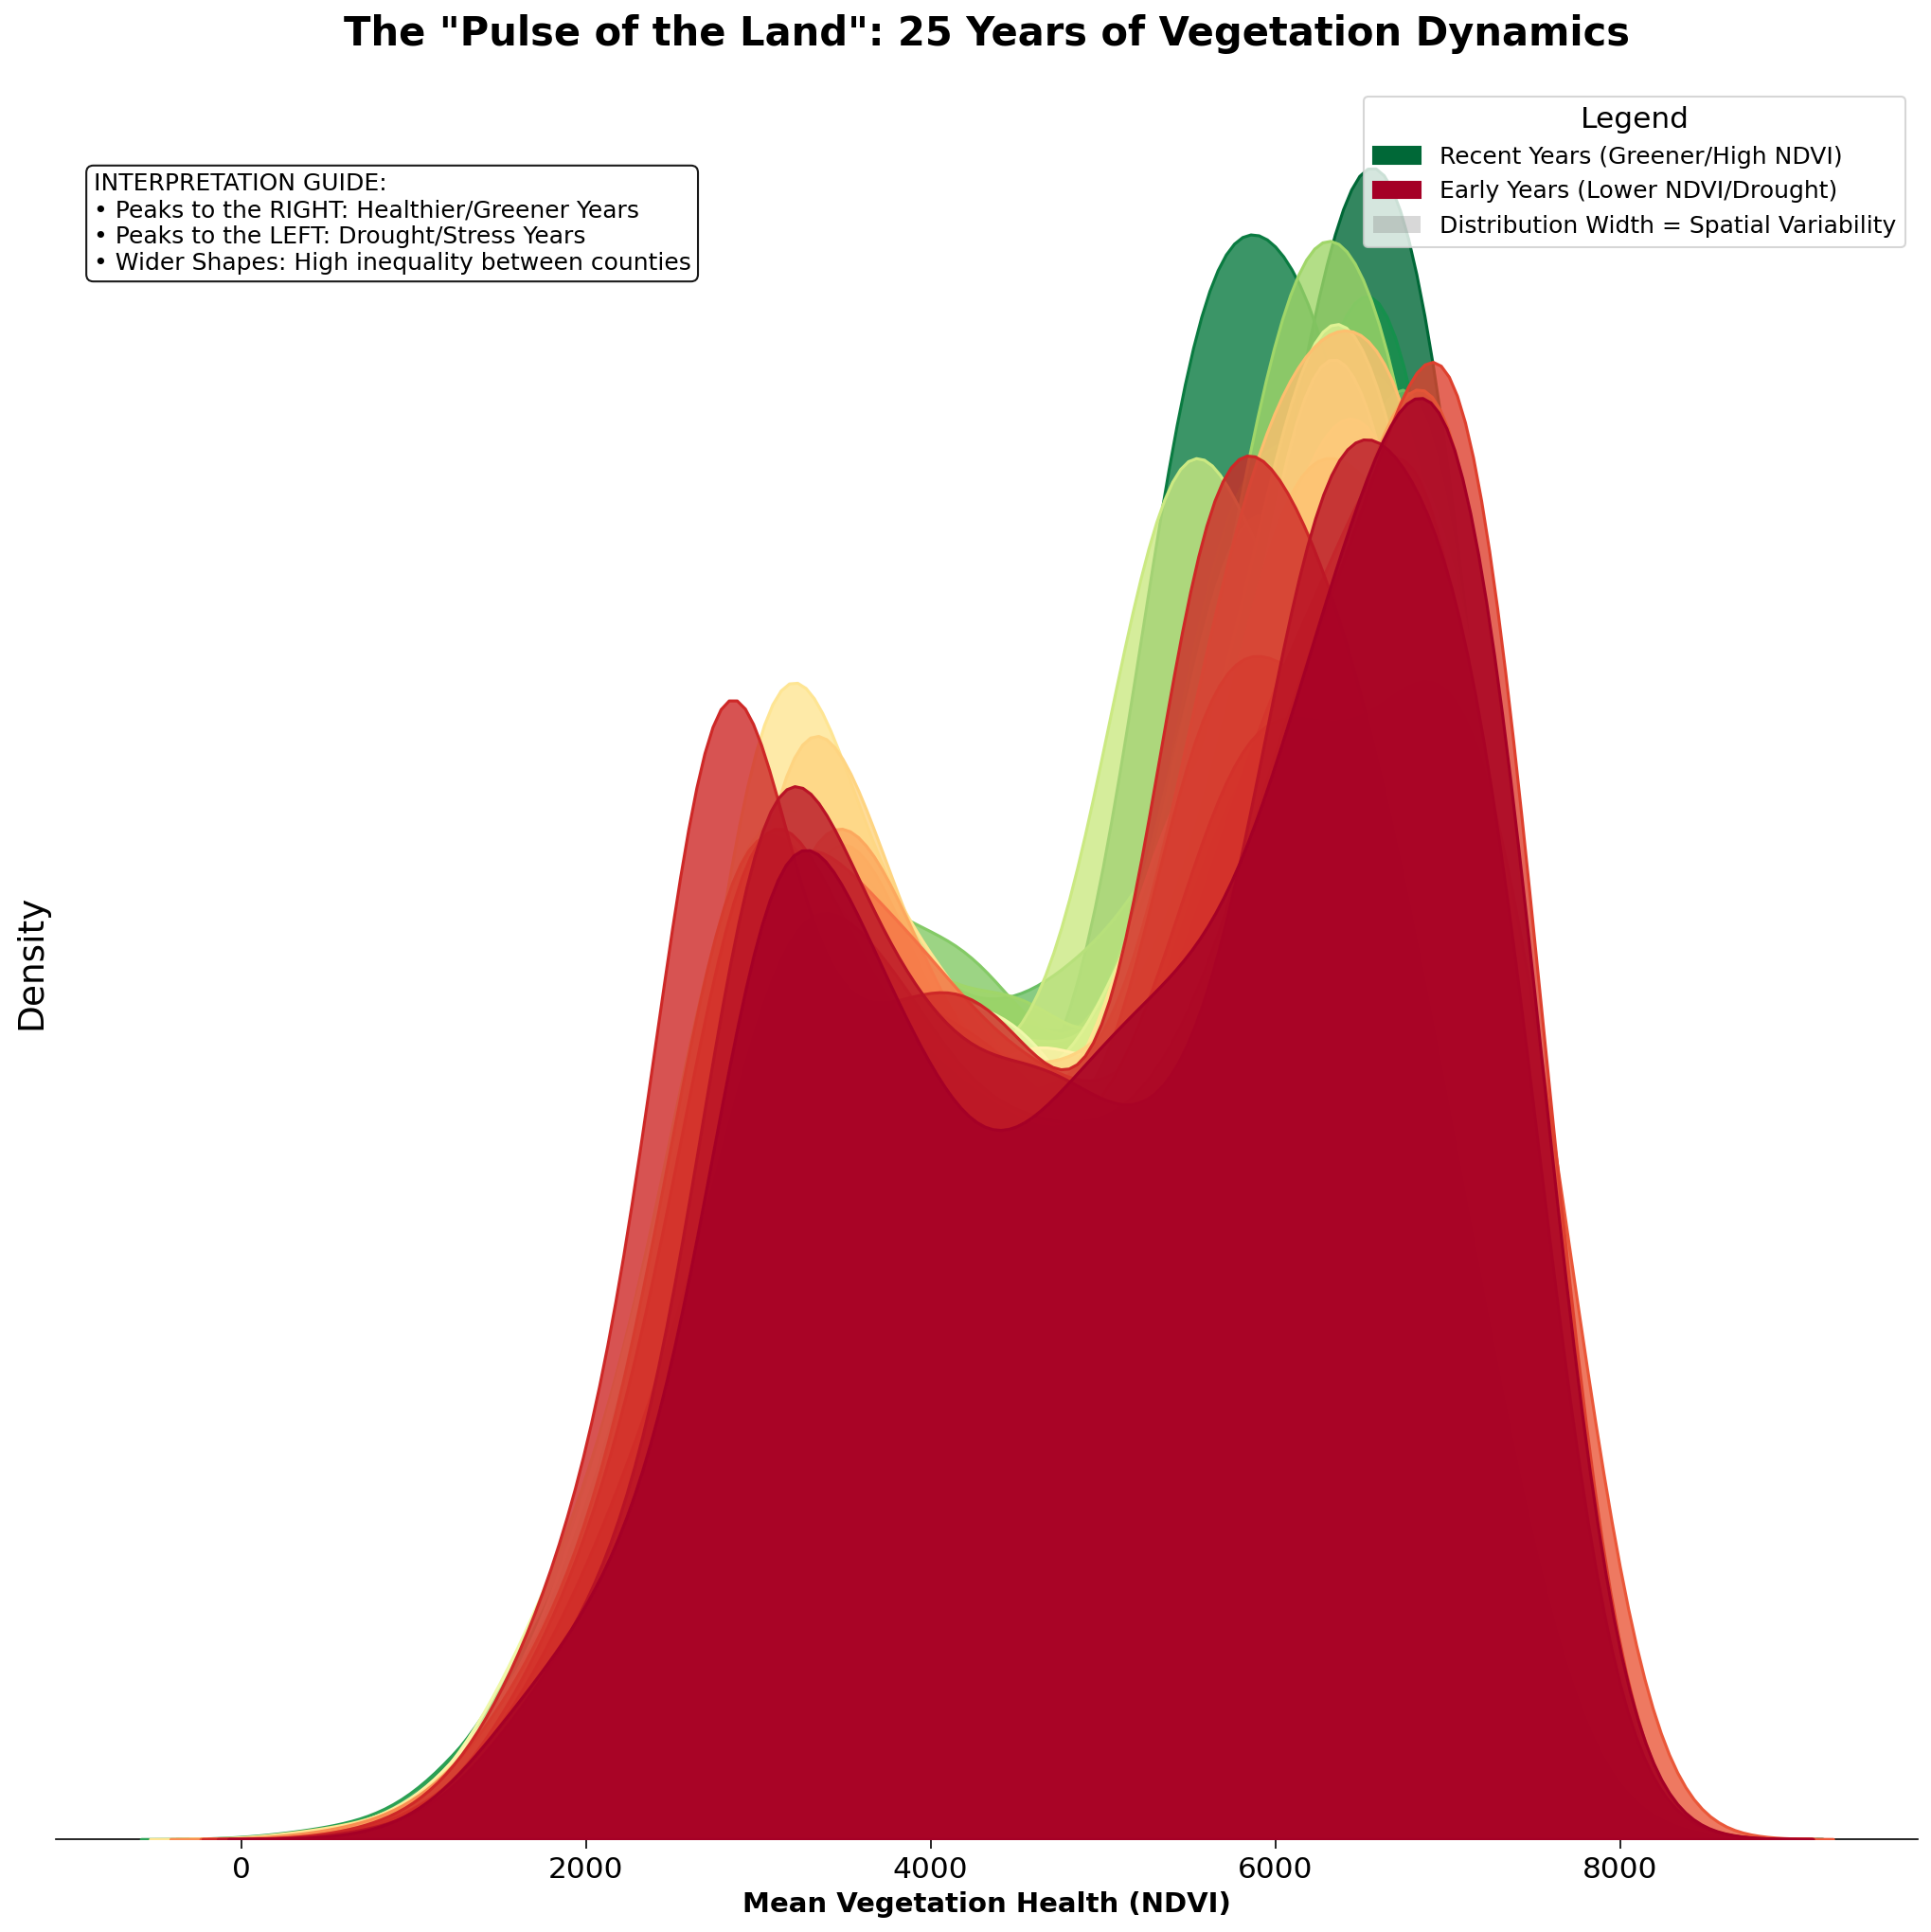

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import pandas as pd
import os

# Ensure directory exists
PLOT_DIR = '/content/drive/MyDrive/Agricultural_RS_LE_2025/plotting'
os.makedirs(PLOT_DIR, exist_ok=True)

def plot_ndvi_ridgeline_enhanced(df):
    print("\n🎨 Generating Visual A (Enhanced)...")

    # 1. Column Selection
    ndvi_candidates = [c for c in df.columns if 'NDVI' in c and 'mean' in c]
    if not ndvi_candidates:
        print("   ❌ ERROR: No 'NDVI' mean columns found in dataframe.")
        return

    # Prefer MODIS, otherwise take first available
    target_col = next((c for c in ndvi_candidates if 'modis' in c), ndvi_candidates[0])
    print(f"   -> Using Target Column: {target_col}")

    # 2. Data Prep
    plot_df = df[['year', target_col]].copy()
    plot_df[target_col] = pd.to_numeric(plot_df[target_col], errors='coerce')
    plot_df = plot_df.dropna()
    plot_df = plot_df[(plot_df['year'] >= 2000) & (plot_df['year'] <= 2024)]

    if plot_df.empty:
        print("   ❌ ERROR: Plot DataFrame is empty after filtering years 2000-2024.")
        return

    # 3. Plotting
    years = sorted(plot_df['year'].unique(), reverse=True)
    colors = plt.cm.RdYlGn(np.linspace(0, 1, len(years)))

    fig, ax = plt.subplots(figsize=(14, 14))

    # Custom Legend Elements
    legend_elements = [
        mpatches.Patch(color=colors[-1], label='Recent Years (Greener/High NDVI)'),
        mpatches.Patch(color=colors[0], label='Early Years (Lower NDVI/Drought)'),
        mpatches.Patch(facecolor='grey', alpha=0.3, label='Distribution Width = Spatial Variability')
    ]

    lines_plotted = 0
    for i, year in enumerate(years):
        subset = plot_df[plot_df['year'] == year][target_col]
        # Skip years with too little data to make a density curve
        if len(subset) < 10 or subset.nunique() < 2: continue

        y_base = i * 0.35

        try:
            sns.kdeplot(data=subset, ax=ax, fill=True, alpha=0.8,
                        linewidth=1.5, color=colors[i], zorder=len(years)-i)

            if len(ax.lines) > lines_plotted:
                line = ax.lines[-1]
                poly = ax.collections[-1]
                line.set_ydata(line.get_ydata() + y_base)
                paths = poly.get_paths()[0]
                paths.vertices[:, 1] += y_base

                # Add Year Label
                ax.text(subset.min(), y_base + 0.05, str(year),
                        fontweight='bold', fontsize=12, ha='right', color='#333333')
                lines_plotted += 1
        except: continue

    # 4. Storytelling Styling
    ax.set_yticks([])
    ax.set_xlabel('Mean Vegetation Health (NDVI)', fontweight='bold', fontsize=14)
    ax.set_title('The "Pulse of the Land": 25 Years of Vegetation Dynamics',
                 pad=20, fontweight='bold', fontsize=20)

    # Add interpretive text box
    stats_text = (
        "INTERPRETATION GUIDE:\n"
        "• Peaks to the RIGHT: Healthier/Greener Years\n"
        "• Peaks to the LEFT: Drought/Stress Years\n"
        "• Wider Shapes: High inequality between counties"
    )
    ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    ax.legend(handles=legend_elements, loc='upper right', fontsize=12, title="Legend")
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, 'Visual_A_Enhanced.png'))
    print("   ✅ Visual A Saved to: plotting/Visual_A_Enhanced.png")
    plt.show()

# --- EXECUTE FIGURE A ---
plot_ndvi_ridgeline_enhanced(df)


🎨 Generating Visual B (Enhanced)...
   -> Found 133 detailed crop columns.
   -> Top Classes found: ['Shrubland', 'Grass/Pasture', 'Evergreen Forest', 'Deciduous Forest', 'Corn', 'Soybeans', 'Woody Wetlands']
   ✅ Visual B Saved.


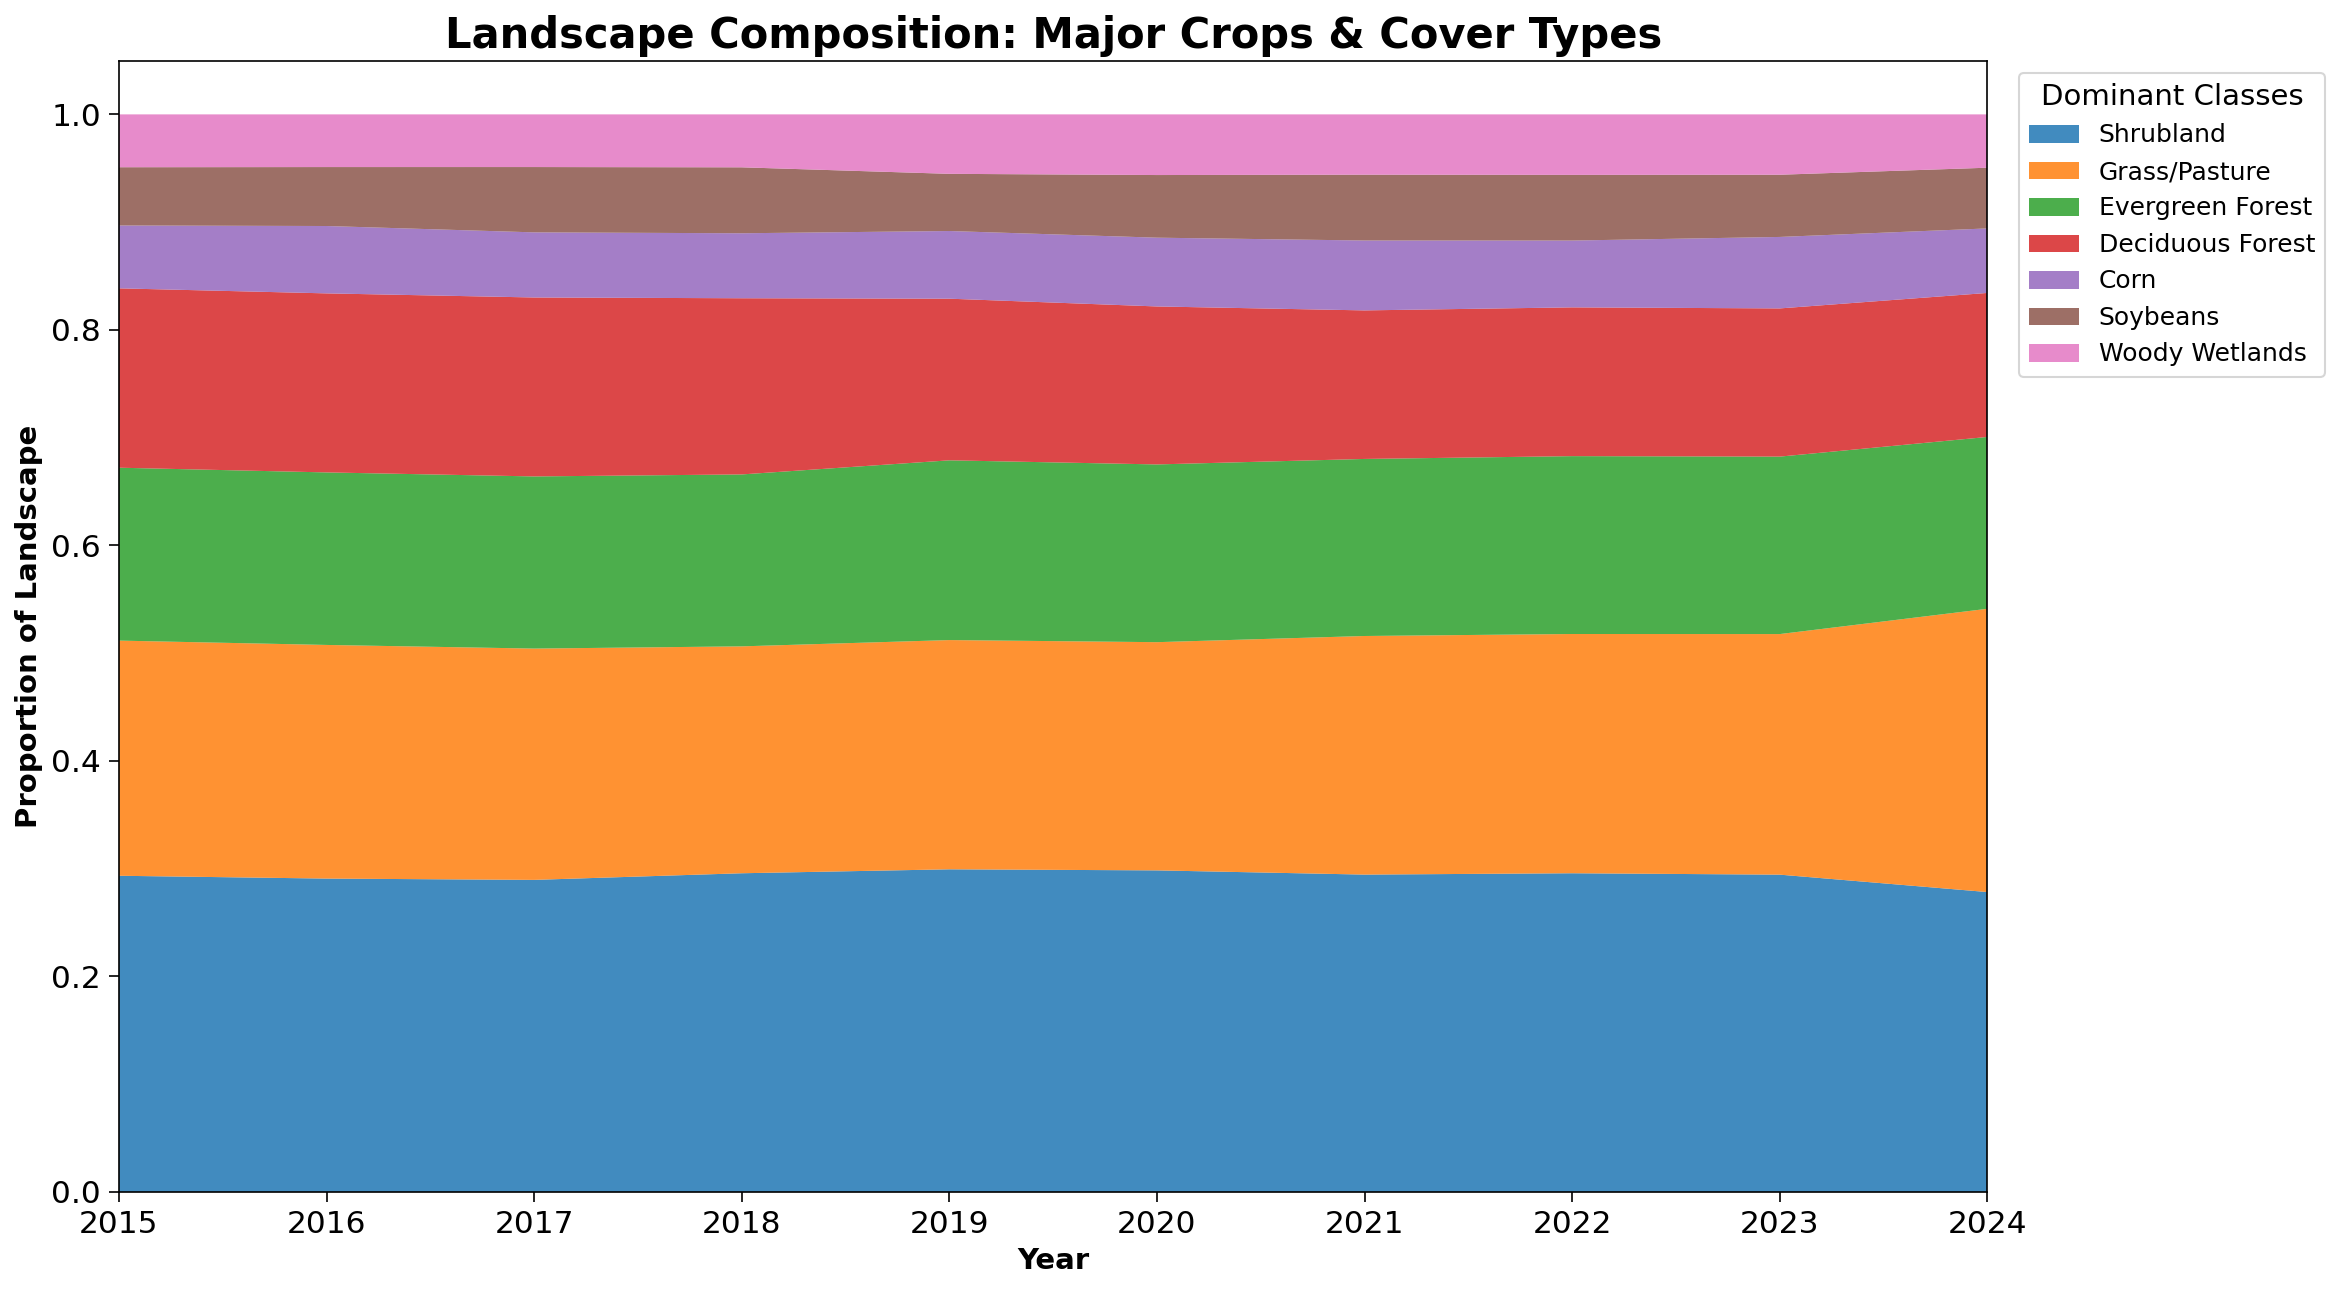

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re # Added regex for precise column finding

# Ensure directory exists
PLOT_DIR = '/content/drive/MyDrive/Agricultural_RS_LE_2025/plotting'
os.makedirs(PLOT_DIR, exist_ok=True)

# --- Helper: USDA Crop Mapping ---
USDA_CROP_MAP = {
    1: 'Corn', 5: 'Soybeans', 24: 'Winter Wheat', 4: 'Sorghum',
    23: 'Spring Wheat', 36: 'Alfalfa', 2: 'Cotton',
    176: 'Grass/Pasture', 152: 'Shrubland', 141: 'Deciduous Forest',
    142: 'Evergreen Forest', 121: 'Developed/Open', 122: 'Developed/Low',
    111: 'Open Water', 190: 'Woody Wetlands', 195: 'Herbaceous Wetlands'
}

def get_crop_name(col_name):
    try:
        # Extract the code from the end (e.g., "cropland_usda_1" -> 1)
        code = int(col_name.split('_')[-1])
        return USDA_CROP_MAP.get(code, f"Crop {code}")
    except:
        return col_name

# --- VISUAL B FUNCTION ---
def plot_land_evolution_enhanced(df):
    print("\n🎨 Generating Visual B (Enhanced)...")

    # 1. Logic: Use Regex to find ONLY crop pixel columns (e.g., 'cropland_usda_1', 'cropland_usda_5')
    # This ignores metadata like 'mean_cropland_usda' or 'CBSA_...'
    target_cols = [c for c in df.columns if re.search(r'cropland_usda_\d+$', c)]

    if target_cols:
        print(f"   -> Found {len(target_cols)} detailed crop columns.")

        # Force numeric
        temp_df = df[['year'] + target_cols].copy()
        for col in target_cols:
            temp_df[col] = pd.to_numeric(temp_df[col], errors='coerce')

        # Sum by year to find Top 7 classes by volume (most abundant crops)
        yearly_sums = temp_df.groupby('year')[target_cols].sum()

        if yearly_sums.empty:
            print("   ❌ ERROR: Aggregation failed.")
            return

        top_cols = yearly_sums.sum().nlargest(7).index.tolist()

        # Map to Real Names
        labels = [get_crop_name(c) for c in top_cols]
        print(f"   -> Top Classes found: {labels}")

        # Aggregation for Plot
        df_subset = temp_df.fillna(0)
        plot_data = df_subset.groupby('year')[top_cols].mean()

        # Normalize to 100% (Stacked Area Chart requires proportions)
        plot_data = plot_data.div(plot_data.sum(axis=1), axis=0)

        # Filter for years >= 2015 (Data is usually cleaner/more consistent here)
        plot_data = plot_data[plot_data.index >= 2015]

        if plot_data.empty:
             print("   ❌ ERROR: No data left after filtering for Year >= 2015.")
             return

        # Plotting
        fig, ax = plt.subplots(figsize=(16, 9))

        ax.stackplot(plot_data.index, plot_data.T, labels=labels,
                     colors=plt.cm.tab10.colors, alpha=0.85)

        ax.set_title('Landscape Composition: Major Crops & Cover Types',
                     fontweight='bold', fontsize=20)
        ax.set_ylabel('Proportion of Landscape', fontweight='bold', fontsize=14)
        ax.set_xlabel('Year', fontweight='bold', fontsize=14)
        ax.set_xlim(plot_data.index.min(), plot_data.index.max())

        # Put legend outside
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
                  title="Dominant Classes", fontsize=12, title_fontsize=14)

        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, 'Visual_B_Enhanced.png'))
        print("   ✅ Visual B Saved.")
        plt.show()
    else:
        print("   ⚠️ No detailed 'cropland_usda_X' columns found. Check your CSV column names.")

# --- EXECUTE ---
plot_land_evolution_enhanced(df)


🎨 Generating Figure 3: The Texture of Farming (Radar ASM Map)...
   -> Mapping Texture Column: mean_soil_texture
   ✅ Figure 3 Saved to: /content/drive/MyDrive/Agricultural_RS_LE_2025/plotting/Visual_New1_Texture_Map.jpg


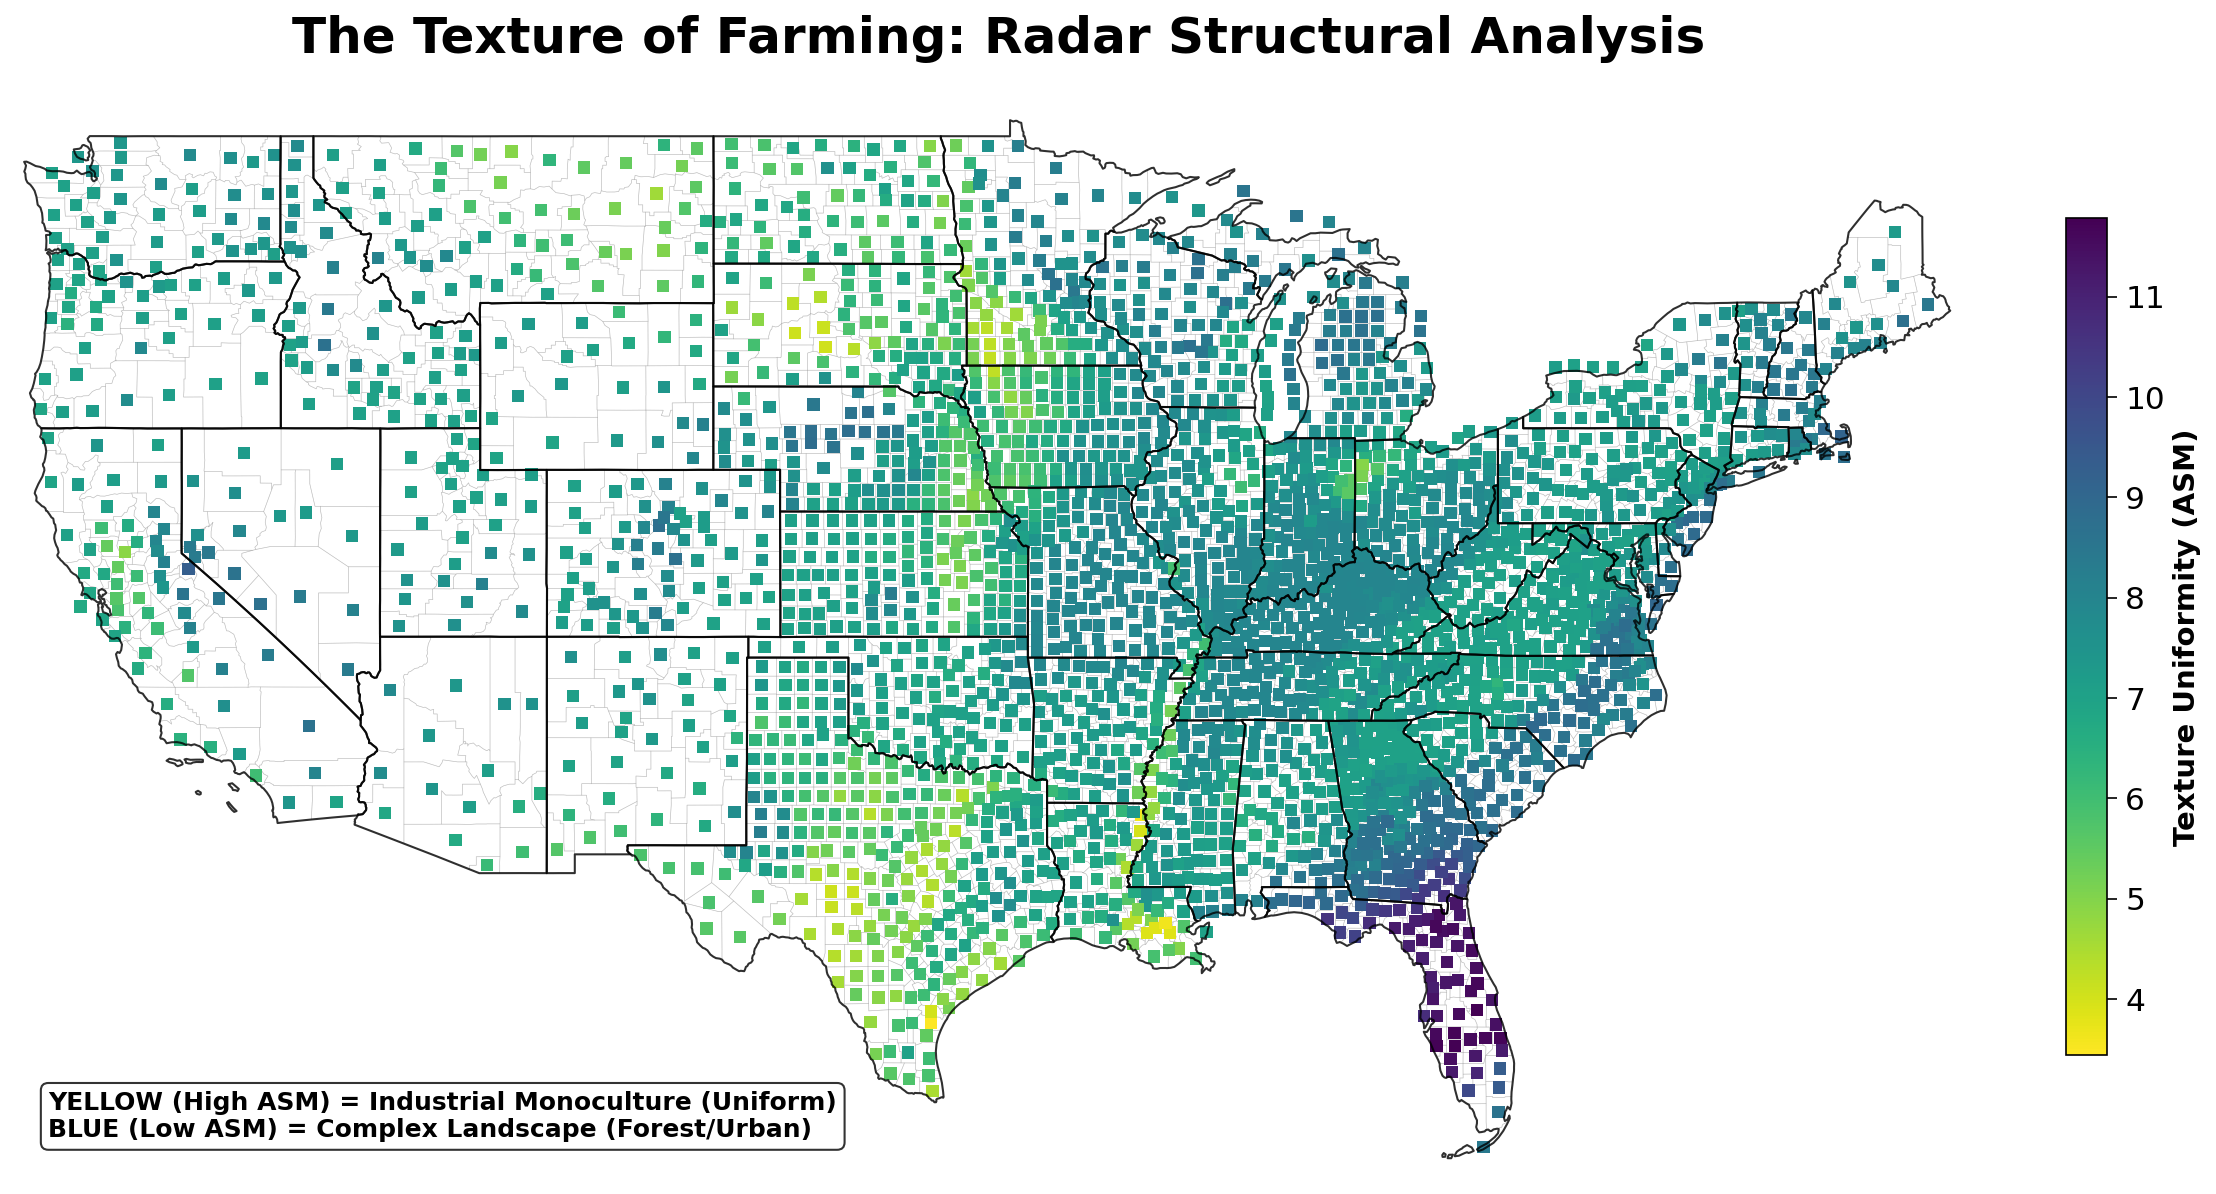

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import os

# Ensure directory exists
PLOT_DIR = '/content/drive/MyDrive/Agricultural_RS_LE_2025/plotting'
os.makedirs(PLOT_DIR, exist_ok=True)

def plot_radar_texture_map(df):
    print("\n🎨 Generating Figure 3: The Texture of Farming (Radar ASM Map)...")

    # --- 1. Data Prep & Coordinates ---
    if 'INTPTLAT' not in df.columns or 'INTPTLON' not in df.columns:
        print("   ❌ Missing coordinates. Skipping.")
        return

    # Create metadata frame
    geo_df = df.groupby('GEOID')[['INTPTLAT', 'INTPTLON']].mean().reset_index()

    # Filter for Contiguous US
    geo_df = geo_df[
        (geo_df['INTPTLAT'] > 24) & (geo_df['INTPTLAT'] < 50) &
        (geo_df['INTPTLON'] > -125) & (geo_df['INTPTLON'] < -65)
    ]

    # --- 2. Load Boundaries ---
    # (Re-using the shapefile loading logic for consistency)
    try:
        states_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
        counties_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_20m.zip"
        us_states = gpd.read_file(states_url)
        us_counties = gpd.read_file(counties_url)
        us_states = us_states.cx[-125:-65, 24:50]
        us_counties = us_counties.cx[-125:-65, 24:50]
        boundaries_loaded = True
    except:
        boundaries_loaded = False

    # --- 3. Select Texture Metric (ASM) ---
    # Looking for Angular Second Moment (ASM) or similar texture feature
    texture_cols = [c for c in df.columns if 'ASM' in c or 'texture' in c]
    if not texture_cols:
        print("   ❌ No Radar Texture (ASM) columns found.")
        return

    # Prefer 'mean' aggregation of ASM
    target_col = next((c for c in texture_cols if 'mean' in c), texture_cols[0])
    print(f"   -> Mapping Texture Column: {target_col}")

    # Aggregate texture by county
    texture_series = df.groupby('GEOID')[target_col].mean()
    map_data = geo_df.merge(texture_series, on='GEOID')

    # --- 4. Plotting ---
    fig, ax = plt.subplots(figsize=(18, 12))

    if boundaries_loaded:
        us_counties.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.3, alpha=0.3, zorder=1)
        us_states.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.0, alpha=0.8, zorder=3)

    # Plot Points
    # Viridis_r (Reversed): Yellow=High (Uniform), Purple=Low (Complex)
    # or 'cividis' is also good for this "industrial" look.
    scatter = ax.scatter(
        map_data['INTPTLON'],
        map_data['INTPTLAT'],
        c=map_data[target_col],
        cmap='viridis_r',
        s=35,
        marker='s',
        alpha=1.0,
        edgecolors='none',
        zorder=2
    )

    ax.set_title('The Texture of Farming: Radar Structural Analysis', pad=20, fontsize=24, fontweight='bold')
    ax.set_xlim(-125, -66)
    ax.set_ylim(24, 50)
    ax.axis('off')

    # Add Interpretation Text
    ax.text(
        -124, 25,
        "YELLOW (High ASM) = Industrial Monoculture (Uniform)\nBLUE (Low ASM) = Complex Landscape (Forest/Urban)",
        fontsize=12, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round')
    )

    cbar = plt.colorbar(scatter, ax=ax, fraction=0.02, pad=0.04)
    cbar.set_label('Texture Uniformity (ASM)', fontsize=14, fontweight='bold')

    save_path = os.path.join(PLOT_DIR, 'Visual_New1_Texture_Map.jpg')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"   ✅ Figure 3 Saved to: {save_path}")
    plt.show()

# --- EXECUTE FIGURE 3 ---
plot_radar_texture_map(df)


🎨 Generating Figure 4: Ecological Stress Regimes (Visual E)...
   -> Fetching US Census Shapefiles for background...
   -> Calculating LST-NDVI Correlations (This determines the color)...


/tmp/ipython-input-1946825605.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_series = df.groupby('GEOID').apply(calc_corr)


   ✅ Figure 4 Saved to: /content/drive/MyDrive/Agricultural_RS_LE_2025/plotting/Visual_E_Climate_Map_Enhanced.png


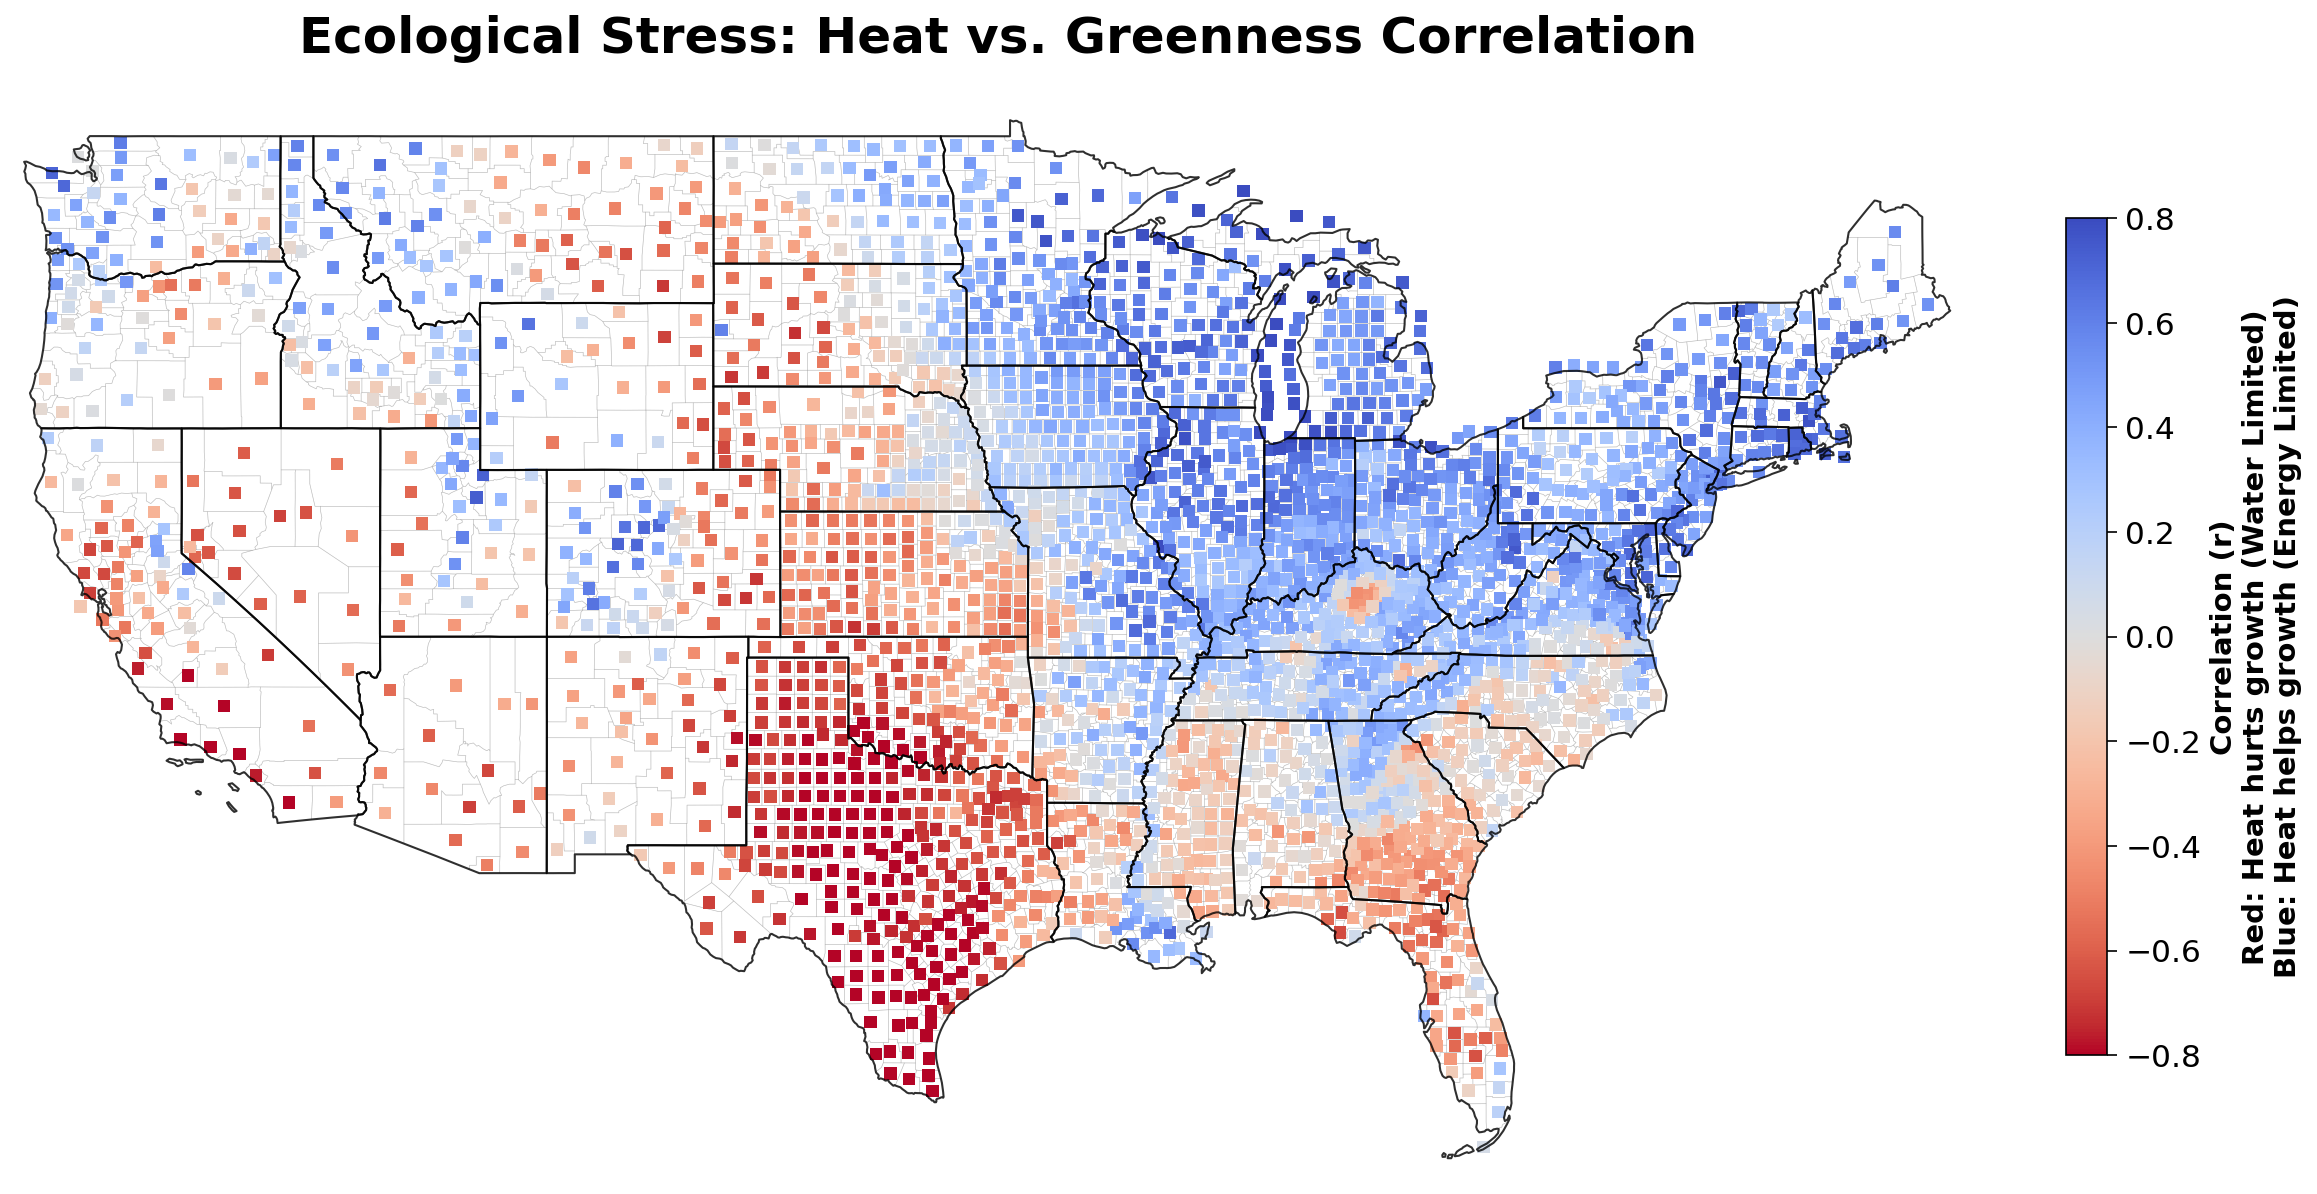

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import Point

# Ensure directory exists
PLOT_DIR = '/content/drive/MyDrive/Agricultural_RS_LE_2025/plotting'
os.makedirs(PLOT_DIR, exist_ok=True)

def plot_climate_stress_map(df):
    print("\n🎨 Generating Figure 4: Ecological Stress Regimes (Visual E)...")

    # --- 1. Data Prep & Coordinates ---
    if 'INTPTLAT' not in df.columns or 'INTPTLON' not in df.columns:
        print("   ❌ Missing coordinates (INTPTLAT/INTPTLON). Skipping.")
        return

    # Create metadata frame (1 row per county)
    # Group by GEOID to get a unique list of counties with their coords
    geo_df = df.groupby('GEOID')[['INTPTLAT', 'INTPTLON']].mean().reset_index()

    # Filter for Contiguous US for cleaner plotting (Exclude Alaska/Hawaii/Territories)
    geo_df = geo_df[
        (geo_df['INTPTLAT'] > 24) & (geo_df['INTPTLAT'] < 50) &
        (geo_df['INTPTLON'] > -125) & (geo_df['INTPTLON'] < -65)
    ]

    # --- 2. Load Map Boundaries (Background) ---
    print("   -> Fetching US Census Shapefiles for background...")
    try:
        states_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
        counties_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_20m.zip"

        us_states = gpd.read_file(states_url)
        us_counties = gpd.read_file(counties_url)

        # Clip to Contiguous US
        us_states = us_states.cx[-125:-65, 24:50]
        us_counties = us_counties.cx[-125:-65, 24:50]
        boundaries_loaded = True
    except Exception as e:
        print(f"   ⚠️ Could not load shapefiles: {e}. Plotting points only.")
        boundaries_loaded = False

    # --- 3. Calculate Climate Stress Correlations ---
    print("   -> Calculating LST-NDVI Correlations (This determines the color)...")

    # Find the correct columns dynamically
    lst_col = next((c for c in df.columns if 'LST_Day' in c and 'mean' in c), None)
    ndvi_col = next((c for c in df.columns if 'NDVI' in c and 'modis' in c and 'mean' in c), None)

    if not lst_col or not ndvi_col:
        print("   ❌ Missing LST or NDVI data columns.")
        return

    # Correlation Function: Does heat help (Blue) or hurt (Red) vegetation?
    def calc_corr(x):
        v = x[[lst_col, ndvi_col]].dropna()
        # We need enough data points to calculate a valid correlation
        return v[lst_col].corr(v[ndvi_col]) if len(v) > 5 else np.nan

    # Apply correlation per county
    corr_series = df.groupby('GEOID').apply(calc_corr)
    corr_series.name = 'lst_ndvi_corr'

    # Merge correlation data back to coordinates
    map_data = geo_df.merge(corr_series, on='GEOID')

    # --- 4. Plotting ---
    fig, ax = plt.subplots(figsize=(18, 12))

    # Draw Boundaries first
    if boundaries_loaded:
        us_counties.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.3, alpha=0.3, zorder=1)
        us_states.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.0, alpha=0.8, zorder=3)

    # Plot Data Points
    scatter = ax.scatter(
        map_data['INTPTLON'],
        map_data['INTPTLAT'],
        c=map_data['lst_ndvi_corr'],
        cmap='coolwarm_r', # Reversed: Red = Negative Corr (Stress), Blue = Positive (Energy Limited)
        s=35,              # Size
        marker='s',        # Square marker fills map better
        alpha=1.0,
        edgecolors='none',
        vmin=-0.8, vmax=0.8, # Cap contrast for visibility
        zorder=2
    )

    # Styling
    ax.set_title('Ecological Stress: Heat vs. Greenness Correlation', pad=20, fontsize=24, fontweight='bold')
    ax.set_xlim(-125, -66)
    ax.set_ylim(24, 50)
    ax.axis('off')

    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.02, pad=0.04)
    cbar.set_label('Correlation (r)\nRed: Heat hurts growth (Water Limited)\nBlue: Heat helps growth (Energy Limited)', fontsize=14, fontweight='bold')

    # Save
    save_path = os.path.join(PLOT_DIR, 'Visual_E_Climate_Map_Enhanced.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"   ✅ Figure 4 Saved to: {save_path}")
    plt.show()

# --- EXECUTE FIGURE 4 ---
plot_climate_stress_map(df)


🎨 Generating Visual A (Enhanced)...
   -> Target: NDVI_mean_modis_ndvi
   ✅ Visual A Saved.


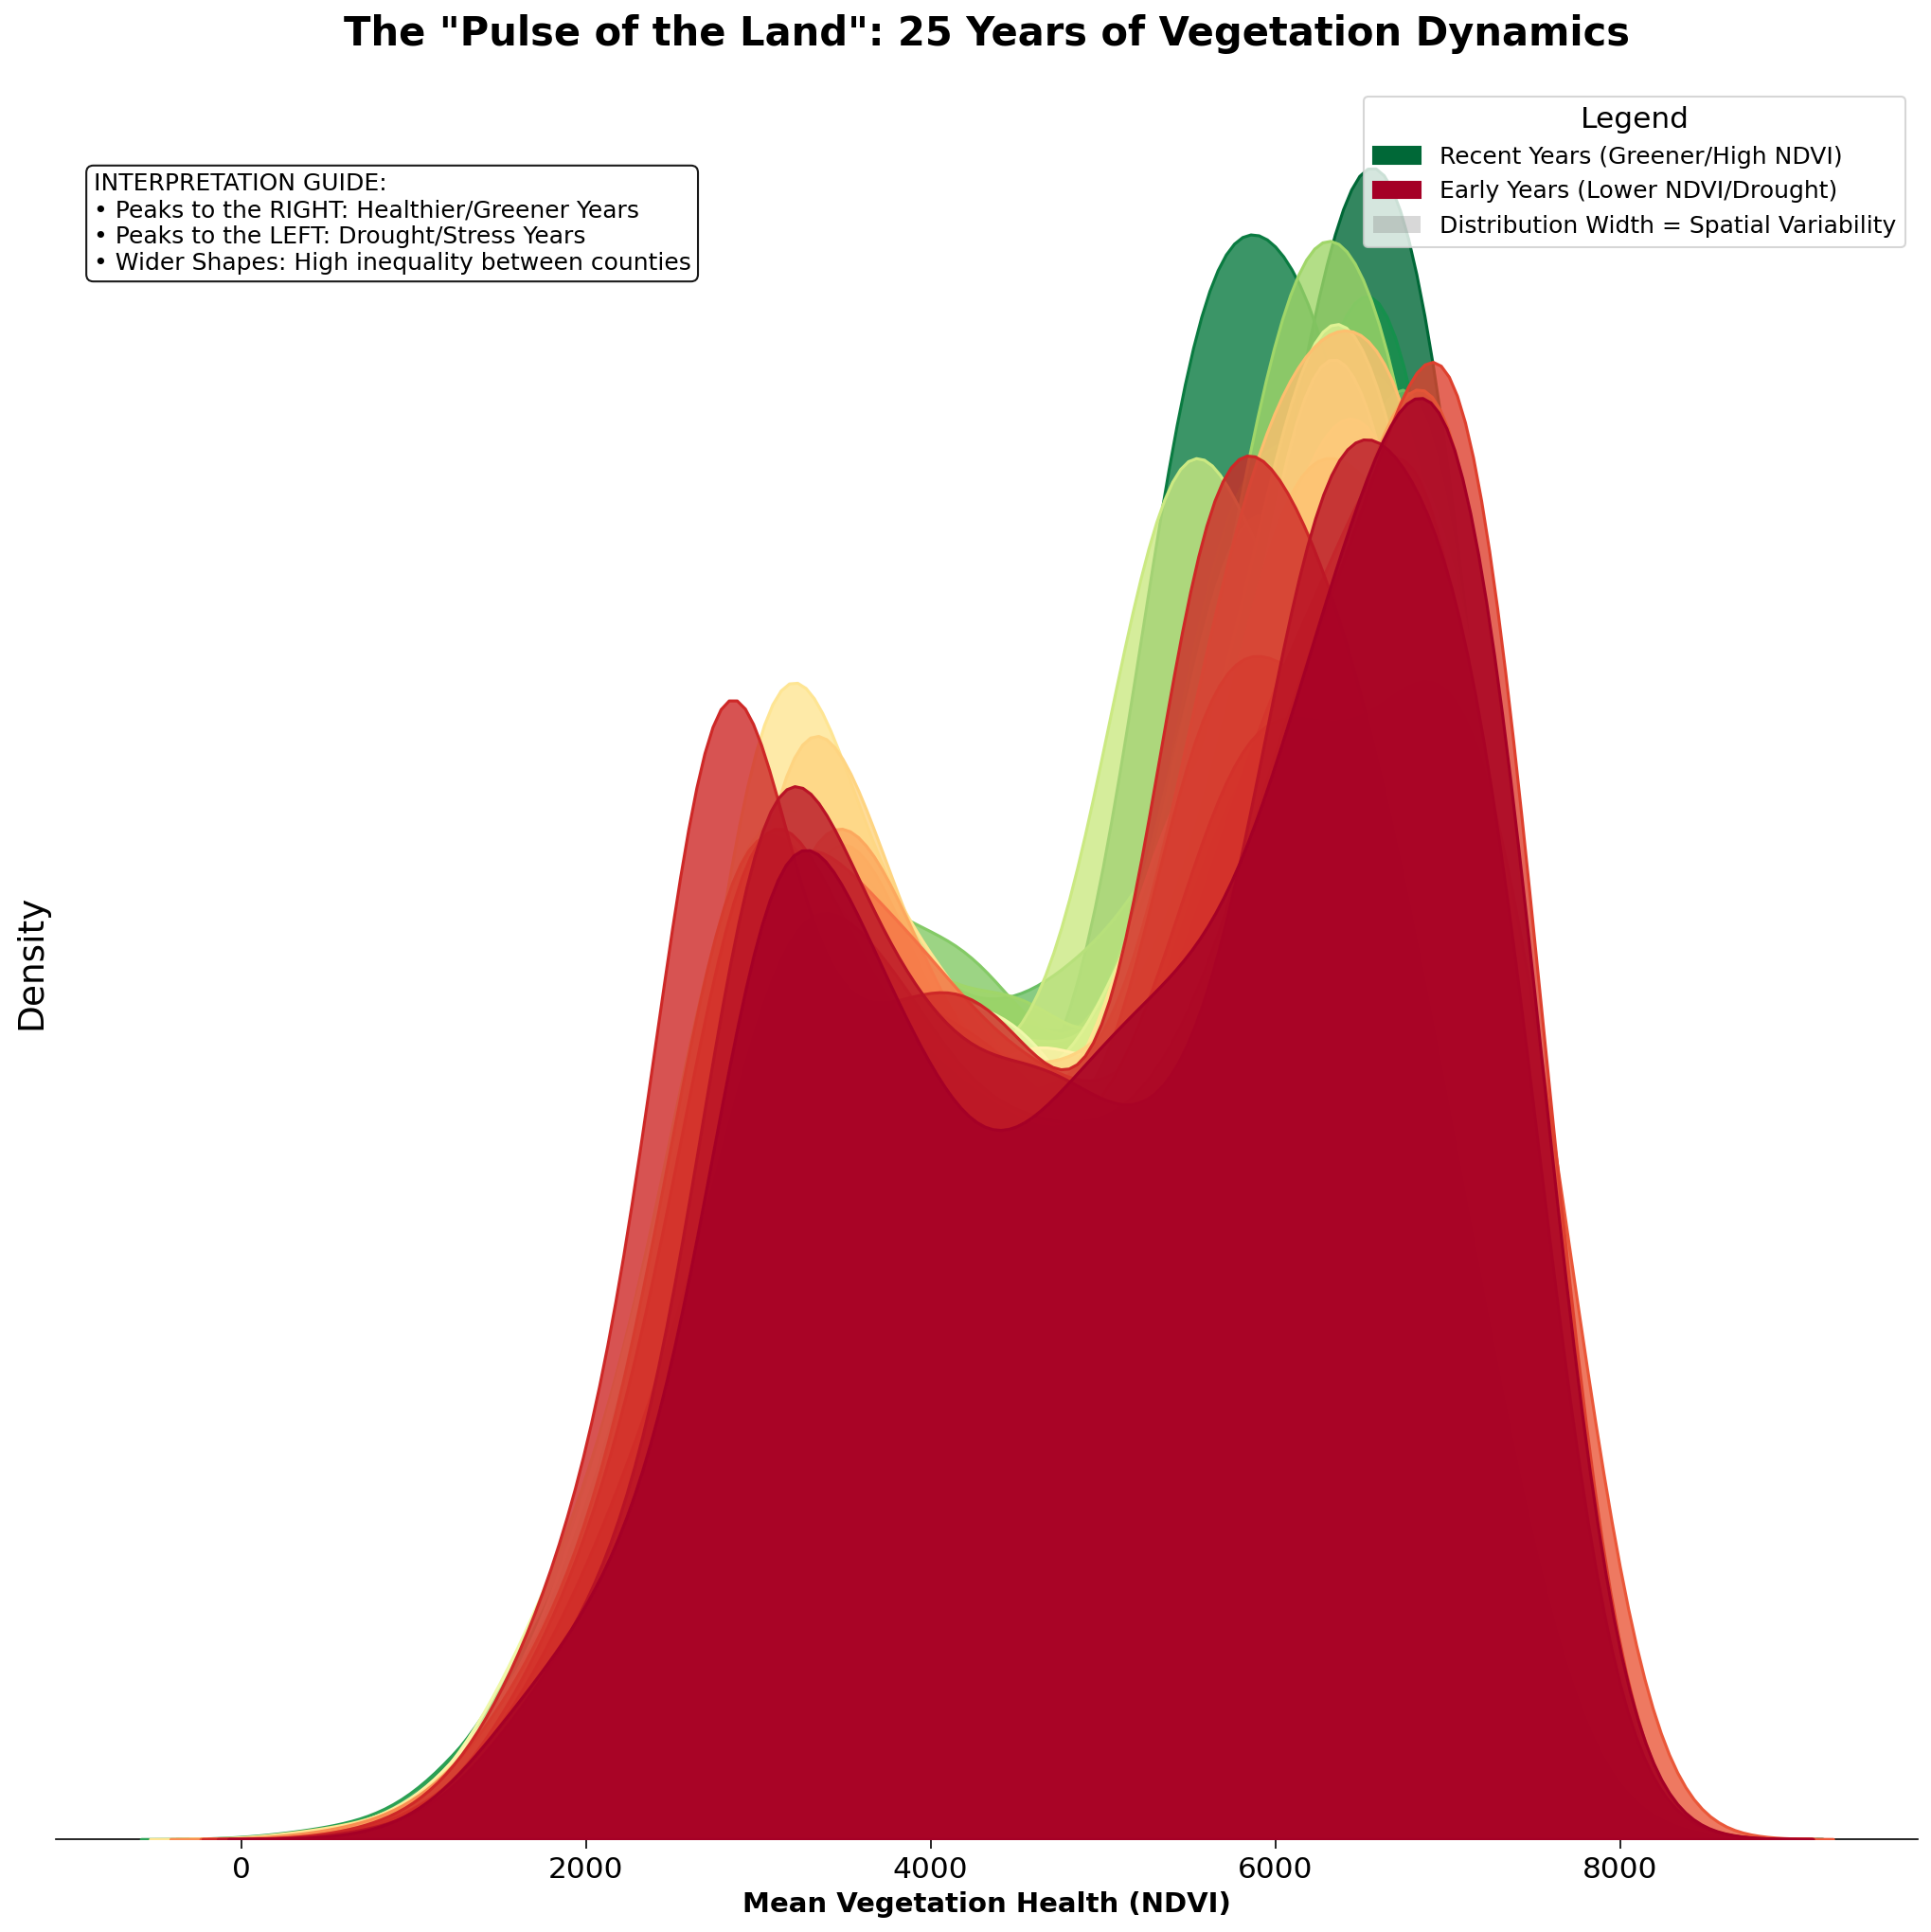


🎨 Generating Visual B (Enhanced)...
   -> Using Cropland USDA (Detailed)
   ✅ Visual B Saved.


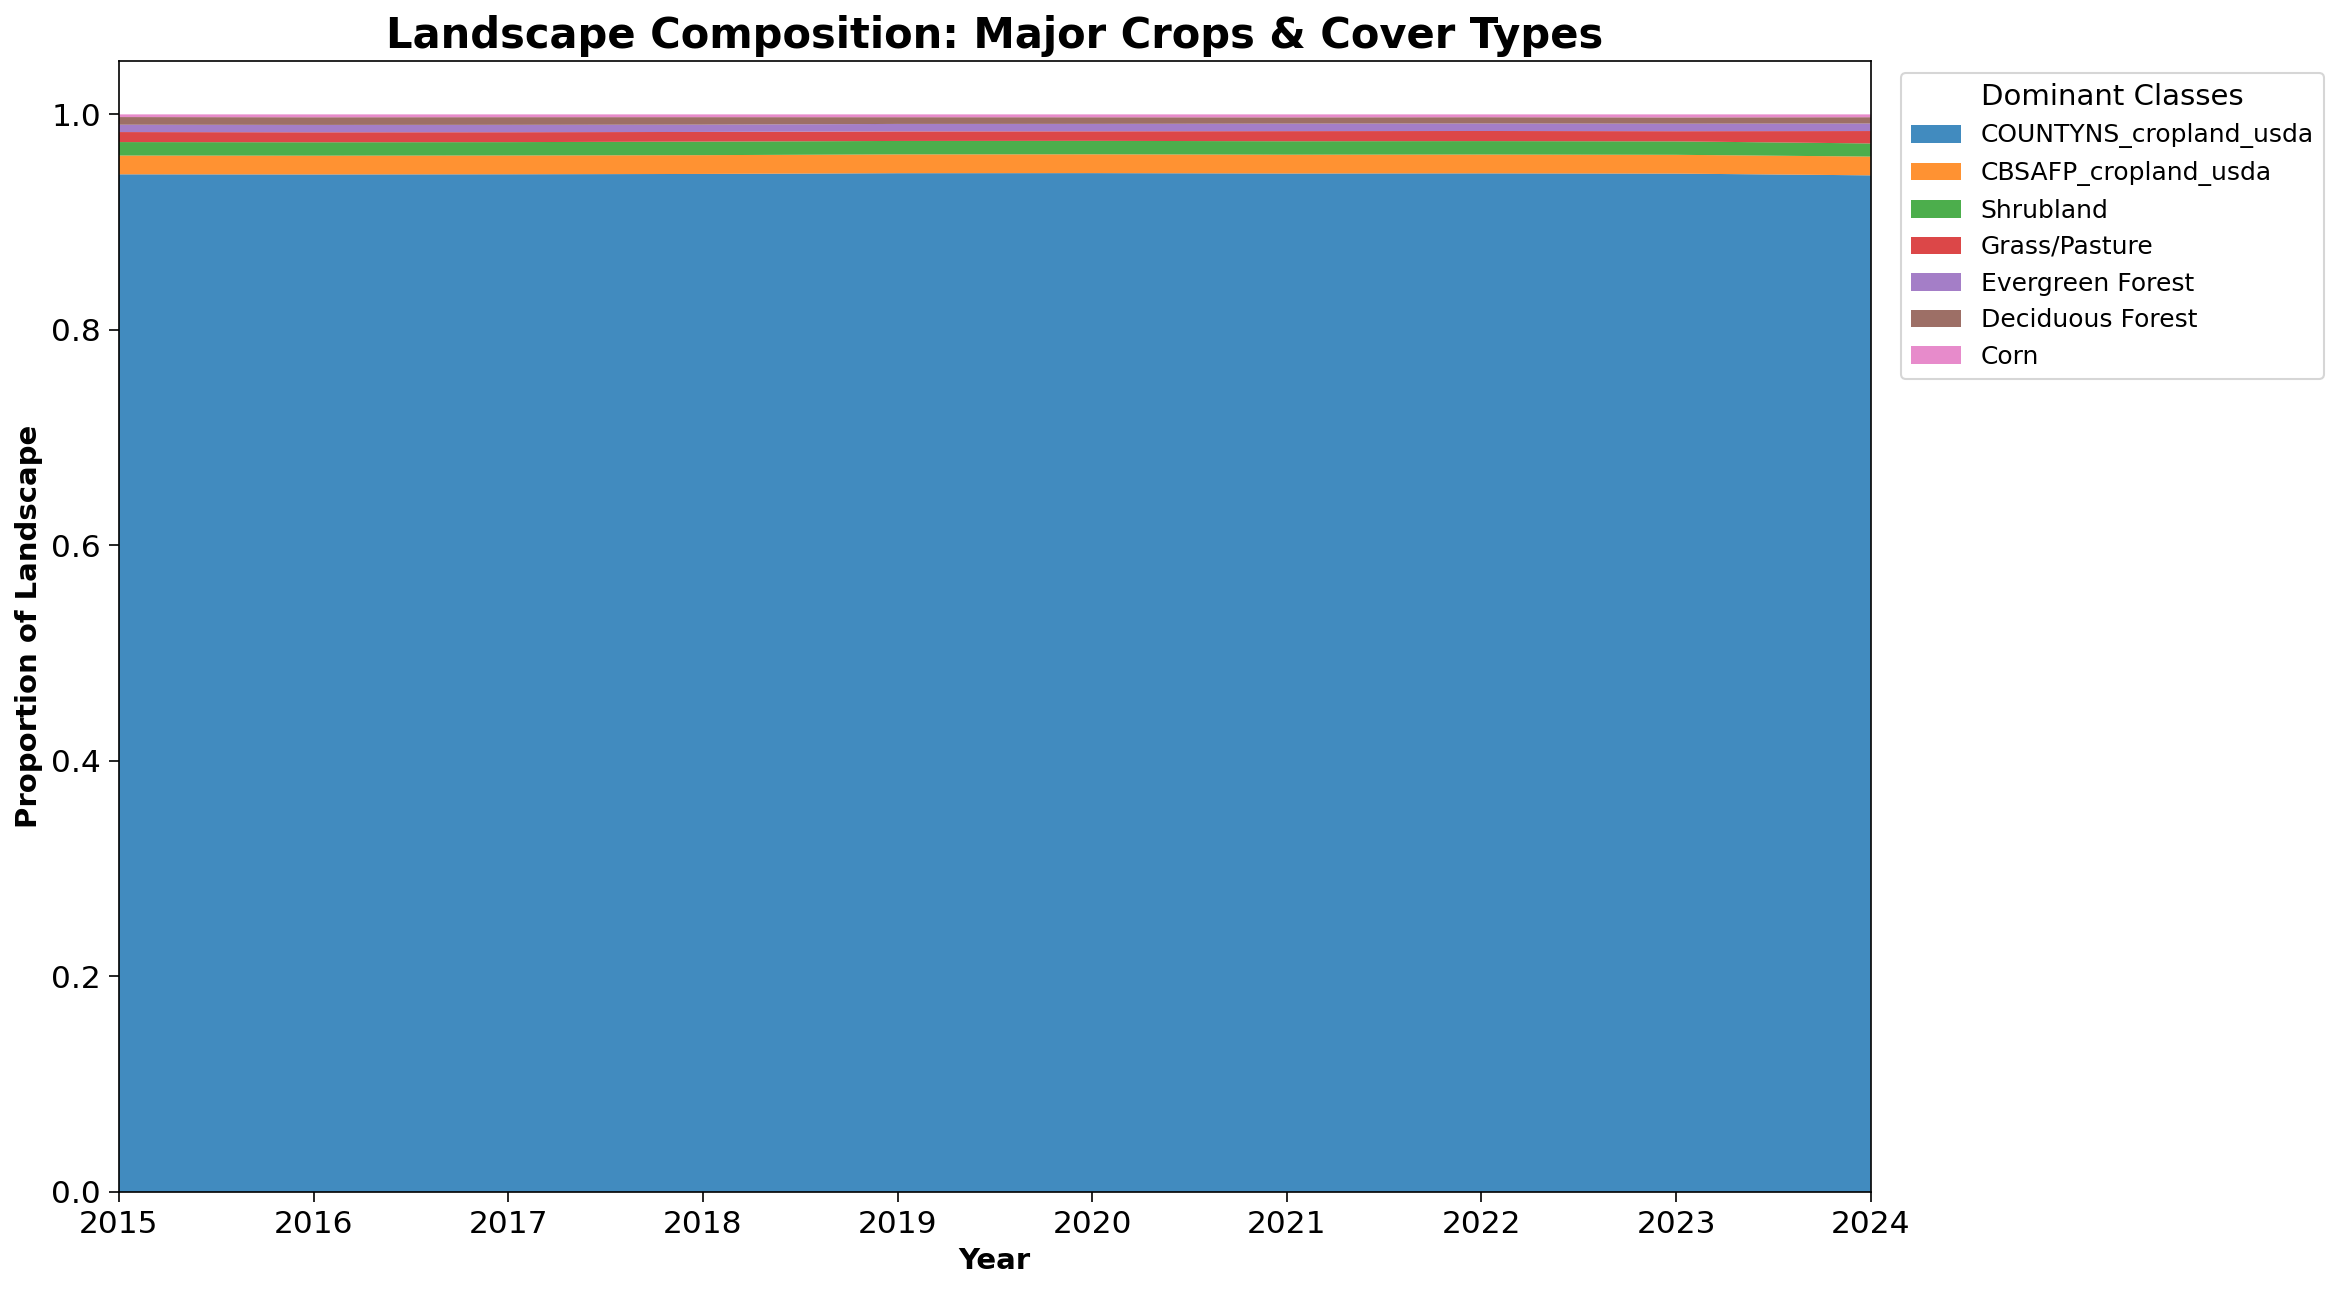

In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║   Phase 2.6: ENHANCED VISUALIZATION CODE (Better Legends & Labels)       ║
# ╚══════════════════════════════════════════════════════════════════════════╝
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import pandas as pd
import os

# Re-verify paths
PLOT_DIR = '/content/drive/MyDrive/Agricultural_RS_LE_2025/plotting'
os.makedirs(PLOT_DIR, exist_ok=True)

# --- USDA CROP MAPPING (The Decoder Ring) ---
# Source: USDA NASS Cropland Data Layer Metadata
USDA_CROP_MAP = {
    1: 'Corn', 5: 'Soybeans', 24: 'Winter Wheat', 4: 'Sorghum',
    23: 'Spring Wheat', 36: 'Alfalfa', 2: 'Cotton',
    176: 'Grass/Pasture', 152: 'Shrubland', 141: 'Deciduous Forest',
    142: 'Evergreen Forest', 121: 'Developed/Open', 122: 'Developed/Low',
    111: 'Open Water', 190: 'Woody Wetlands', 195: 'Herbaceous Wetlands'
}

def get_crop_name(col_name):
    """Extracts code from 'cropland_usda_1' and returns 'Corn'"""
    try:
        code = int(col_name.split('_')[-1])
        return USDA_CROP_MAP.get(code, f"Crop {code}")
    except:
        return col_name

# --- VISUAL A: ENHANCED NDVI RIDGELINE ---
def plot_ndvi_ridgeline_enhanced(df):
    print("\n🎨 Generating Visual A (Enhanced)...")

    # 1. Column Selection
    ndvi_candidates = [c for c in df.columns if 'NDVI' in c and 'mean' in c]
    if not ndvi_candidates: return
    target_col = next((c for c in ndvi_candidates if 'modis' in c), ndvi_candidates[0])
    print(f"   -> Target: {target_col}")

    # 2. Data Prep
    plot_df = df[['year', target_col]].copy()
    plot_df[target_col] = pd.to_numeric(plot_df[target_col], errors='coerce')
    plot_df = plot_df.dropna()
    plot_df = plot_df[(plot_df['year'] >= 2000) & (plot_df['year'] <= 2024)]

    if plot_df.empty: return

    # 3. Plotting
    years = sorted(plot_df['year'].unique(), reverse=True)
    colors = plt.cm.RdYlGn(np.linspace(0, 1, len(years)))

    fig, ax = plt.subplots(figsize=(14, 14)) # Wider for legend

    # Custom Legend Elements
    legend_elements = [
        mpatches.Patch(color=colors[-1], label='Recent Years (Greener/High NDVI)'),
        mpatches.Patch(color=colors[0], label='Early Years (Lower NDVI/Drought)'),
        mpatches.Patch(facecolor='grey', alpha=0.3, label='Distribution Width = Spatial Variability')
    ]

    lines_plotted = 0
    for i, year in enumerate(years):
        subset = plot_df[plot_df['year'] == year][target_col]
        if len(subset) < 10 or subset.nunique() < 2: continue

        y_base = i * 0.35

        try:
            sns.kdeplot(data=subset, ax=ax, fill=True, alpha=0.8,
                       linewidth=1.5, color=colors[i], zorder=len(years)-i)

            if len(ax.lines) > lines_plotted:
                line = ax.lines[-1]
                poly = ax.collections[-1]
                line.set_ydata(line.get_ydata() + y_base)
                paths = poly.get_paths()[0]
                paths.vertices[:, 1] += y_base

                # Add Year Label
                ax.text(subset.min(), y_base + 0.05, str(year),
                       fontweight='bold', fontsize=12, ha='right', color='#333333')
                lines_plotted += 1
        except: continue

    # 4. Storytelling Styling
    ax.set_yticks([])
    ax.set_xlabel('Mean Vegetation Health (NDVI)', fontweight='bold', fontsize=14)
    ax.set_title('The "Pulse of the Land": 25 Years of Vegetation Dynamics',
                 pad=20, fontweight='bold', fontsize=20)

    # Add interpretive text box
    stats_text = (
        "INTERPRETATION GUIDE:\n"
        "• Peaks to the RIGHT: Healthier/Greener Years\n"
        "• Peaks to the LEFT: Drought/Stress Years\n"
        "• Wider Shapes: High inequality between counties"
    )
    ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    ax.legend(handles=legend_elements, loc='upper right', fontsize=12, title="Legend")
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, 'Visual_A_Enhanced.png'))
    print("   ✅ Visual A Saved.")
    plt.show()


# --- VISUAL B: ENHANCED LAND EVOLUTION ---
def plot_land_evolution_enhanced(df):
    print("\n🎨 Generating Visual B (Enhanced)...")

    # 1. Logic: Prioritize USDA for detail, map codes to names
    target_cols = [c for c in df.columns if 'cropland_usda' in c]

    if target_cols:
        print("   -> Using Cropland USDA (Detailed)")

        # Force numeric
        temp_df = df[['year'] + target_cols].copy()
        for col in target_cols:
            temp_df[col] = pd.to_numeric(temp_df[col], errors='coerce')

        # Sum by year to find Top 7 classes by volume
        yearly_sums = temp_df.groupby('year')[target_cols].sum()
        top_cols = yearly_sums.sum().nlargest(7).index.tolist()

        # Map to Real Names
        labels = [get_crop_name(c) for c in top_cols]

        # Aggregation for Plot
        df_subset = temp_df.fillna(0)
        plot_data = df_subset.groupby('year')[top_cols].mean()

        # Normalize to 100%
        plot_data = plot_data.div(plot_data.sum(axis=1), axis=0)
        plot_data = plot_data[plot_data.index >= 2015]

        if plot_data.empty:
             print("   ❌ No data left to plot.")
             return

        # Plotting
        fig, ax = plt.subplots(figsize=(16, 9))

        # Use a distinct color palette (tab10 or Set2)
        ax.stackplot(plot_data.index, plot_data.T, labels=labels,
                     colors=plt.cm.tab10.colors, alpha=0.85)

        ax.set_title('Landscape Composition: Major Crops & Cover Types',
                     fontweight='bold', fontsize=20)
        ax.set_ylabel('Proportion of Landscape', fontweight='bold', fontsize=14)
        ax.set_xlabel('Year', fontweight='bold', fontsize=14)
        ax.set_xlim(plot_data.index.min(), plot_data.index.max())

        # Put legend outside
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
                  title="Dominant Classes", fontsize=12, title_fontsize=14)

        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, 'Visual_B_Enhanced.png'))
        print("   ✅ Visual B Saved.")
        plt.show()

    else:
        print("   ⚠️ No detailed crop data found. Falling back to Dynamic World.")
        # Fallback logic for Dynamic World could go here if needed

# --- EXECUTE ---
plot_ndvi_ridgeline_enhanced(df)
plot_land_evolution_enhanced(df)

🎨 Generating New Visual 1: The 'Texture of Farming' Map...
   -> Mapping Metric: VV_asm_mean
   ✅ Saved Texture Map to: /content/drive/MyDrive/Agricultural_RS_LE_2025/plotting/Visual_New1_Texture_Map.png


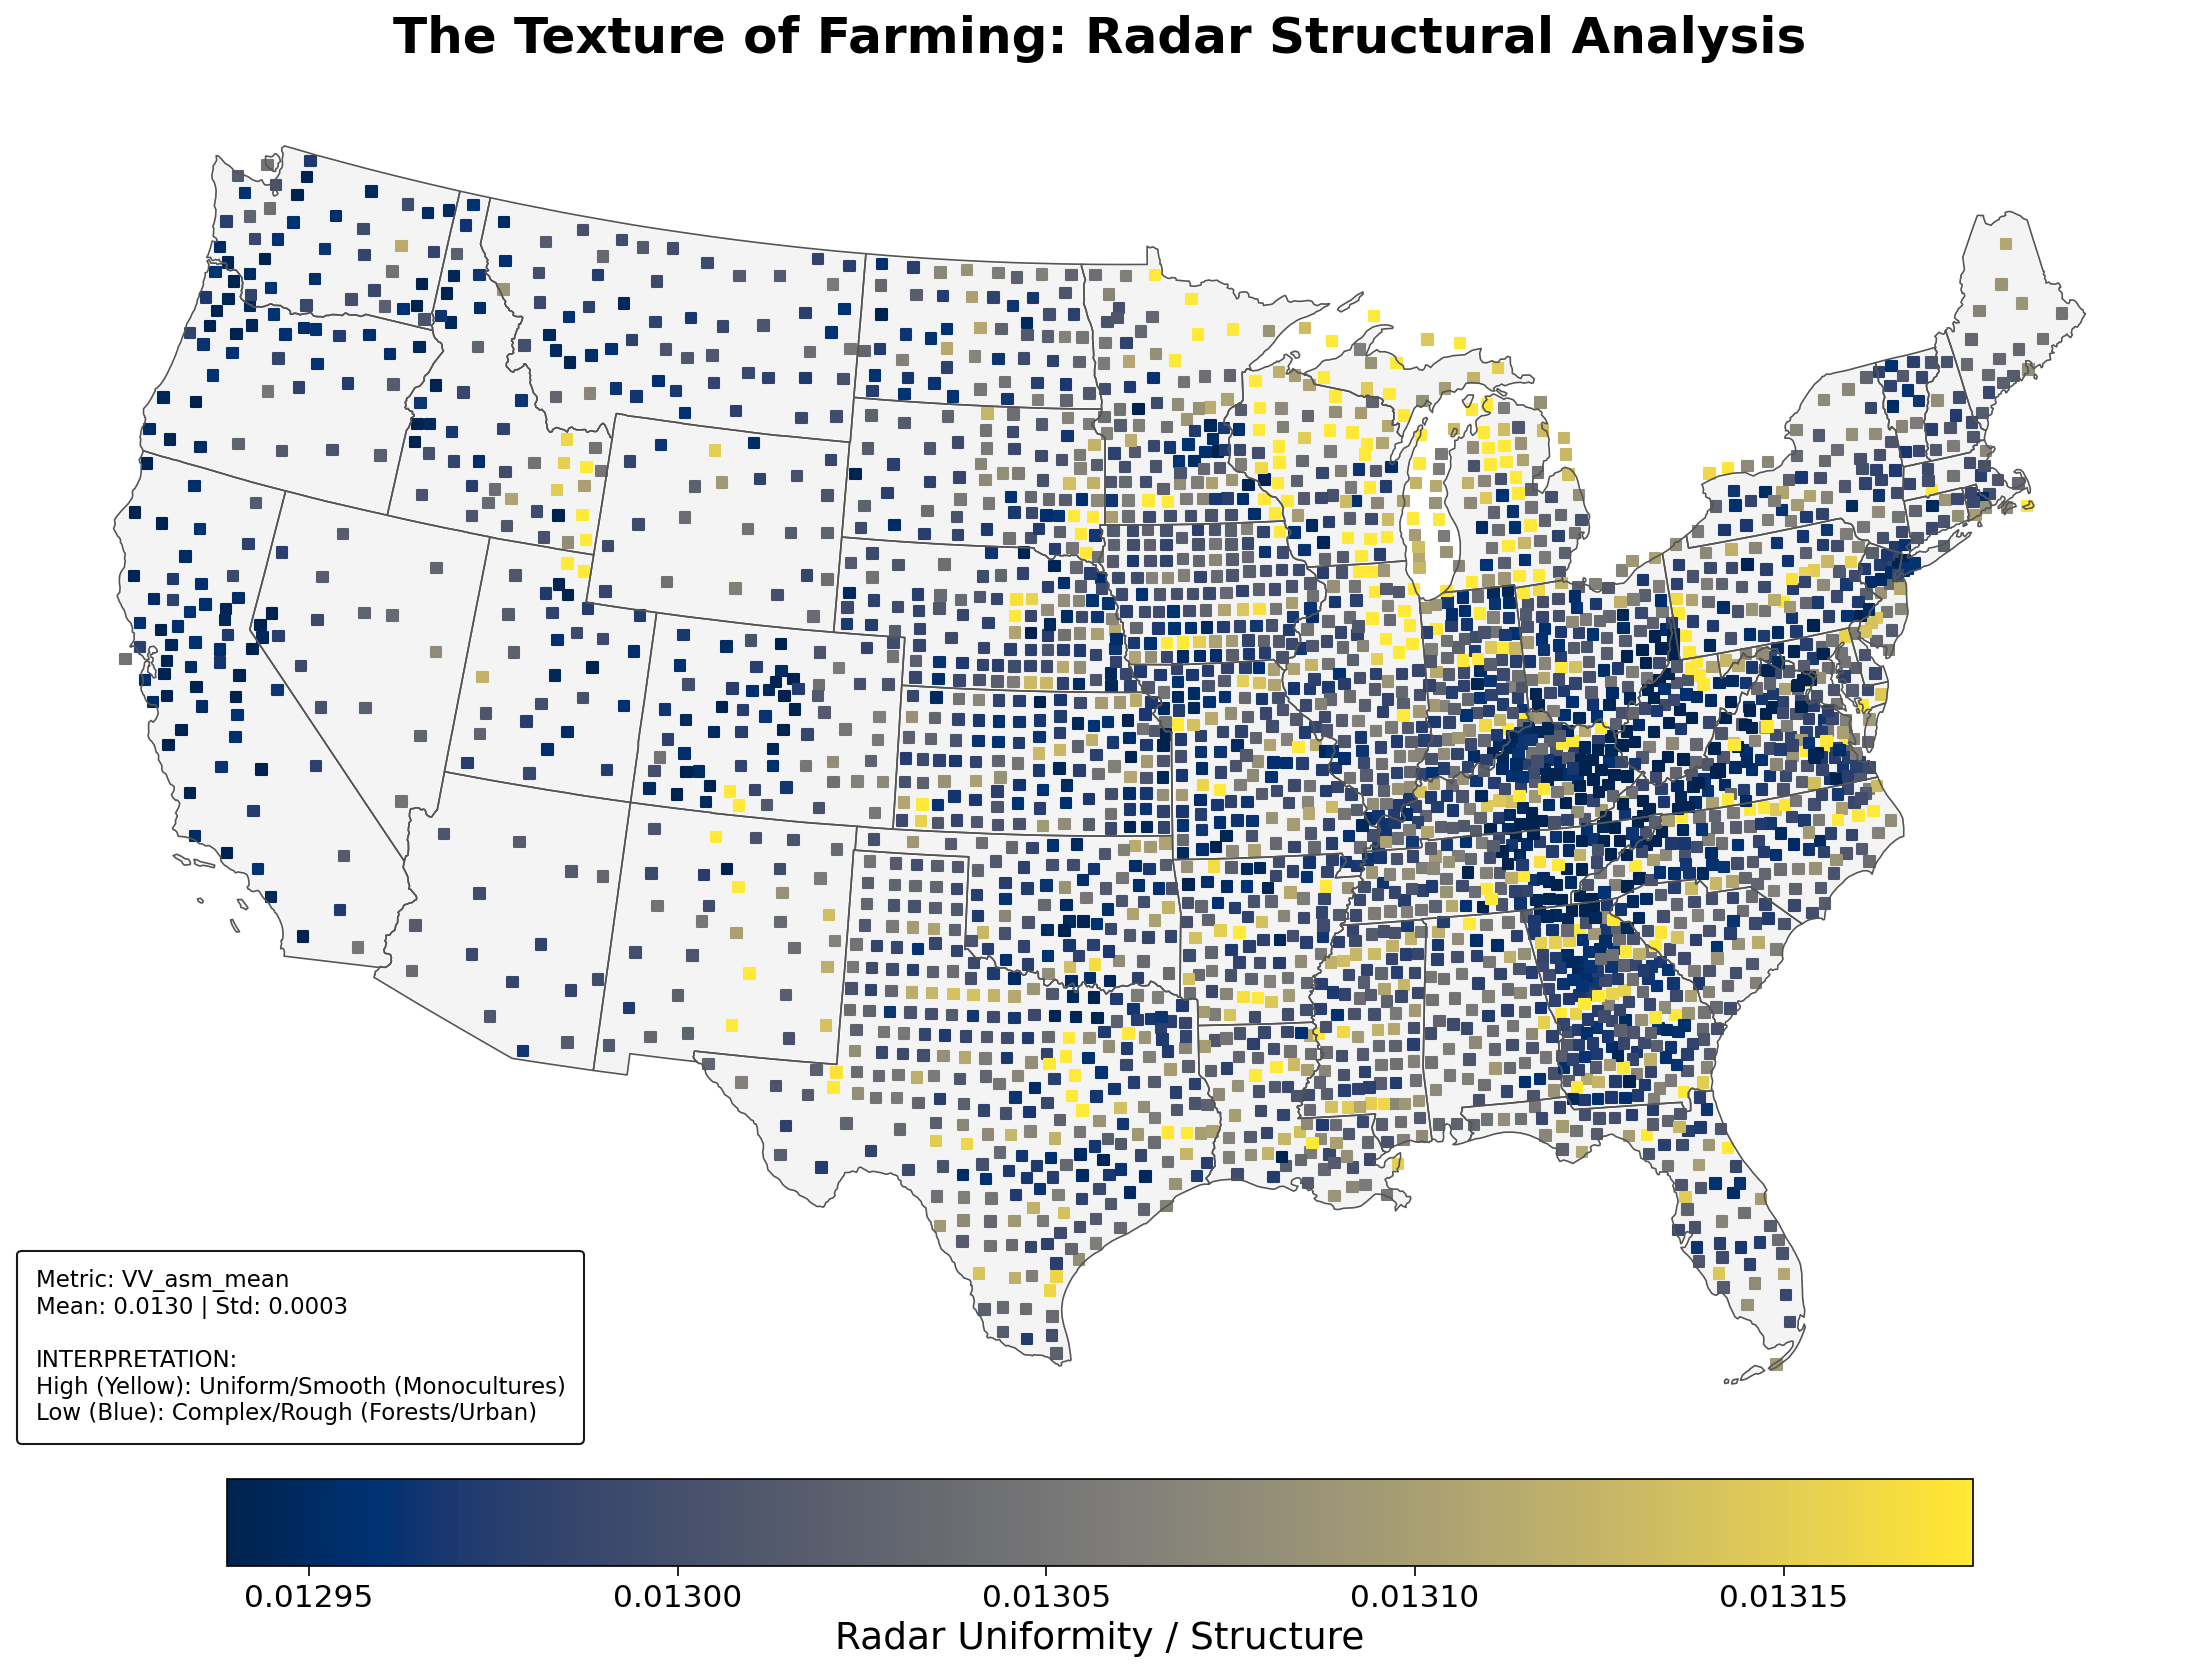

In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║   NEW VISUAL 1 (FIXED): THE TEXTURE OF FARMING (Sentinel-1 Analysis)     ║
# ╚══════════════════════════════════════════════════════════════════════════╝
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.offsetbox import AnchoredText

PLOT_DIR = '/content/drive/MyDrive/Agricultural_RS_LE_2025/plotting'
os.makedirs(PLOT_DIR, exist_ok=True)

def plot_texture_map(df):
    print("🎨 Generating New Visual 1: The 'Texture of Farming' Map...")

    # --- 1. SMART COLUMN SELECTION ---
    # Look for Sentinel-1 ASM (Angular Second Moment) or raw Backscatter (VV)
    texture_cols = [c for c in df.columns if 'asm' in c and 'mean' in c]

    if not texture_cols:
        print("   ⚠️ No ASM (Texture) columns found. Falling back to VV Mean (Roughness).")
        texture_cols = [c for c in df.columns if 'VV_mean' in c]

    if not texture_cols:
        print("   ❌ No Radar data found at all. Skipping.")
        return

    # Prefer 'VV' polarization
    target_col = next((c for c in texture_cols if 'VV' in c), texture_cols[0])
    print(f"   -> Mapping Metric: {target_col}")

    # --- 2. DATA PREP ---
    # Group by GEOID
    geo_df = df.groupby('GEOID')[['INTPTLAT', 'INTPTLON', target_col]].mean().reset_index()

    # Filter CONUS
    geo_df = geo_df[(geo_df['INTPTLAT'] > 24) & (geo_df['INTPTLAT'] < 50) &
                    (geo_df['INTPTLON'] > -125) & (geo_df['INTPTLON'] < -65)]

    # --- 3. PROJECTION ---
    geometry = [Point(xy) for xy in zip(geo_df['INTPTLON'], geo_df['INTPTLAT'])]
    gdf_points = gpd.GeoDataFrame(geo_df, geometry=geometry, crs="EPSG:4326").to_crs("EPSG:5070")

    # Background
    try:
        states = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip")
        states = states.cx[-125:-65, 24:50].to_crs("EPSG:5070")
    except: states = None

    # --- 4. SCALING ---
    vals = gdf_points[target_col].dropna()
    vmin = np.percentile(vals, 5)
    vmax = np.percentile(vals, 95)

    # --- 5. PLOTTING ---
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.set_axis_off()

    if states is not None:
        states.plot(ax=ax, facecolor='#f4f4f4', edgecolor='white', linewidth=1.5, zorder=1)
        states.plot(ax=ax, facecolor='none', edgecolor='#555555', linewidth=0.8, zorder=3)

    gdf_points.plot(
        column=target_col,
        ax=ax,
        cmap='cividis',
        markersize=25,
        marker='s',
        alpha=1.0,
        vmin=vmin, vmax=vmax,
        legend=True,
        legend_kwds={'label': 'Radar Uniformity / Structure', 'orientation': 'horizontal', 'pad': 0.02, 'shrink': 0.6},
        zorder=2
    )

    # --- FIX: SEPARATE STYLE ARGUMENTS ---
    stats_text = (f"Metric: {target_col}\n"
                  f"Mean: {vals.mean():.4f} | Std: {vals.std():.4f}\n\n"
                  f"INTERPRETATION:\n"
                  f"High (Yellow): Uniform/Smooth (Monocultures)\n"
                  f"Low (Blue): Complex/Rough (Forests/Urban)")

    at = AnchoredText(stats_text, prop=dict(size=11), frameon=True, loc='lower left')
    at.patch.set_boxstyle("round,pad=0.4,rounding_size=0.2") # Shape only
    at.patch.set_facecolor('white') # Color separately
    at.patch.set_alpha(0.9)
    ax.add_artist(at)

    ax.set_title('The Texture of Farming: Radar Structural Analysis', fontsize=24, fontweight='bold', pad=15)

    plt.tight_layout()
    save_path = os.path.join(PLOT_DIR, 'Visual_New1_Texture_Map.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"   ✅ Saved Texture Map to: {save_path}")
    plt.show()

# Run it
plot_texture_map(df)

🎨 Generating New Visual 2: The 'Flashiness' (Seasonality) Map...
   -> Mapping Seasonal Volatility using: NDVI_stdDev_modis_ndvi
   ✅ Saved Flashiness Map to: /content/drive/MyDrive/Agricultural_RS_LE_2025/plotting/Visual_New2_Flashiness_Map.png


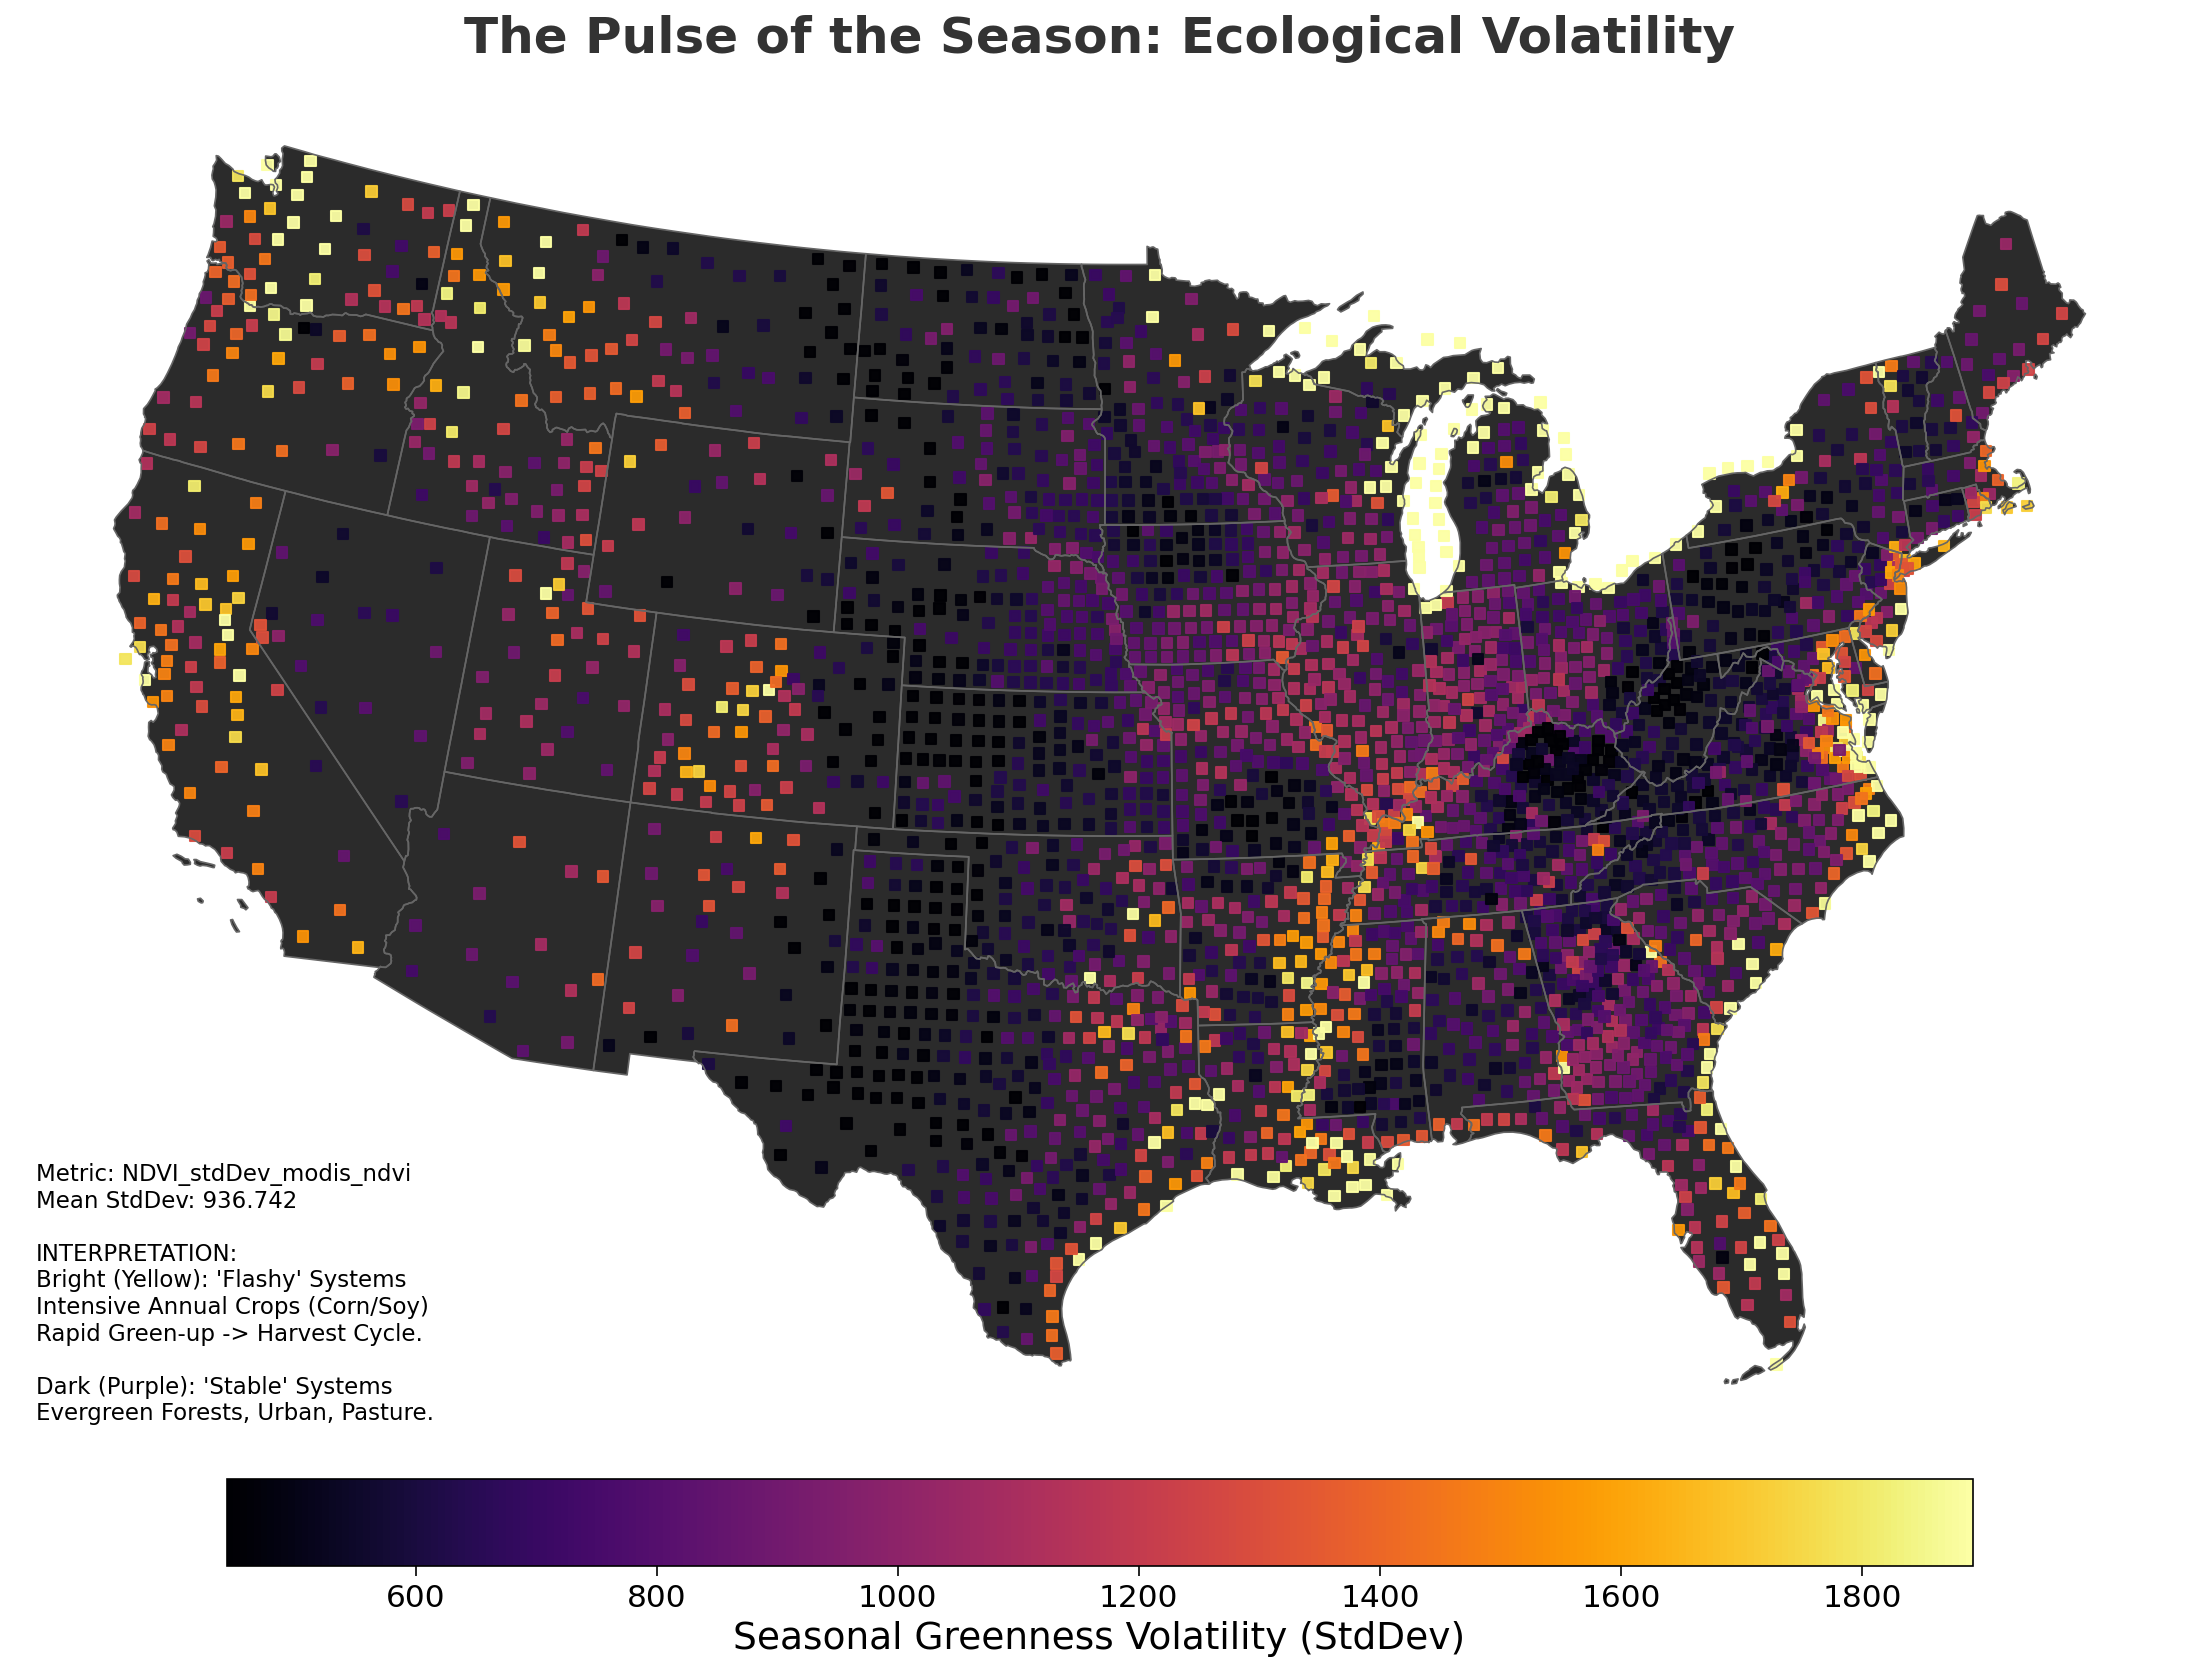

In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║   NEW VISUAL 2 (FIXED): THE "FLASHINESS" MAP (Seasonal Volatility)       ║
# ╚══════════════════════════════════════════════════════════════════════════╝
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.offsetbox import AnchoredText

PLOT_DIR = '/content/drive/MyDrive/Agricultural_RS_LE_2025/plotting'
os.makedirs(PLOT_DIR, exist_ok=True)

def plot_flashiness_map(df):
    print("🎨 Generating New Visual 2: The 'Flashiness' (Seasonality) Map...")

    # --- 1. SMART COLUMN SELECTION ---
    # We want the Standard Deviation of NDVI.
    # MODIS is best for this because it captures the full seasonal curve.

    # Look for 'NDVI' + 'stdDev'
    candidates = [c for c in df.columns if 'NDVI' in c and 'stdDev' in c]

    if not candidates:
        print("   ❌ No NDVI Standard Deviation columns found. Skipping.")
        return

    # Prioritize MODIS, then Sentinel-2, then Landsat
    target_col = next((c for c in candidates if 'modis' in c),
                 next((c for c in candidates if 's2' in c), candidates[0]))

    print(f"   -> Mapping Seasonal Volatility using: {target_col}")

    # --- 2. DATA PREP ---
    # Group by GEOID to get the average "Flashiness" of the county over the years
    geo_df = df.groupby('GEOID')[['INTPTLAT', 'INTPTLON', target_col]].mean().reset_index()

    # Filter CONUS
    geo_df = geo_df[(geo_df['INTPTLAT'] > 24) & (geo_df['INTPTLAT'] < 50) &
                    (geo_df['INTPTLON'] > -125) & (geo_df['INTPTLON'] < -65)]

    # --- 3. PROJECTION ---
    geometry = [Point(xy) for xy in zip(geo_df['INTPTLON'], geo_df['INTPTLAT'])]
    gdf_points = gpd.GeoDataFrame(geo_df, geometry=geometry, crs="EPSG:4326").to_crs("EPSG:5070")

    try:
        states = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip")
        states = states.cx[-125:-65, 24:50].to_crs("EPSG:5070")
    except: states = None

    # --- 4. SCALING ---
    # Stretch contrast to make the crop belts pop
    vals = gdf_points[target_col].dropna()
    vmin = np.percentile(vals, 5)
    vmax = np.percentile(vals, 95)

    # --- 5. PLOTTING ---
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.set_axis_off()

    # Background
    if states is not None:
        states.plot(ax=ax, facecolor='#2b2b2b', edgecolor='black', linewidth=0, zorder=1) # Dark background
        states.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=0.8, zorder=3)

    # The Data (Using 'inferno' - Fire palette)
    # Black/Purple = Stable, Orange/Yellow = Flashy/Explosive Growth
    gdf_points.plot(
        column=target_col,
        ax=ax,
        cmap='inferno',
        markersize=25,
        marker='s',
        alpha=0.95,
        vmin=vmin, vmax=vmax,
        legend=True,
        legend_kwds={'label': 'Seasonal Greenness Volatility (StdDev)', 'orientation': 'horizontal', 'pad': 0.02, 'shrink': 0.6},
        zorder=2
    )

    # Stats Box
    stats_text = (f"Metric: {target_col}\n"
                  f"Mean StdDev: {vals.mean():.3f}\n\n"
                  f"INTERPRETATION:\n"
                  f"Bright (Yellow): 'Flashy' Systems\n"
                  f"Intensive Annual Crops (Corn/Soy)\n"
                  f"Rapid Green-up -> Harvest Cycle.\n\n"
                  f"Dark (Purple): 'Stable' Systems\n"
                  f"Evergreen Forests, Urban, Pasture.")

    at = AnchoredText(stats_text, prop=dict(size=11, color='black'), frameon=False, loc='lower left')

    # --- THE FIX IS HERE ---
    # Set the shape (boxstyle) first
    at.patch.set_boxstyle("round,pad=0.4,rounding_size=0.2")
    # Then set the colors on the patch object directly
    at.patch.set_facecolor('#333333')
    at.patch.set_alpha(0.8)

    ax.add_artist(at)

    # Title (White text for dark mode look)
    ax.set_title('The Pulse of the Season: Ecological Volatility', fontsize=24, fontweight='bold', pad=15, color='#333333')

    plt.tight_layout()
    save_path = os.path.join(PLOT_DIR, 'Visual_New2_Flashiness_Map.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"   ✅ Saved Flashiness Map to: {save_path}")
    plt.show()

# Run it
plot_flashiness_map(df)


🎨 Generating Visual D & E: Spatial Analysis (with Boundaries)...
   -> Fetching US Census Shapefiles (this handles the boundaries)...
   -> Calculating Correlations for Visual E...


/tmp/ipython-input-1972158961.py:109: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_series = df.groupby('GEOID').apply(calc_corr)


   ✅ Saved Enhanced Visual E


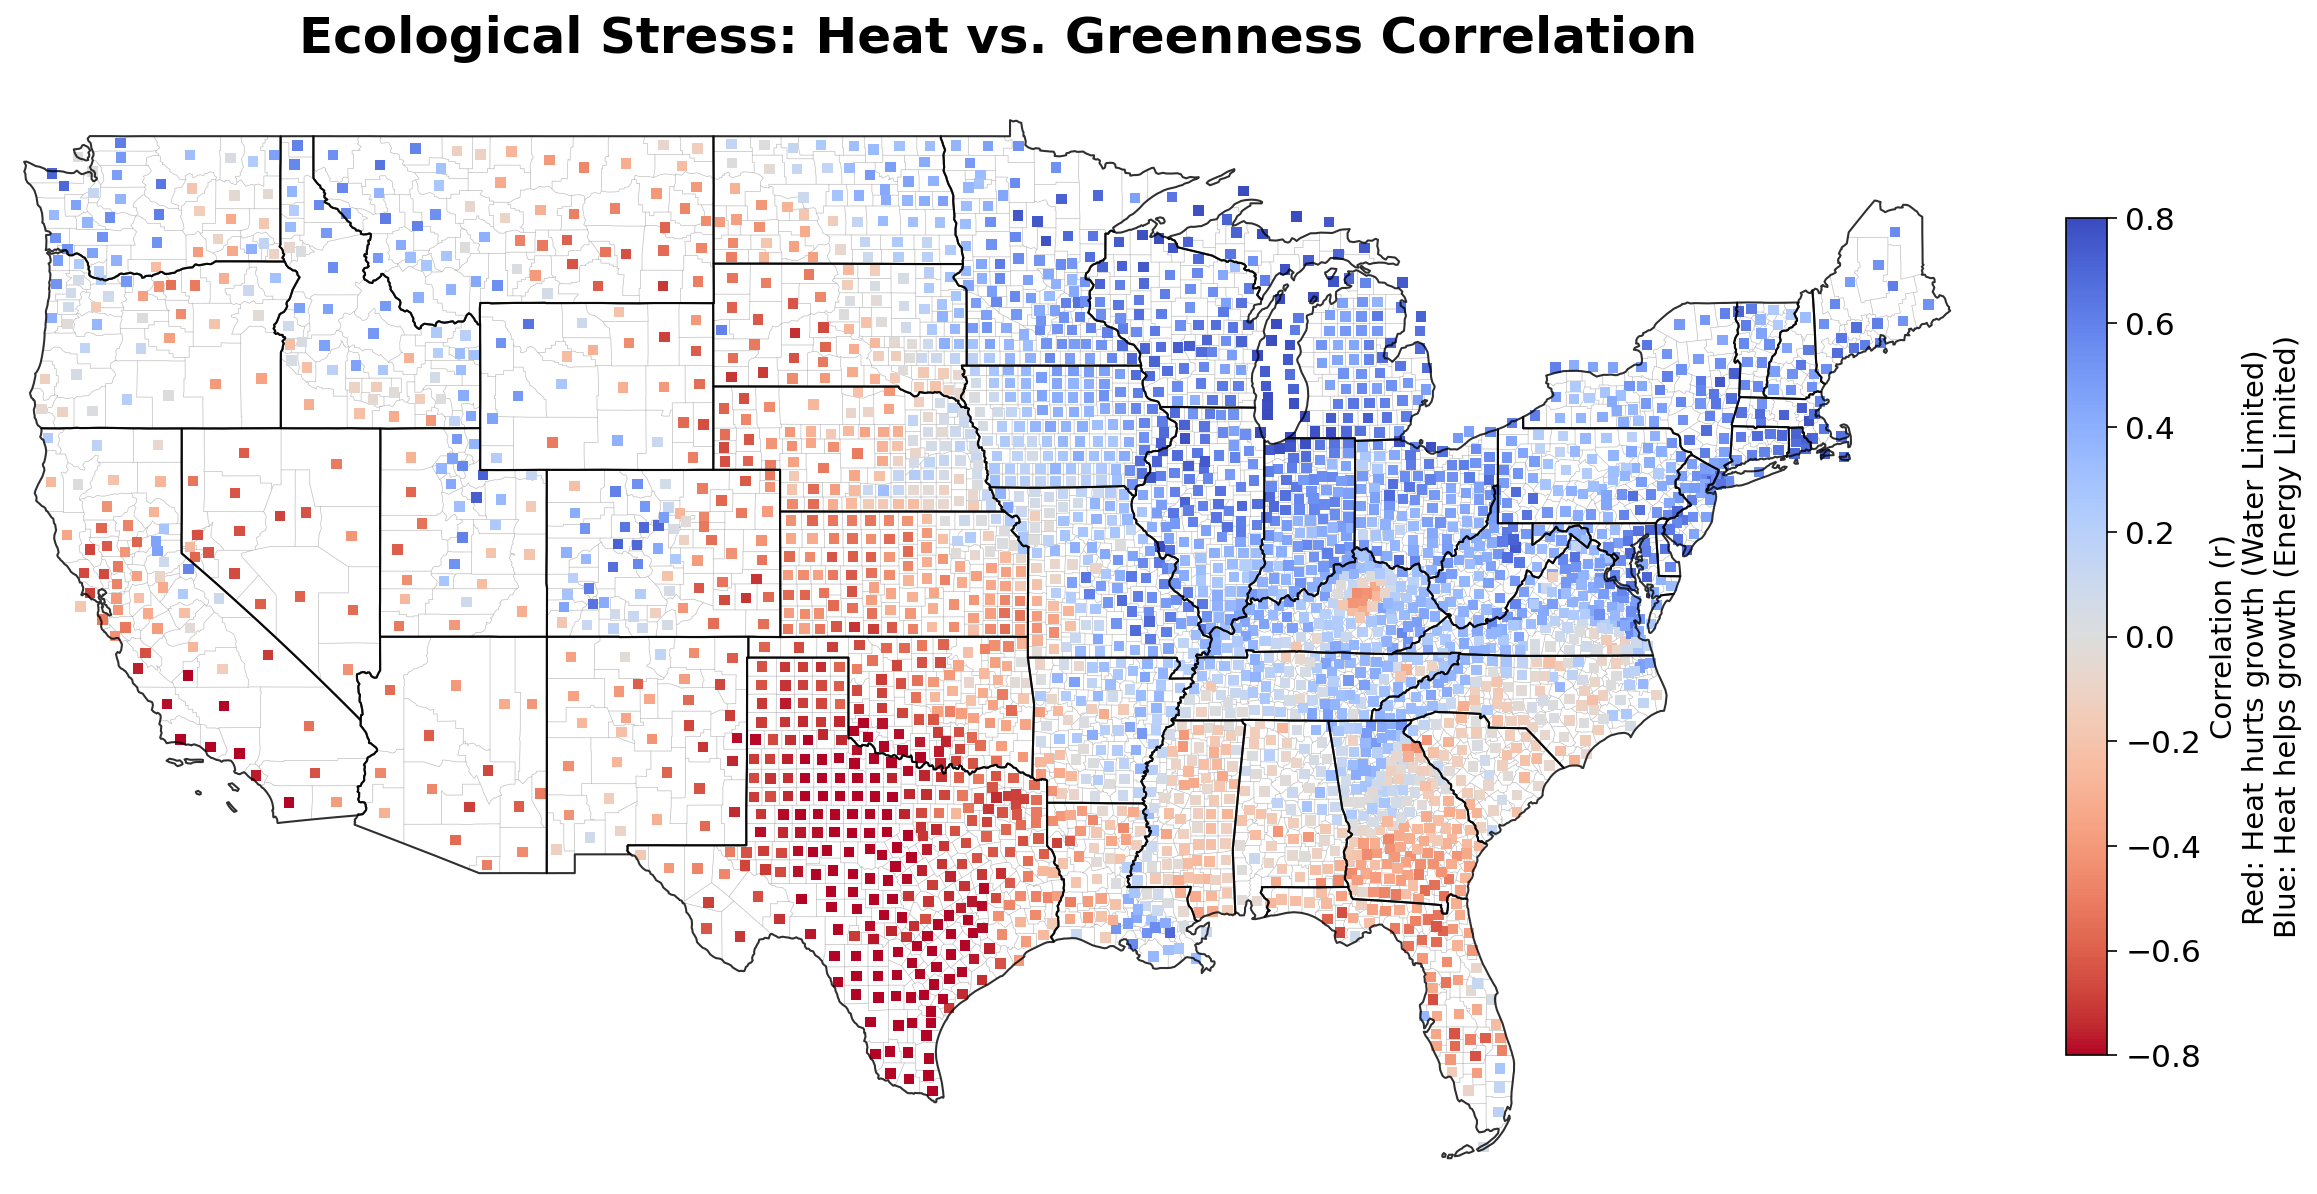

In [ ]:
# # Install geospatial libraries
# !pip install geopandas -q

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║   Phase 2.8 (IMPROVED): SPATIAL ANALYSIS WITH BOUNDARIES                 ║
# ╚══════════════════════════════════════════════════════════════════════════╝
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import Point

PLOT_DIR = '/content/drive/MyDrive/Agricultural_RS_LE_2025/plotting'
os.makedirs(PLOT_DIR, exist_ok=True)

def plot_spatial_complexity_enhanced(df):
    print("\n🎨 Generating Visual D & E: Spatial Analysis (with Boundaries)...")

    # --- 1. Data Prep ---
    if 'INTPTLAT' not in df.columns or 'INTPTLON' not in df.columns:
        print("   ❌ Missing coordinates. Skipping.")
        return

    # Create metadata frame (1 row per county)
    geo_df = df.groupby('GEOID')[['INTPTLAT', 'INTPTLON']].mean().reset_index()

    # Filter for Contiguous US for cleaner plotting
    geo_df = geo_df[
        (geo_df['INTPTLAT'] > 24) & (geo_df['INTPTLAT'] < 50) &
        (geo_df['INTPTLON'] > -125) & (geo_df['INTPTLON'] < -65)
    ]

    # --- 2. Load Boundaries (US Census) ---
    print("   -> Fetching US Census Shapefiles (this handles the boundaries)...")
    try:
        # 20m resolution is perfect for national maps (lightweight)
        states_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
        counties_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_20m.zip"

        us_states = gpd.read_file(states_url)
        us_counties = gpd.read_file(counties_url)

        # Filter boundaries to match our data extent (Contiguous US)
        us_states = us_states.cx[-125:-65, 24:50]
        us_counties = us_counties.cx[-125:-65, 24:50]

        boundaries_loaded = True
    except Exception as e:
        print(f"   ⚠️ Could not load shapefiles: {e}. Plotting points only.")
        boundaries_loaded = False

    # --- Helper to plot boundaries ---
    def add_boundaries(ax):
        if boundaries_loaded:
            # Plot Counties (Light/Thin)
            us_counties.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.3, alpha=0.3, zorder=1)
            # Plot States (Dark/Thick)
            us_states.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.0, alpha=0.8, zorder=3)

    # --- 3. VISUAL D: LANDSCAPE ENTROPY ---
    if 'landscape_diversity_entropy' in df.columns:
        entropy_scores = df.groupby('GEOID')['landscape_diversity_entropy'].mean()
        map_data_d = geo_df.merge(entropy_scores, on='GEOID')

        fig, ax = plt.subplots(figsize=(18, 12)) # Larger figure for map detail

        add_boundaries(ax) # Draw lines first

        # Scatter points (Counties)
        scatter = ax.scatter(
            map_data_d['INTPTLON'],
            map_data_d['INTPTLAT'],
            c=map_data_d['landscape_diversity_entropy'],
            cmap='magma',
            s=25,          # Slightly larger to fill shape
            alpha=1.0,     # Solid color
            marker='s',    # Square marker fills gaps better than circles
            edgecolors='none',
            zorder=2       # Between counties and states
        )

        ax.set_title('Geography of Complexity: Landscape Diversity', pad=20, fontsize=24)
        ax.set_xlim(-125, -66)
        ax.set_ylim(24, 50)
        ax.axis('off')

        cbar = plt.colorbar(scatter, ax=ax, fraction=0.02, pad=0.04)
        cbar.set_label('Shannon Entropy (High = Diverse)', fontsize=14)

        plt.savefig(os.path.join(PLOT_DIR, 'Visual_D_Entropy_Map_Enhanced.png'), dpi=300, bbox_inches='tight')
        print("   ✅ Saved Enhanced Visual D")
        plt.show()

    # --- 4. VISUAL E: LST-NDVI CORRELATION ---
    print("   -> Calculating Correlations for Visual E...")
    lst_col = next((c for c in df.columns if 'LST_Day' in c and 'mean' in c), None)
    ndvi_col = next((c for c in df.columns if 'NDVI' in c and 'modis' in c and 'mean' in c), None)

    if lst_col and ndvi_col:
        # Quick correlation calculation
        # (Re-using previous logic but optimized for display)
        def calc_corr(x):
            v = x[[lst_col, ndvi_col]].dropna()
            return v[lst_col].corr(v[ndvi_col]) if len(v) > 5 else np.nan

        # Only calc if not already in df (to save time if re-running)
        if 'lst_ndvi_corr' not in df.columns:
             corr_series = df.groupby('GEOID').apply(calc_corr)
             corr_series.name = 'lst_ndvi_corr'
             map_data_e = geo_df.merge(corr_series, on='GEOID')
        else:
             # If you ran the previous block, it might already be merged
             # We'll just re-merge to be safe
             corr_series = df.groupby('GEOID').apply(calc_corr)
             corr_series.name = 'lst_ndvi_corr'
             map_data_e = geo_df.merge(corr_series, on='GEOID')

        fig, ax = plt.subplots(figsize=(18, 12))

        add_boundaries(ax)

        scatter = ax.scatter(
            map_data_e['INTPTLON'],
            map_data_e['INTPTLAT'],
            c=map_data_e['lst_ndvi_corr'],
            cmap='coolwarm_r',
            s=25,
            marker='s',
            alpha=1.0,
            edgecolors='none',
            vmin=-0.8, vmax=0.8,
            zorder=2
        )

        ax.set_title('Ecological Stress: Heat vs. Greenness Correlation', pad=20, fontsize=24)
        ax.set_xlim(-125, -66)
        ax.set_ylim(24, 50)
        ax.axis('off')

        cbar = plt.colorbar(scatter, ax=ax, fraction=0.02, pad=0.04)
        cbar.set_label('Correlation (r)\nRed: Heat hurts growth (Water Limited)\nBlue: Heat helps growth (Energy Limited)', fontsize=14)

        plt.savefig(os.path.join(PLOT_DIR, 'Visual_E_Climate_Map_Enhanced.png'), dpi=300, bbox_inches='tight')
        print("   ✅ Saved Enhanced Visual E")
        plt.show()

# Run the enhanced plotter
plot_spatial_complexity_enhanced(df)

#USDA Crops data set exploder (not used, but useful code)

In [14]:
# =====================================================
#  OPERATION PURE GOLD: Direct USDA Histogram Extraction
#  Goal: Bypass the corrupted merged file and mine data directly from source files.
# =====================================================

import pandas as pd
import numpy as np
import os
import ast
import glob

# --- CONFIGURATION ---
# Path where your raw 'cropland_usda_*.csv' files live
SOURCE_PATH = '/content/drive/MyDrive/Agricultural_RS_LE_2025'
OUTPUT_PATH = os.path.join(SOURCE_PATH, 'master csv', 'USDA_Crops_Exploded.csv')

# USDA Crop Mapping (The Decoder Ring)
CROP_MAP = {
    '1': 'Corn', '2': 'Cotton', '3': 'Rice', '4': 'Sorghum', '5': 'Soybeans',
    '6': 'Sunflower', '10': 'Peanuts', '11': 'Tobacco', '12': 'Sweet Corn',
    '21': 'Barley', '23': 'Spring Wheat', '24': 'Winter Wheat',
    '28': 'Oats', '29': 'Millet', '36': 'Alfalfa', '37': 'Other Hay',
    '44': 'Other Crops', '59': 'Sod/Grass Seed', '61': 'Fallow',
    '111': 'Open Water', '121': 'Developed_Open', '122': 'Developed_Low',
    '123': 'Developed_Med', '124': 'Developed_High',
    '141': 'Forest_Deciduous', '142': 'Forest_Evergreen', '143': 'Forest_Mixed',
    '152': 'Shrubland', '176': 'Grassland', '190': 'Wetlands_Woody', '195': 'Wetlands_Herbaceous'
}

def parse_gee_dict(val):
    """Parses GEE strings like {1=500, 2=300} into Python dicts."""
    if pd.isna(val) or str(val).strip() in ["", "{}", "nan"]:
        return {}
    try:
        # Standard GEE format uses '='
        val = str(val).replace('=', ':')
        return ast.literal_eval(val)
    except:
        return {}

def extract_gold():
    print("⛏️  Starting Operation Pure Gold...")

    # 1. Find all USDA Cropland files
    search_pattern = os.path.join(SOURCE_PATH, 'cropland_usda_*.csv')
    files = glob.glob(search_pattern)

    if not files:
        print("❌ No cropland_usda files found! Check your SOURCE_PATH.")
        return

    print(f"   -> Found {len(files)} raw USDA files. Processing...")

    all_chunks = []

    for file in files:
        try:
            # Load only essential columns
            df = pd.read_csv(file, on_bad_lines='skip')

            # Basic cleanup
            if 'system:index' in df.columns: df = df.drop(columns=['system:index', '.geo'])

            # Ensure GEOID exists
            if 'GEOID' not in df.columns and 'STATEFP' in df.columns:
                df['GEOID'] = df['STATEFP'].astype(str).str.zfill(2) + \
                              df['COUNTYFP'].astype(str).str.zfill(3)

            if 'GEOID' not in df.columns: continue # Skip if no ID

            # Ensure Year exists
            if 'year' not in df.columns:
                # Extract year from filename (e.g., cropland_usda_01_2011.csv)
                parts = os.path.basename(file).split('_')
                if parts[-1].replace('.csv','').isdigit():
                    df['year'] = int(parts[-1].replace('.csv',''))

            # --- THE GOLD MINING STEP ---
            if 'histogram' in df.columns:
                # 1. Parse
                parsed_series = df['histogram'].apply(parse_gee_dict)

                # 2. Explode
                exploded = pd.json_normalize(parsed_series)
                exploded.index = df.index

                # 3. Rename with Crop Names
                new_cols = {}
                for col in exploded.columns:
                    # col is '1', '5', etc.
                    crop_name = CROP_MAP.get(col, f"Class_{col}")
                    new_cols[col] = f"Crop_{crop_name}_px"

                exploded = exploded.rename(columns=new_cols)
                exploded = exploded.fillna(0)

                # 4. Normalize to Percentages (Optional but recommended)
                row_sums = exploded.sum(axis=1)
                row_sums[row_sums == 0] = 1
                exploded_pct = exploded.div(row_sums, axis=0)
                exploded_pct.columns = [c.replace('_px', '_pct') for c in exploded.columns]

                # 5. Join Metadata + Exploded Crops
                # Keep only GEOID, year, and the new crop columns
                clean_chunk = pd.concat([df[['GEOID', 'year']], exploded_pct], axis=1)
                all_chunks.append(clean_chunk)

        except Exception as e:
            print(f"   ⚠️ Error reading {os.path.basename(file)}: {e}")

    # 2. Merge all years/states
    if all_chunks:
        print("   🔗 Concatenating all processed chunks...")
        master_df = pd.concat(all_chunks, ignore_index=True)

        # Fill NaNs (if a specific crop didn't exist in a specific file)
        master_df = master_df.fillna(0)

        # Sort
        master_df = master_df.sort_values(['GEOID', 'year'])

        # Save
        print(f"   💾 Saving Pure Gold Dataset to: {OUTPUT_PATH}")
        master_df.to_csv(OUTPUT_PATH, index=False)
        print(f"   ✅ Success! Saved {len(master_df)} rows with {len(master_df.columns)} crop features.")
        print("   (You can now merge this with your Life Expectancy target!)")
    else:
        print("   ❌ No valid data extracted.")

if __name__ == "__main__":
    extract_gold()

⛏️  Starting Operation Pure Gold...
   -> Found 1096 raw USDA files. Processing...
   🔗 Concatenating all processed chunks...
   💾 Saving Pure Gold Dataset to: /content/drive/MyDrive/Agricultural_RS_LE_2025/master csv/USDA_Crops_Exploded.csv
   ✅ Success! Saved 73847 rows with 135 crop features.
   (You can now merge this with your Life Expectancy target!)


In [7]:
import pandas as pd

# Path to the file
file_path_2 = '/content/drive/MyDrive/Agricultural_RS_LE_2025/master csv/life_ex_final_df.csv'

# Load the CSV file into a pandas DataFrame
df_2 = pd.read_csv(file_path_2, low_memory=False)

print("First 5 rows of final_dataset_103_features 1.csv (df_2):")
display(df_2.head())

print("\nColumn information and data types for final_dataset_103_features 1.csv (df_2):")
df_2.info()

First 5 rows of final_dataset_103_features 1.csv (df_2):


location_name  fips  year  MeanLifeExpectency
0  Autauga County (Alabama)  1001  2016           75.877864
1  Baldwin County (Alabama)  1003  2016           77.913070
2  Barbour County (Alabama)  1005  2016           74.919864
3     Bibb County (Alabama)  1007  2016           73.667331
4   Blount County (Alabama)  1009  2016           75.035220


Column information and data types for final_dataset_103_features 1.csv (df_2):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62540 entries, 0 to 62539
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   location_name       62540 non-null  object 
 1   fips                62540 non-null  int64  
 2   year                62540 non-null  int64  
 3   MeanLifeExpectency  62540 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.9+ MB


#FINAL CODE USED FOR MERGE Core data processing code for generating individual master datasets

# This is the final merge code that has been used for ML

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import re
import ast
from tqdm import tqdm

# ==========================================
# 1. CONFIGURATION & CLASS MAPPINGS
# ==========================================
SOURCE_DIR = '/content/drive/MyDrive/Agricultural_RS_LE_2025'
DEST_DIR = os.path.join(SOURCE_DIR, 'master csv')

if not os.path.exists(DEST_DIR):
    os.makedirs(DEST_DIR)

# --- CLASS DEFINITIONS (The Decoder Rings) ---
CLASS_MAPS = {
    'Cropland_USDA': {
        '1': 'Corn', '2': 'Cotton', '3': 'Rice', '4': 'Sorghum', '5': 'Soybeans',
        '6': 'Sunflower', '10': 'Peanuts', '11': 'Tobacco', '12': 'Sweet Corn',
        '21': 'Barley', '23': 'Spring Wheat', '24': 'Winter Wheat', '28': 'Oats',
        '36': 'Alfalfa', '37': 'Other Hay', '44': 'Other Crops', '61': 'Fallow',
        '111': 'Open Water', '121': 'Dev_Open', '122': 'Dev_Low',
        '123': 'Dev_Med', '124': 'Dev_High', '141': 'Forest_Deciduous',
        '142': 'Forest_Evergreen', '143': 'Forest_Mixed', '152': 'Shrubland',
        '176': 'Grassland', '190': 'Wetlands_Woody', '195': 'Wetlands_Herbaceous'
    },
    'Dynamic_World': {
        '0': 'Water', '1': 'Trees', '2': 'Grass', '3': 'FloodedVeg',
        '4': 'Crops', '5': 'ShrubScrub', '6': 'Built', '7': 'Bare', '8': 'SnowIce'
    },
    'Water_JRC': {
        '1': 'NotWater', '2': 'Seasonal', '3': 'Permanent'
    }
}

# ==========================================
# 2. PARSING ENGINE
# ==========================================
def parse_histogram_str(text):
    """Robustly parses string '{k=v, ...}' or JSON into a python dict."""
    if pd.isna(text) or str(text).strip() in ['', '{}', 'nan']:
        return {}

    # 1. Fast Path: Standard JSON
    if ':' in str(text) and '{' in str(text):
        try:
            return ast.literal_eval(str(text))
        except: pass

    # 2. Robust Path: GEE "key=value" format
    clean = str(text).replace('{', '').replace('}', '')
    if not clean: return {}

    # Regex handles scientific notation (e.g. 1.2e-5)
    pattern = r'([\d\w\.\-\+]+)\s*=\s*([\d\w\.\-\+eE]+)'
    matches = re.findall(pattern, clean)

    data = {}
    for k, v in matches:
        try:
            # Clean Key: Convert "1.0" -> "1" (Int) for cleaner mapping
            key_num = float(k)
            key = str(int(key_num)) if key_num.is_integer() else str(k)

            data[key] = float(v)
        except: continue
    return data

# ==========================================
# 3. GENERIC PROCESSING (One Code to Rule Them All)
# ==========================================
def process_sensor_master(sensor_name, file_pattern):
    print(f"\n🚜 Processing {sensor_name.upper()}...")

    files = glob.glob(os.path.join(SOURCE_DIR, file_pattern))
    if not files:
        print(f"   ⚠️ No files found for {sensor_name}")
        return

    all_rows = []

    # Get specific mapping for this sensor (if any)
    sensor_map = CLASS_MAPS.get(sensor_name, {})

    for f in tqdm(files, desc=f"Reading {sensor_name}"):
        try:
            # 1. Load File
            df = pd.read_csv(f, on_bad_lines='skip', low_memory=False)

            # 2. Metadata Cleanup
            if 'system:index' in df.columns:
                df = df.drop(columns=['system:index', '.geo', 'Unnamed: 0'], errors='ignore')

            # Ensure GEOID is padded string
            if 'GEOID' not in df.columns and 'STATEFP' in df.columns:
                 df['GEOID'] = df['STATEFP'].astype(str).str.zfill(2) + \
                               df['COUNTYFP'].astype(str).str.zfill(3)

            # Recover Year if missing
            if 'year' not in df.columns:
                parts = os.path.basename(f).replace('.csv','').split('_')
                if parts[-1].isdigit() and len(parts[-1]) == 4:
                    df['year'] = int(parts[-1])

            # 3. HISTOGRAM EXPLOSION
            # Find any column ending in 'histogram'
            hist_cols = [c for c in df.columns if 'histogram' in c.lower()]

            if hist_cols:
                for h_col in hist_cols:
                    # Skip Dynamic World "Confidence" histograms (Probability noise)
                    # We only want the Class Counts (Integer keys)
                    sample = df[h_col].dropna().iloc[0] if not df[h_col].dropna().empty else ""
                    if '0.1' in str(sample) and sensor_name == 'Dynamic_World':
                        df = df.drop(columns=[h_col]) # Drop noise
                        continue

                    # Parse
                    parsed_series = df[h_col].apply(parse_histogram_str)

                    # Explode
                    exploded = pd.json_normalize(parsed_series)
                    exploded.index = df.index

                    # --- INTELLIGENT RENAMING ---
                    new_names = {}
                    for col in exploded.columns:
                        # col is likely "1", "5", etc.
                        if col in sensor_map:
                            # Map "1" -> "Corn"
                            name_suffix = sensor_map[col]
                        else:
                            # Fallback "Class_1"
                            name_suffix = f"Class_{col}"

                        new_names[col] = f"{sensor_name}_{name_suffix}_pct"

                    exploded = exploded.rename(columns=new_names)

                    # --- CRITICAL: ZERO FILLING (LOCAL ONLY) ---
                    # Only fill 0s for crops *within this file*.
                    # If this file exists, we know missing keys = 0 pixels.
                    exploded = exploded.fillna(0)

                    # Normalize to Percentage
                    row_sums = exploded.sum(axis=1)
                    row_sums[row_sums == 0] = 1
                    exploded = exploded.div(row_sums, axis=0)

                    # Merge & Clean
                    df = pd.concat([df, exploded], axis=1)
                    df = df.drop(columns=[h_col])

            all_rows.append(df)

        except Exception as e:
            pass

    # 4. GRAND MERGE (PRESERVING NANs)
    if all_rows:
        # Stack all chunks
        master_df = pd.concat(all_rows, axis=0, ignore_index=True, sort=False)

        # --- CRITICAL: VACANT CELL HANDLING ---
        # We do NOT run master_df.fillna(0) globally.
        # This ensures that if a Year/County didn't exist in the input files,
        # its columns remain NaN (Vacant), indicating "No Data Collected".

        # Final ID Polish
        if 'GEOID' in master_df.columns:
            master_df['GEOID'] = master_df['GEOID'].astype(str).str.split('.').str[0].str.zfill(5)

        # Sort
        sort_cols = [c for c in ['GEOID', 'year'] if c in master_df.columns]
        if sort_cols:
            master_df = master_df.sort_values(sort_cols)

        # Save
        out_path = os.path.join(DEST_DIR, f'MASTER_{sensor_name}_vFinal.csv')
        master_df.to_csv(out_path, index=False)
        print(f"✅ Saved: {out_path}")
        print(f"   Shape: {master_df.shape} (Rows, Cols)")

        # Audit
        if 'year' in master_df.columns:
            years = sorted(master_df['year'].dropna().unique().astype(int))
            print(f"   Years: {min(years)} to {max(years)}")

# ==========================================
# 4. EXECUTION LOOP
# ==========================================
if __name__ == "__main__":
    # Define datasets to process
    DATASETS = {
        'Cropland_USDA': 'cropland_usda_*.csv',
        'Dynamic_World': 'dynamic_world_*.csv',
        'Water_JRC':     'water_jrc_*.csv',
        'Landsat':       'landsat89_*.csv',
        'Sentinel2':     's2_*.csv',
        'MODIS_NDVI':    'modis_ndvi_*.csv',
        'MODIS_LST':     'modis_lst_*.csv',
        'DEM':           'dem_*.csv',
        'Soil':          'soil_texture_*.csv'
    }

    for name, pattern in DATASETS.items():
        process_sensor_master(name, pattern)


🚜 Processing CROPLAND_USDA...


Reading Cropland_USDA: 100%|██████████| 1096/1096 [01:47<00:00, 10.24it/s] 


✅ Saved: /content/drive/MyDrive/Agricultural_RS_LE_2025/master csv/MASTER_Cropland_USDA_vFinal.csv
   Shape: (73847, 153) (Rows, Cols)
   Years: 2000 to 2024

🚜 Processing DYNAMIC_WORLD...


Reading Dynamic_World: 100%|██████████| 104/104 [02:23<00:00,  1.38s/it]


✅ Saved: /content/drive/MyDrive/Agricultural_RS_LE_2025/master csv/MASTER_Dynamic_World_vFinal.csv
   Shape: (1348, 36) (Rows, Cols)
   Years: 2015 to 2024

🚜 Processing WATER_JRC...


Reading Water_JRC: 100%|██████████| 1078/1078 [00:08<00:00, 124.71it/s]


✅ Saved: /content/drive/MyDrive/Agricultural_RS_LE_2025/master csv/MASTER_Water_JRC_vFinal.csv
   Shape: (68376, 24) (Rows, Cols)
   Years: 2000 to 2021

🚜 Processing LANDSAT...


Reading Landsat: 100%|██████████| 588/588 [00:05<00:00, 111.61it/s]


✅ Saved: /content/drive/MyDrive/Agricultural_RS_LE_2025/master csv/MASTER_Landsat_vFinal.csv
   Shape: (37296, 102) (Rows, Cols)
   Years: 2013 to 2024

🚜 Processing SENTINEL2...


Reading Sentinel2: 100%|██████████| 229/229 [00:02<00:00, 108.27it/s]


✅ Saved: /content/drive/MyDrive/Agricultural_RS_LE_2025/master csv/MASTER_Sentinel2_vFinal.csv
   Shape: (12002, 102) (Rows, Cols)
   Years: 2015 to 2024

🚜 Processing MODIS_NDVI...


Reading MODIS_NDVI: 100%|██████████| 1225/1225 [00:05<00:00, 212.93it/s]


✅ Saved: /content/drive/MyDrive/Agricultural_RS_LE_2025/master csv/MASTER_MODIS_NDVI_vFinal.csv
   Shape: (77700, 32) (Rows, Cols)
   Years: 2000 to 2024

🚜 Processing MODIS_LST...


Reading MODIS_LST: 100%|██████████| 1225/1225 [00:05<00:00, 205.01it/s]


✅ Saved: /content/drive/MyDrive/Agricultural_RS_LE_2025/master csv/MASTER_MODIS_LST_vFinal.csv
   Shape: (77700, 32) (Rows, Cols)
   Years: 2000 to 2024

🚜 Processing DEM...


Reading DEM: 100%|██████████| 45/45 [00:00<00:00, 182.34it/s]


✅ Saved: /content/drive/MyDrive/Agricultural_RS_LE_2025/master csv/MASTER_DEM_vFinal.csv
   Shape: (2782, 24) (Rows, Cols)

🚜 Processing SOIL...


Reading Soil: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]


✅ Saved: /content/drive/MyDrive/Agricultural_RS_LE_2025/master csv/MASTER_Soil_vFinal.csv
   Shape: (3108, 24) (Rows, Cols)


#FINAL CODE USED FOR MERGE  S1 data is missed in the above processing so doing it here independently

In [2]:
import pandas as pd
import numpy as np
import glob
import os
import re
from tqdm import tqdm

# ==========================================
# 1. CONFIGURATION
# ==========================================
SOURCE_DIR = '/content/drive/MyDrive/Agricultural_RS_LE_2025'
DEST_DIR = os.path.join(SOURCE_DIR, 'master csv')

if not os.path.exists(DEST_DIR):
    os.makedirs(DEST_DIR)

# ==========================================
# 2. SENTINEL-1 PROCESSOR
# ==========================================
def process_sentinel1_master():
    print(f"\n🛰️  Processing SENTINEL-1 (SAR Structure)...")

    # Pattern to match your files (e.g., s1_01_2015.csv)
    files = glob.glob(os.path.join(SOURCE_DIR, 's1_*.csv'))

    if not files:
        print("   ⚠️ No Sentinel-1 files found (checked 's1_*.csv').")
        return

    print(f"   -> Found {len(files)} file chunks. Stacking...")

    all_rows = []

    for f in tqdm(files, desc="Reading S1"):
        try:
            # 1. Load File (Low memory mode false to prevent type errors)
            df = pd.read_csv(f, on_bad_lines='skip', low_memory=False)

            # 2. Metadata Cleanup
            # Drop GEE system columns if they exist
            cols_to_drop = ['system:index', '.geo', 'Unnamed: 0']
            df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

            # 3. Ensure GEOID is correct
            # If GEOID is missing, try to build it from State/County FP
            if 'GEOID' not in df.columns and 'STATEFP' in df.columns:
                 df['GEOID'] = df['STATEFP'].astype(str).str.zfill(2) + \
                               df['COUNTYFP'].astype(str).str.zfill(3)

            # 4. Recover Year from Filename
            # Your naming convention is 's1_STATE_YEAR.csv'
            if 'year' not in df.columns:
                filename = os.path.basename(f)
                parts = filename.replace('.csv', '').split('_')
                # Check the last part for a 4-digit year
                if parts[-1].isdigit() and len(parts[-1]) == 4:
                    df['year'] = int(parts[-1])

            # 5. Add to Stack
            all_rows.append(df)

        except Exception as e:
            # Silent fail for corrupt individual files, just skip them
            pass

    # 3. GRAND MERGE
    if all_rows:
        # Concatenate all years/states
        master_df = pd.concat(all_rows, axis=0, ignore_index=True, sort=False)

        # Final ID Polish (Ensure 5-digit string '01001')
        if 'GEOID' in master_df.columns:
            master_df['GEOID'] = master_df['GEOID'].astype(str).str.split('.').str[0].str.zfill(5)

        # Sort by ID and Year
        sort_cols = [c for c in ['GEOID', 'year'] if c in master_df.columns]
        if sort_cols:
            master_df = master_df.sort_values(sort_cols)

        # 4. Save
        out_path = os.path.join(DEST_DIR, 'MASTER_Sentinel1_vFinal.csv')
        master_df.to_csv(out_path, index=False)

        print(f"✅ Saved: {out_path}")
        print(f"   Shape: {master_df.shape} (Rows, Cols)")

        # Validation Stats
        if 'year' in master_df.columns:
            years = sorted(master_df['year'].dropna().unique().astype(int))
            print(f"   Years Covered: {min(years)} to {max(years)}")
            print(f"   Columns Included: {len(master_df.columns)}")

if __name__ == "__main__":
    process_sentinel1_master()


🛰️  Processing SENTINEL-1 (SAR Structure)...
   -> Found 492 file chunks. Stacking...


Reading S1: 100%|██████████| 492/492 [00:50<00:00,  9.76it/s] 


✅ Saved: /content/drive/MyDrive/Agricultural_RS_LE_2025/master csv/MASTER_Sentinel1_vFinal.csv
   Shape: (31401, 60) (Rows, Cols)
   Years Covered: 2014 to 2024
   Columns Included: 60


#ML Test run inner clean (not used for final)

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ==========================================
# 1. CONFIGURATION
# ==========================================
BASE_DIR = '/content/drive/MyDrive/Agricultural_RS_LE_2025/master csv'
OUTPUT_DIR = os.path.join(BASE_DIR, 'ML_Results_Journal_Grade')
TARGET_FILE = 'life_ex_final.csv'

# Tuning Budget (Increase n_iter for "Super Massive Digging")
N_ITER_SEARCH = 50  # Number of hyperparameter combos to try per dataset
CV_FOLDS = 5        # 5-Fold Cross Validation

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# ==========================================
# 2. ROBUST DATA MERGER (The "Left Join" Fix)
# ==========================================
def load_and_prefix(filepath, prefix):
    """Loads feature file, standardizes keys, and prefixes columns."""
    try:
        df = pd.read_csv(filepath, low_memory=False)

        # Key Standardization
        if 'GEOID' in df.columns:
            df['GEOID'] = df['GEOID'].astype(str).str.split('.').str[0].str.zfill(5)
        elif 'fips' in df.columns:
            df['GEOID'] = df['fips'].astype(str).str.split('.').str[0].str.zfill(5)

        if 'year' in df.columns:
            df['year'] = pd.to_numeric(df['year'], errors='coerce').fillna(0).astype(int)

        # Drop Metadata
        drop_cols = ['ALAND', 'AWATER', 'CBSAFP', 'CLASSFP', 'COUNTYFP', 'COUNTYNS',
                     'CSAFP', 'FUNCSTAT', 'INTPTLAT', 'INTPTLON', 'LSAD', 'METDIVFP',
                     'MTFCC', 'NAME', 'NAMELSAD', 'STATEFP', 'system:index', '.geo']
        df = df.drop(columns=[c for c in df.columns if c in drop_cols or 'Unnamed' in c], errors='ignore')

        # Prefix Features
        rename_map = {}
        for col in df.columns:
            if col not in ['GEOID', 'year', 'MeanLifeExpectency']:
                if not col.lower().startswith(prefix.lower()):
                    rename_map[col] = f"{prefix}_{col}"

        return df.rename(columns=rename_map)
    except:
        return None

def build_robust_dataset():
    print("🏗️  Building Robust Dataset (Left Join Strategy)...")

    # 1. The Spine (Target)
    target_path = os.path.join(BASE_DIR, TARGET_FILE)
    if not os.path.exists(target_path): raise FileNotFoundError("Target file missing")

    master = pd.read_csv(target_path)
    master['GEOID'] = master['fips'].astype(str).str.split('.').str[0].str.zfill(5)
    master['year'] = pd.to_numeric(master['year'], errors='coerce').astype(int)
    master = master[['GEOID', 'year', 'MeanLifeExpectency']].dropna(subset=['MeanLifeExpectency'])

    print(f"   -> Target Spine: {master.shape[0]} rows (The goal is to keep these!)")

    # 2. Feature Sources
    sources = {
        'Cropland': ('MASTER_Cropland_USDA_vFinal.csv', 'USDA'),
        'Water':    ('MASTER_Water_JRC_vFinal.csv', 'JRC'),
        'DEM':      ('MASTER_DEM_vFinal.csv', 'DEM'),
        'Landsat':  ('MASTER_Landsat_vFinal.csv', 'Landsat'),
        'Soil':     ('MASTER_Soil_vFinal.csv', 'Soil'),
        'Sentinel1':('MASTER_Sentinel1_vFinal.csv', 'S1'),
        'Sentinel2':('MASTER_Sentinel2_vFinal.csv', 'S2'),
        'ModisLST': ('MASTER_MODIS_LST_vFinal.csv', 'LST'),
        'ModisNDVI':('MASTER_MODIS_NDVI_vFinal.csv', 'NDVI')
    }

    dataset_features = {}

    for name, (fname, prefix) in sources.items():
        fpath = os.path.join(BASE_DIR, fname)
        if not os.path.exists(fpath): continue

        df_feat = load_and_prefix(fpath, prefix)
        if df_feat is not None:
            # Track features
            feat_cols = [c for c in df_feat.columns if c not in ['GEOID', 'year']]
            dataset_features[name] = feat_cols

            # MERGE LOGIC: LEFT JOIN
            # Keep all Life Expectancy rows. If satellite data is missing, we get NaN.
            if 'year' in df_feat.columns:
                master = pd.merge(master, df_feat, on=['GEOID', 'year'], how='left')
            else:
                # Static data (DEM/Soil) broadcast to all years
                master = pd.merge(master, df_feat, on=['GEOID'], how='left')

            print(f"   + Merged {name}: Current Shape {master.shape}")

    # 3. Intelligent Filling (Optional but Recommended)
    # For Crop Percentages, NaN usually means 0 (crop not present).
    # For Temperatures/Indices, NaN is real missing data (clouds/sensor off).
    # We will fill ONLY categorical/percentage columns with 0.
    print("   🧹 Intelligent Cleaning...")
    pct_cols = [c for c in master.columns if '_pct' in c]
    master[pct_cols] = master[pct_cols].fillna(0)

    # Save
    save_path = os.path.join(BASE_DIR, 'ROBUST_ML_DATASET_v1.csv')
    master.to_csv(save_path, index=False)
    print(f"✅ Final Robust Dataset Saved: {master.shape} -> {save_path}")

    return master, dataset_features

# ==========================================
# 3. ADVANCED ML ENGINE (Optimized)
# ==========================================
def optimize_xgboost(X, y, groups, run_name):
    """
    Performs Randomized Grid Search with GroupKFold Cross-Validation.
    This ensures strict separation of counties (no data leakage).
    """
    print(f"   🚀 Optimizing {run_name} (Input Shape: {X.shape})...")

    # Define Parameter Space
    param_dist = {
        'n_estimators': [500, 1000, 2000],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [4, 6, 8, 10],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.5],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [1, 1.5, 3]
    }

    # Auto-detect GPU for Colab
    # Note: Scikit-learn GridSearch doesn't pass 'device' well to XGBoost constructor
    # in all versions, so we rely on tree_method='hist' which is fast on both.
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist', # 'gpu_hist' is deprecated, 'hist' auto-detects or is efficiently CPU
        device='cuda' if os.system('nvidia-smi') == 0 else 'cpu',
        random_state=42,
        n_jobs=-1
    )

    # GroupKFold: Critical for Spatial Data
    # Ensures all years of "Autauga County" are in Train OR Test, never split.
    gkf = GroupKFold(n_splits=CV_FOLDS)

    search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=N_ITER_SEARCH,
        scoring='r2',
        cv=gkf,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    # Fit with Groups
    search.fit(X, y, groups=groups)

    best_model = search.best_estimator_
    best_score = search.best_score_ # This is Mean CV R2

    print(f"      🏆 Best CV R2: {best_score:.4f}")
    print(f"      ⚙️ Best Params: {search.best_params_}")

    # Feature Importance from Best Model
    imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    return best_score, imp, best_model

# ==========================================
# 4. EXECUTION
# ==========================================
def run_research_pipeline():
    df, feature_groups = build_robust_dataset()
    target = 'MeanLifeExpectency'

    # Prepare X, y, and Groups (GEOID)
    y = df[target]
    groups = df['GEOID'] # For GroupKFold

    results = []

    # EXP 1: Individual Datasets (Deep Dive)
    print("\n🧪 --- PHASE A: INDIVIDUAL DATASET EVALUATION ---")
    for name, cols in feature_groups.items():
        # Filter columns present in DF
        valid_cols = [c for c in cols if c in df.columns]
        if not valid_cols: continue

        X_subset = df[valid_cols]

        # Optimize
        r2, importance, _ = optimize_xgboost(X_subset, y, groups, name)

        results.append({'Dataset': name, 'CV_R2': r2, 'Top_Feature': importance.iloc[0]['Feature']})
        importance.head(20).to_csv(os.path.join(OUTPUT_DIR, f'Importance_{name}.csv'), index=False)

    # EXP 2: Grand Fusion (The Big Model)
    print("\n🧪 --- PHASE B: GRAND FUSION OPTIMIZATION ---")
    # Drop non-feature columns
    exclude = ['GEOID', 'year', target]
    X_all = df.drop(columns=[c for c in df.columns if c in exclude])

    r2_all, imp_all, model_all = optimize_xgboost(X_all, y, groups, 'GRAND_FUSION')

    # Save Final Outputs
    imp_all.head(50).to_csv(os.path.join(OUTPUT_DIR, 'Importance_GRAND_FUSION.csv'), index=False)

    # Generate Leaderboard
    res_df = pd.DataFrame(results).sort_values('CV_R2', ascending=False)
    print("\n" + "="*40 + "\n       🏆 JOURNAL LEADERBOARD (GroupCV)\n" + "="*40)
    print(res_df.to_string(index=False))
    print(f"\n🌍 GRAND FUSION CV R2: {r2_all:.4f}")
    res_df.to_csv(os.path.join(OUTPUT_DIR, 'Final_Leaderboard.csv'), index=False)

if __name__ == "__main__":
    run_research_pipeline()

🏗️  Building Grand Unified Dataset...
   + Extracted ALAND/AWATER.
   -> Loaded USDA: (73847, 137)
   -> Loaded JRC: (68376, 8)
   -> Loaded DEM: (2782, 8)
   -> Loaded Landsat: (37296, 86)
   -> Loaded Soil: (3108, 8)
   -> Loaded S1: (31401, 44)
   -> Loaded S2: (12002, 86)
   -> Loaded LST: (77700, 16)
   -> Loaded NDVI: (77700, 16)
   🧹 Cleaning NaNs (Filling 0)...
✅ Saved Unified Dataset: (9498, 398) -> /content/drive/MyDrive/Agricultural_RS_LE_2025/master csv/FINAL_MERGED_ML_DATASET.csv

🧪 STARTING INDIVIDUAL DATASET EXPERIMENTS...
   👉 Testing: Cropland (135 features)...


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [22:44:44] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


      R2: 0.8475
   👉 Testing: Water (6 features)...
      R2: 0.1309
   👉 Testing: DEM (7 features)...
      R2: 0.7956
   👉 Testing: Landsat (84 features)...
      R2: 0.6295
   👉 Testing: Soil (7 features)...
      R2: 0.7152
   👉 Testing: Sentinel1 (42 features)...
      R2: 0.5960
   👉 Testing: Sentinel2 (84 features)...
      R2: 0.5896
   👉 Testing: ModisLST (14 features)...
      R2: 0.5292
   👉 Testing: ModisNDVI (14 features)...
      R2: 0.5029

🧪 STARTING OVERALL 'GRAND FUSION'...
   🌍 GRAND MODEL: R2 = 0.8411

       🏆 FINAL LEADERBOARD
  Dataset     RMSE       R2                          Top_1
 Cropland 1.063766 0.847468 USDA_Cropland_USDA_Alfalfa_pct
      DEM 1.231450 0.795589                        DEM_p90
     Soil 1.453519 0.715219                       Soil_p90
  Landsat 1.657914 0.629495               Landsat_SAVI_p10
Sentinel1 1.731148 0.596040                      S1_VV_p10
Sentinel2 1.744978 0.589560                    S2_SAVI_p10
 ModisLST 1.868975 0.529156    

#ML Starts here

# ML, one code does it all

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ==========================================
# 1. CONFIGURATION
# ==========================================
BASE_DIR = '/content/drive/MyDrive/Agricultural_RS_LE_2025/master csv'
OUTPUT_DIR = os.path.join(BASE_DIR, 'ML_Results_Journal_Grade')
TARGET_FILE = 'life_ex_final.csv'

# Tuning Budget (Increase n_iter for "Super Massive Digging")
N_ITER_SEARCH = 50  # Number of hyperparameter combos to try per dataset
CV_FOLDS = 5        # 5-Fold Cross Validation

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# ==========================================
# 2. ROBUST DATA MERGER (The "Left Join" Fix)
# ==========================================
def load_and_prefix(filepath, prefix):
    """Loads feature file, standardizes keys, and prefixes columns."""
    try:
        df = pd.read_csv(filepath, low_memory=False)

        # Key Standardization
        if 'GEOID' in df.columns:
            df['GEOID'] = df['GEOID'].astype(str).str.split('.').str[0].str.zfill(5)
        elif 'fips' in df.columns:
            df['GEOID'] = df['fips'].astype(str).str.split('.').str[0].str.zfill(5)

        if 'year' in df.columns:
            df['year'] = pd.to_numeric(df['year'], errors='coerce').fillna(0).astype(int)

        # Drop Metadata
        drop_cols = ['ALAND', 'AWATER', 'CBSAFP', 'CLASSFP', 'COUNTYFP', 'COUNTYNS',
                     'CSAFP', 'FUNCSTAT', 'INTPTLAT', 'INTPTLON', 'LSAD', 'METDIVFP',
                     'MTFCC', 'NAME', 'NAMELSAD', 'STATEFP', 'system:index', '.geo']
        df = df.drop(columns=[c for c in df.columns if c in drop_cols or 'Unnamed' in c], errors='ignore')

        # Prefix Features
        rename_map = {}
        for col in df.columns:
            if col not in ['GEOID', 'year', 'MeanLifeExpectency']:
                if not col.lower().startswith(prefix.lower()):
                    rename_map[col] = f"{prefix}_{col}"

        return df.rename(columns=rename_map)
    except:
        return None

def build_robust_dataset():
    print("🏗️  Building Robust Dataset (Left Join Strategy)...")

    # 1. The Spine (Target)
    target_path = os.path.join(BASE_DIR, TARGET_FILE)
    if not os.path.exists(target_path): raise FileNotFoundError("Target file missing")

    master = pd.read_csv(target_path)
    master['GEOID'] = master['fips'].astype(str).str.split('.').str[0].str.zfill(5)
    master['year'] = pd.to_numeric(master['year'], errors='coerce').astype(int)
    master = master[['GEOID', 'year', 'MeanLifeExpectency']].dropna(subset=['MeanLifeExpectency'])

    print(f"   -> Target Spine: {master.shape[0]} rows (The goal is to keep these!)")

    # 2. Feature Sources
    sources = {
        'Cropland': ('MASTER_Cropland_USDA_vFinal.csv', 'USDA'),
        'Water':    ('MASTER_Water_JRC_vFinal.csv', 'JRC'),
        'DEM':      ('MASTER_DEM_vFinal.csv', 'DEM'),
        'Landsat':  ('MASTER_Landsat_vFinal.csv', 'Landsat'),
        'Soil':     ('MASTER_Soil_vFinal.csv', 'Soil'),
        'Sentinel1':('MASTER_Sentinel1_vFinal.csv', 'S1'),
        'Sentinel2':('MASTER_Sentinel2_vFinal.csv', 'S2'),
        'ModisLST': ('MASTER_MODIS_LST_vFinal.csv', 'LST'),
        'ModisNDVI':('MASTER_MODIS_NDVI_vFinal.csv', 'NDVI')
    }

    dataset_features = {}

    for name, (fname, prefix) in sources.items():
        fpath = os.path.join(BASE_DIR, fname)
        if not os.path.exists(fpath): continue

        df_feat = load_and_prefix(fpath, prefix)
        if df_feat is not None:
            # Track features
            feat_cols = [c for c in df_feat.columns if c not in ['GEOID', 'year']]
            dataset_features[name] = feat_cols

            # MERGE LOGIC: LEFT JOIN
            # Keep all Life Expectancy rows. If satellite data is missing, we get NaN.
            if 'year' in df_feat.columns:
                master = pd.merge(master, df_feat, on=['GEOID', 'year'], how='left')
            else:
                # Static data (DEM/Soil) broadcast to all years
                master = pd.merge(master, df_feat, on=['GEOID'], how='left')

            print(f"   + Merged {name}: Current Shape {master.shape}")

    # 3. Intelligent Filling (Optional but Recommended)
    # For Crop Percentages, NaN usually means 0 (crop not present).
    # For Temperatures/Indices, NaN is real missing data (clouds/sensor off).
    # We will fill ONLY categorical/percentage columns with 0.
    print("   🧹 Intelligent Cleaning...")
    pct_cols = [c for c in master.columns if '_pct' in c]
    master[pct_cols] = master[pct_cols].fillna(0)

    # Save
    save_path = os.path.join(BASE_DIR, 'ROBUST_ML_DATASET_v1.csv')
    master.to_csv(save_path, index=False)
    print(f"✅ Final Robust Dataset Saved: {master.shape} -> {save_path}")

    return master, dataset_features

# ==========================================
# 3. ADVANCED ML ENGINE (Optimized)
# ==========================================
def optimize_xgboost(X, y, groups, run_name):
    """
    Performs Randomized Grid Search with GroupKFold Cross-Validation.
    This ensures strict separation of counties (no data leakage).
    """
    print(f"   🚀 Optimizing {run_name} (Input Shape: {X.shape})...")

    # Define Parameter Space
    param_dist = {
        'n_estimators': [500, 1000, 2000, 3000],
        'learning_rate': [0.005, 0.01, 0.05],
        'max_depth': [4, 6, 8, 10, 12],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.5, 0.6, 0.7],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [1, 1.5, 3]
    }
    # Auto-detect GPU for Colab
    # Note: Scikit-learn GridSearch doesn't pass 'device' well to XGBoost constructor
    # in all versions, so we rely on tree_method='hist' which is fast on both.
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist', # 'gpu_hist' is deprecated, 'hist' auto-detects or is efficiently CPU
        device='cuda' if os.system('nvidia-smi') == 0 else 'cpu',
        random_state=42,
        n_jobs=-1
    )

    # GroupKFold: Critical for Spatial Data
    # Ensures all years of "Autauga County" are in Train OR Test, never split.
    gkf = GroupKFold(n_splits=CV_FOLDS)

    search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=N_ITER_SEARCH,
        scoring='r2',
        cv=gkf,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    # Fit with Groups
    search.fit(X, y, groups=groups)

    best_model = search.best_estimator_
    best_score = search.best_score_ # This is Mean CV R2

    print(f"      🏆 Best CV R2: {best_score:.4f}")
    print(f"      ⚙️ Best Params: {search.best_params_}")

    # Feature Importance from Best Model
    imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    return best_score, imp, best_model

# ==========================================
# 4. EXECUTION
# ==========================================
def run_research_pipeline():
    df, feature_groups = build_robust_dataset()
    target = 'MeanLifeExpectency'

    # Prepare X, y, and Groups (GEOID)
    y = df[target]
    groups = df['GEOID'] # For GroupKFold

    results = []

    # EXP 1: Individual Datasets (Deep Dive)
    print("\n🧪 --- PHASE A: INDIVIDUAL DATASET EVALUATION ---")
    for name, cols in feature_groups.items():
        # Filter columns present in DF
        valid_cols = [c for c in cols if c in df.columns]
        if not valid_cols: continue

        X_subset = df[valid_cols]

        # Optimize
        r2, importance, _ = optimize_xgboost(X_subset, y, groups, name)

        results.append({'Dataset': name, 'CV_R2': r2, 'Top_Feature': importance.iloc[0]['Feature']})
        importance.head(20).to_csv(os.path.join(OUTPUT_DIR, f'Importance_{name}.csv'), index=False)

    # EXP 2: Grand Fusion (The Big Model)
    print("\n🧪 --- PHASE B: GRAND FUSION OPTIMIZATION ---")
    # Drop non-feature columns
    exclude = ['GEOID', 'year', target]
    X_all = df.drop(columns=[c for c in df.columns if c in exclude])

    r2_all, imp_all, model_all = optimize_xgboost(X_all, y, groups, 'GRAND_FUSION')

    # Save Final Outputs
    imp_all.head(50).to_csv(os.path.join(OUTPUT_DIR, 'Importance_GRAND_FUSION.csv'), index=False)

    # Generate Leaderboard
    res_df = pd.DataFrame(results).sort_values('CV_R2', ascending=False)
    print("\n" + "="*40 + "\n       🏆 JOURNAL LEADERBOARD (GroupCV)\n" + "="*40)
    print(res_df.to_string(index=False))
    print(f"\n🌍 GRAND FUSION CV R2: {r2_all:.4f}")
    res_df.to_csv(os.path.join(OUTPUT_DIR, 'Final_Leaderboard.csv'), index=False)

if __name__ == "__main__":
    run_research_pipeline()

🏗️  Building Robust Dataset (Left Join Strategy)...
   -> Target Spine: 62540 rows (The goal is to keep these!)
   + Merged Cropland: Current Shape (62540, 138)
   + Merged Water: Current Shape (62540, 144)
   + Merged DEM: Current Shape (62540, 151)
   + Merged Landsat: Current Shape (62540, 235)
   + Merged Soil: Current Shape (62540, 242)
   + Merged Sentinel1: Current Shape (62540, 284)
   + Merged Sentinel2: Current Shape (62540, 368)
   + Merged ModisLST: Current Shape (62540, 382)
   + Merged ModisNDVI: Current Shape (62540, 396)
   🧹 Intelligent Cleaning...
✅ Final Robust Dataset Saved: (62540, 396) -> /content/drive/MyDrive/Agricultural_RS_LE_2025/master csv/ROBUST_ML_DATASET_v1.csv

🧪 --- PHASE A: INDIVIDUAL DATASET EVALUATION ---
   🚀 Optimizing Cropland (Input Shape: (62540, 135))...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
      🏆 Best CV R2: 0.4567
      ⚙️ Best Params: {'subsample': 0.8, 'reg_lambda': 3, 'reg_alpha': 1, 'n_estimators': 1000, 'max_dep

# ML with the all best parameters (best parameters come from several multiple trial)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import time
import sys
import platform
import shap
import joblib
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ==========================================
# 1. CONFIGURATION
# ==========================================
BASE_DIR = '/content/drive/MyDrive/Agricultural_RS_LE_2025/master csv'
OUTPUT_DIR = os.path.join(BASE_DIR, 'ML_Results_Journal_Grade_Robust')
TARGET_FILE = 'life_ex_final.csv'


# Cross Validation Settings
CV_FOLDS = 5

# Hardware (Optimized for M4 Recovery Run)
# n_jobs=6 allows us to run all 5 CV folds in parallel instantly
HW_CONFIG = {'device': 'cpu', 'tree_method': 'hist', 'n_jobs': 1}

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# ==========================================
# 2. THE WINNING PARAMETERS (Extracted from your Logs)
# ==========================================
# Exact winners from your [2026-01-20] run.
BEST_PARAMS_BY_DATASET = {
    'USDA': {
        'n_estimators': 3000, 'learning_rate': 0.01, 'max_depth': 10,
        'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.8,
        'reg_lambda': 5, 'reg_alpha': 0.1, 'gamma': 0.5
    },
    'JRC': {
        'n_estimators': 1500, 'learning_rate': 0.005, 'max_depth': 8,
        'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.8,
        'reg_lambda': 5, 'reg_alpha': 0.1, 'gamma': 0.5
    },
    'DEM': {
        'n_estimators': 1500, 'learning_rate': 0.005, 'max_depth': 8,
        'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.8,
        'reg_lambda': 5, 'reg_alpha': 0.1, 'gamma': 0.5
    },
    'Landsat': {
        'n_estimators': 3000, 'learning_rate': 0.01, 'max_depth': 8,
        'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.8,
        'reg_lambda': 5, 'reg_alpha': 0.1, 'gamma': 0.5
    },
    'Soil': {
        'n_estimators': 1500, 'learning_rate': 0.005, 'max_depth': 8,
        'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.8,
        'reg_lambda': 5, 'reg_alpha': 0.1, 'gamma': 0.5
    },
    'Sentinel1': {
        'n_estimators': 2500, 'learning_rate': 0.01, 'max_depth': 10,
        'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.8,
        'reg_lambda': 5, 'reg_alpha': 0.1, 'gamma': 0.5
    },
    'Sentinel2': {
        'n_estimators': 3000, 'learning_rate': 0.01, 'max_depth': 10,
        'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.8,
        'reg_lambda': 5, 'reg_alpha': 0.1, 'gamma': 0.5
    },
    'ModisLST': { # Mapped from 'LST'
        'n_estimators': 1500, 'learning_rate': 0.005, 'max_depth': 8,
        'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.8,
        'reg_lambda': 5, 'reg_alpha': 0.1, 'gamma': 0.5
    },
    'ModisNDVI': { # Mapped from 'NDVI'
        'n_estimators': 3000, 'learning_rate': 0.005, 'max_depth': 10,
        'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.8,
        'reg_lambda': 5, 'reg_alpha': 0.1, 'gamma': 0.5
    },
    'GRAND_FUSION': {
        'n_estimators': 1500, 'learning_rate': 0.01, 'max_depth': 10,
        'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.8,
        'reg_lambda': 5, 'reg_alpha': 0.1, 'gamma': 0.5
    }
}

# Mapping helper for naming variations
NAME_MAP = {'S1': 'Sentinel1', 'S2': 'Sentinel2', 'LST': 'ModisLST', 'NDVI': 'ModisNDVI'}

# ==========================================
# 3. LOGGING & DATA LOADING
# ==========================================
def save_log(msg):
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
    print(f"[{timestamp}] {msg}")
    with open(os.path.join(OUTPUT_DIR, 'Run_Log_Recovery.txt'), 'a') as f:
        f.write(f"[{timestamp}] {msg}\n")

def get_data_smartly():
    saved_path = os.path.join(BASE_DIR, 'ROBUST_ML_DATASET_v1_first_run.csv')
    if os.path.exists(saved_path):
        save_log(f"✅ Loading dataset: {saved_path}")
        df = pd.read_csv(saved_path, low_memory=False)
        if 'GEOID' in df.columns:
            df['GEOID'] = df['GEOID'].astype(str).str.split('.').str[0].str.zfill(5)

        feature_groups = {
            'USDA': [c for c in df.columns if 'USDA_' in c],
            'JRC': [c for c in df.columns if 'JRC_' in c],
            'DEM': [c for c in df.columns if 'DEM_' in c],
            'Landsat': [c for c in df.columns if 'Landsat_' in c],
            'Soil': [c for c in df.columns if 'Soil_' in c],
            'Sentinel1': [c for c in df.columns if 'S1_' in c],
            'Sentinel2': [c for c in df.columns if 'S2_' in c],
            'ModisLST': [c for c in df.columns if 'LST_' in c],
            'ModisNDVI': [c for c in df.columns if 'NDVI_' in c]
        }
        return df, feature_groups
    else:
        raise FileNotFoundError(f"❌ Merged file not found at {saved_path}.")

# ==========================================
# 4. ML ENGINE (Targeted Execution)
# ==========================================
def run_specific_model(X, y, groups, run_name, ids):
    save_log(f"🚀 Recovering {run_name} (Features: {X.shape[1]})...")

    # 1. Retrieve Best Params
    # Use mapping to find the key, default to Grand Fusion config if missing
    lookup_name = NAME_MAP.get(run_name, run_name)
    if lookup_name in BEST_PARAMS_BY_DATASET:
        params = BEST_PARAMS_BY_DATASET[lookup_name]
    else:
        # Fallback to the known Grand Fusion winner if something doesn't match
        params = BEST_PARAMS_BY_DATASET['GRAND_FUSION']

    save_log(f"   ⚙️ Params: {params}")

    # 2. Configure Model
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        tree_method=HW_CONFIG['tree_method'],
        device=HW_CONFIG['device'],
        n_jobs=HW_CONFIG['n_jobs'],
        random_state=42,
        **params
    )

    gkf = GroupKFold(n_splits=CV_FOLDS)

    # 3. Run Cross-Validation (Parallelized by Fold)
    # n_jobs=5 runs all folds at once. Fast.
    cv_results = cross_validate(
        xgb_model, X, y, groups=groups,
        cv=gkf,
        scoring=['r2'],
        n_jobs=6,
        return_train_score=True
    )

    avg_test_r2 = cv_results['test_r2'].mean()
    avg_train_r2 = cv_results['train_r2'].mean()
    save_log(f"   🏆 Re-verified CV R2: {avg_test_r2:.4f} (Train: {avg_train_r2:.4f})")

    # 4. Final Fit on ALL Data (For Artifacts/SHAP/Model File)
    # This recreates the "best_estimator_" you lost
    save_log("   💾 Retraining final model on full dataset...")
    xgb_model.fit(X, y)

    # 5. Save Feature Importance
    booster = xgb_model.get_booster()
    imp_df = pd.DataFrame({
        'Feature': X.columns,
        'Gain': xgb_model.feature_importances_,
    })
    imp_df = imp_df.sort_values('Gain', ascending=False)
    imp_df.head(100).to_csv(os.path.join(OUTPUT_DIR, f'Importance_{run_name}.csv'), index=False)

    # --- GRAND FUSION EXCLUSIVES ---
    if run_name == 'GRAND_FUSION':
        save_log("🌟 Generating Grand Fusion Diagnostics...")

        # Save Model
        model_path = os.path.join(OUTPUT_DIR, 'Grand_Fusion_Model.json')
        xgb_model.save_model(model_path)

        # Predictions & Residuals
        preds = xgb_model.predict(X)
        pred_df = pd.DataFrame({'GEOID': ids, 'Actual': y, 'Predicted': preds})
        pred_df['Residual'] = pred_df['Actual'] - pred_df['Predicted']
        pred_df['Abs_Error'] = pred_df['Residual'].abs()
        pred_df.to_csv(os.path.join(OUTPUT_DIR, 'Predictions_Full_Residuals.csv'), index=False)

        # Outliers
        pred_df.sort_values('Abs_Error', ascending=False).head(50).to_csv(os.path.join(OUTPUT_DIR, 'Top_50_Worst_Predictions.csv'), index=False)

        # SHAP
        try:
            save_log("🧠 Calculating SHAP (Sample 1000)...")
            X_sample = X.sample(1000, random_state=42)
            explainer = shap.TreeExplainer(xgb_model)
            shap_values = explainer.shap_values(X_sample)
            pd.DataFrame(shap_values, columns=X.columns).to_csv(os.path.join(OUTPUT_DIR, 'SHAP_Values_Sample.csv'), index=False)
            X_sample.to_csv(os.path.join(OUTPUT_DIR, 'SHAP_Data_Sample.csv'), index=False)
        except Exception as e:
            save_log(f"⚠️ SHAP Error: {e}")

        # Correlation
        top_cols = imp_df['Feature'].head(30).tolist()
        X[top_cols].corr().to_csv(os.path.join(OUTPUT_DIR, 'Top_30_Feature_Correlations.csv'))

    return avg_test_r2, imp_df

# ==========================================
# 5. PIPELINE RUNNER
# ==========================================
def run_pipeline():
    save_log("🏁 Starting Recovery Pipeline (Best Params Only)")
    df, feature_groups = get_data_smartly()

    target = 'MeanLifeExpectency'
    df = df.dropna(subset=[target])
    y = df[target]
    groups = df['GEOID']
    ids = df['GEOID']

    results = []

    # PHASE A: INDIVIDUAL
    print("\n🧪 --- PHASE A: INDIVIDUAL DOMAINS ---")
    for name, cols in feature_groups.items():
        valid_cols = [c for c in cols if c in df.columns]
        if not valid_cols: continue
        X_sub = df[valid_cols].select_dtypes(include=[np.number])
        if X_sub.empty: continue

        r2, imp = run_specific_model(X_sub, y, groups, name, ids)
        results.append({'Dataset': name, 'CV_R2': r2, 'Top_Feature': imp.iloc[0]['Feature']})

    # PHASE B: FUSION
    print("\n🧪 --- PHASE B: GRAND FUSION ---")
    exclude = ['GEOID', 'year', target]
    X_all = df.drop(columns=[c for c in df.columns if c in exclude], errors='ignore').select_dtypes(include=[np.number])

    r2_all, imp_all = run_specific_model(X_all, y, groups, 'GRAND_FUSION', ids)

    # Final Leaderboard
    res_df = pd.DataFrame(results).sort_values('CV_R2', ascending=False)
    new_row = pd.DataFrame([{'Dataset': 'GRAND_FUSION', 'CV_R2': r2_all, 'Top_Feature': imp_all.iloc[0]['Feature']}])
    res_df = pd.concat([res_df, new_row], ignore_index=True)

    print("\n" + "="*40 + "\n       🏆 RECOVERED LEADERBOARD \n" + "="*40)
    print(res_df.to_string(index=False))
    res_df.to_csv(os.path.join(OUTPUT_DIR, 'Final_Leaderboard.csv'), index=False)
    save_log(f"✅ Recovery Complete. All outputs in: {OUTPUT_DIR}")

if __name__ == "__main__":
    run_pipeline()

[2026-01-22 01:19:30] 🏁 Starting Recovery Pipeline (Best Params Only)
[2026-01-22 01:19:30] ✅ Loading dataset: /content/drive/MyDrive/Agricultural_RS_LE_2025/master csv/ROBUST_ML_DATASET_v1_first_run.csv

🧪 --- PHASE A: INDIVIDUAL DOMAINS ---
[2026-01-22 01:19:41] 🚀 Recovering USDA (Features: 135)...
[2026-01-22 01:19:41]    ⚙️ Params: {'n_estimators': 3000, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_lambda': 5, 'reg_alpha': 0.1, 'gamma': 0.5}
[2026-01-22 01:25:48]    🏆 Re-verified CV R2: 0.4558 (Train: 0.7424)
[2026-01-22 01:25:48]    💾 Retraining final model on full dataset...
[2026-01-22 01:31:11] 🚀 Recovering JRC (Features: 6)...
[2026-01-22 01:31:11]    ⚙️ Params: {'n_estimators': 1500, 'learning_rate': 0.005, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_lambda': 5, 'reg_alpha': 0.1, 'gamma': 0.5}
[2026-01-22 01:31:31]    🏆 Re-verified CV R2: 0.0633 (Train: 0.2258)
[2026-0

# Visual code based on above ML Run. Note: these are copies of visual code that has been used in local vs code, so path adjustment required in the colab

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
from scipy import stats
from matplotlib import font_manager, rcParams
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec

# ==========================================
# 1. CONFIGURATION
# ==========================================
BASE_DIR = '/Users/faizahmad/Desktop/multimodal/master csv'
INPUT_DIR = os.path.join(BASE_DIR, 'ML_Results_Final_Publication_recovered')
OUTPUT_DIR = os.path.join(INPUT_DIR, 'High_Res_Figures')

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# --- Vibrant Color Palette ---
plt.style.use('seaborn-v0_8-whitegrid')
vibrant_palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8',
                   '#F7DC6F', '#BB8FCE', '#85C1E2', '#F8B88B', '#52C9A3']
accent_primary = "#FF6B6B"
accent_secondary = "#4ECDC4"

rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'font.size': 12,
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.titlesize': 22,
    'figure.dpi': 300,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'grid.alpha': 0.3,
})

def clean_names(name):
    name = name.replace('USDA_Cropland_USDA_', '').replace('Water_JRC_', '').replace('Modis_', '')
    name = name.replace('_pct', ' (%)').replace('_mean', ' (Avg)').replace('_stdDev', ' (Var)')
    name = name.replace('LST_Night_1km', 'Night Temp').replace('LST_Day_1km', 'Day Temp')
    name = name.replace('NDVI_EVI', 'Veg Health (EVI)').replace('DEM_', 'Elevation ')
    name = name.replace('_p10', ' (Low)').replace('_p90', ' (High)').replace('_p50', ' (Med)')
    return name.replace('_', ' ').title()

# ==========================================
# FIG 1: ENHANCED LEADERBOARD WITH STATS
# ==========================================
def plot_leaderboard_enhanced():
    print("🎨 Generating Fig 1: Enhanced Leaderboard...")
    df = pd.read_csv(os.path.join(INPUT_DIR, 'Final_Leaderboard.csv'))
    df = df.sort_values('CV_R2', ascending=True)

    fig, ax = plt.subplots(figsize=(14, 9))

    # Gradient colors
    colors_bar = [accent_primary if x == 'GRAND_FUSION' else vibrant_palette[i % len(vibrant_palette)]
                  for i, x in enumerate(df['Dataset'])]

    bars = ax.barh(df['Dataset'], df['CV_R2'], color=colors_bar, edgecolor='black', linewidth=1.5, alpha=0.85)

    # Annotate with values and percentages
    for i, (bar, val) in enumerate(zip(bars, df['CV_R2'])):
        width = bar.get_width()
        pct = (val / df['CV_R2'].max()) * 100
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{val:.4f} ({pct:.1f}%)', va='center', fontweight='bold', fontsize=11)

    ax.set_xlabel('Cross-Validation R² Score', fontweight='bold', fontsize=13)
    ax.set_ylabel('Model Domain', fontweight='bold', fontsize=13)
    ax.set_title('Predictive Power by Data Domain\n(Higher is Better)',
                 fontweight='bold', fontsize=16, pad=20)
    ax.set_xlim(0, max(df['CV_R2']) * 1.15)

    # Add statistics box
    stats_text = f"Best: {df.iloc[-1]['Dataset']} ({df['CV_R2'].max():.4f})\n"
    stats_text += f"Mean: {df['CV_R2'].mean():.4f}\n"
    stats_text += f"Std Dev: {df['CV_R2'].std():.4f}\n"
    stats_text += f"Range: {df['CV_R2'].max() - df['CV_R2'].min():.4f}"

    ax.text(0.98, 0.02, stats_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    ax.grid(axis='x', alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'Fig1_Leaderboard_Enhanced.png'), dpi=300, bbox_inches='tight')
    plt.close()

# ==========================================
# FIG 2: IMPORTANCE WITH ERROR BARS
# ==========================================
def plot_importance_enhanced():
    print("🎨 Generating Fig 2: Feature Importance with Confidence...")
    df = pd.read_csv(os.path.join(INPUT_DIR, 'Importance_GRAND_FUSION.csv')).head(20)
    df = df.sort_values('Gain', ascending=True)
    df['Clean_Feature'] = df['Feature'].apply(clean_names)

    fig, ax = plt.subplots(figsize=(12, 13))

    # Color gradient by importance
    colors_grad = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(df)))
    bars = ax.barh(df['Clean_Feature'], df['Gain'], color=colors_grad,
                   edgecolor='black', linewidth=1.2, alpha=0.8)

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, df['Gain'])):
        pct = (val / df['Gain'].sum()) * 100
        ax.text(val + max(df['Gain'])*0.01, bar.get_y() + bar.get_height()/2,
                f'{val:.4f} ({pct:.1f}%)', va='center', fontsize=9, fontweight='bold')

    ax.set_xlabel('Relative Importance (Gain Score)', fontweight='bold', fontsize=13)
    ax.set_ylabel('Feature Name', fontweight='bold', fontsize=13)
    ax.set_title('Top 20 Drivers of Life Expectancy\nGrand Fusion Model Feature Analysis',
                 fontweight='bold', fontsize=16, pad=20)

    # Statistics
    cumsum = df['Gain'].cumsum() / df['Gain'].sum() * 100
    cumsum_80_idx = np.argmax(cumsum >= 80)

    stats_text = f"Total Features Analyzed: {df.shape[0]}\n"
    stats_text += f"Top Feature: {df['Clean_Feature'].iloc[-1]}\n"
    stats_text += f"Cumulative Sum (Top 20): {cumsum.iloc[-1]:.1f}%\n"
    stats_text += f"Features for 80% Importance: {cumsum_80_idx + 1}"

    ax.text(0.98, 0.02, stats_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    ax.grid(axis='x', alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'Fig2_Feature_Importance_Enhanced.png'), dpi=300, bbox_inches='tight')
    plt.close()

# ==========================================
# FIG 3: ADVANCED CALIBRATION PLOT
# ==========================================
def plot_pred_vs_actual_enhanced():
    print("🎨 Generating Fig 3: Advanced Model Calibration...")
    df = pd.read_csv(os.path.join(INPUT_DIR, 'Predictions_Full_Residuals.csv'))

    if len(df) > 10000:
        df = df.sample(10000, random_state=42)

    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

    # Main scatter plot with density
    ax_main = fig.add_subplot(gs[0, :])

    scatter = ax_main.scatter(df['Actual'], df['Predicted'],
                              c=np.abs(df['Residual']), cmap='RdYlGn_r',
                              s=30, alpha=0.5, edgecolor='black', linewidth=0.3)

    # Identity line
    min_val = min(df['Actual'].min(), df['Predicted'].min())
    max_val = max(df['Actual'].max(), df['Predicted'].max())
    ax_main.plot([min_val, max_val], [min_val, max_val], 'r--', lw=3, label='Perfect Prediction', alpha=0.7)

    # Add regression line
    z = np.polyfit(df['Actual'], df['Predicted'], 1)
    p = np.poly1d(z)
    ax_main.plot(df['Actual'], p(df['Actual']), "b-", lw=2.5, label='Fitted Line', alpha=0.8)

    ax_main.set_xlabel('Actual Life Expectancy (Years)', fontweight='bold', fontsize=12)
    ax_main.set_ylabel('Predicted Life Expectancy (Years)', fontweight='bold', fontsize=12)
    ax_main.set_title('Model Calibration: Predicted vs Actual Life Expectancy',
                      fontweight='bold', fontsize=14, pad=15)
    ax_main.legend(loc='upper left', fontsize=11)
    ax_main.grid(alpha=0.3)

    cbar = plt.colorbar(scatter, ax=ax_main)
    cbar.set_label('Absolute Error (Years)', fontweight='bold')

    # Distribution of Actual
    ax_hist1 = fig.add_subplot(gs[1, 0])
    ax_hist1.hist(df['Actual'], bins=50, color=accent_primary, alpha=0.7, edgecolor='black')
    ax_hist1.axvline(df['Actual'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['Actual'].mean():.2f}")
    ax_hist1.set_xlabel('Actual Life Expectancy', fontweight='bold')
    ax_hist1.set_ylabel('Frequency', fontweight='bold')
    ax_hist1.set_title('Distribution of Actual Values', fontweight='bold')
    ax_hist1.legend()
    ax_hist1.grid(alpha=0.3, axis='y')

    # Distribution of Predicted
    ax_hist2 = fig.add_subplot(gs[1, 1])
    ax_hist2.hist(df['Predicted'], bins=50, color=accent_secondary, alpha=0.7, edgecolor='black')
    ax_hist2.axvline(df['Predicted'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['Predicted'].mean():.2f}")
    ax_hist2.set_xlabel('Predicted Life Expectancy', fontweight='bold')
    ax_hist2.set_ylabel('Frequency', fontweight='bold')
    ax_hist2.set_title('Distribution of Predicted Values', fontweight='bold')
    ax_hist2.legend()
    ax_hist2.grid(alpha=0.3, axis='y')

    # Add comprehensive statistics
    r2 = 1 - (np.sum((df['Actual'] - df['Predicted'])**2) / np.sum((df['Actual'] - df['Actual'].mean())**2))
    rmse = np.sqrt(np.mean((df['Actual'] - df['Predicted'])**2))
    mae = np.mean(np.abs(df['Actual'] - df['Predicted']))
    pearson_r = np.corrcoef(df['Actual'], df['Predicted'])[0, 1]

    stats_text = f"R² Score: {r2:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nPearson r: {pearson_r:.4f}\nSamples: {len(df):,}"
    fig.text(0.99, 0.01, stats_text, fontsize=11, ha='right', va='bottom',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9, edgecolor='black', linewidth=1.5))

    plt.savefig(os.path.join(OUTPUT_DIR, 'Fig3_Calibration_Advanced.png'), dpi=300, bbox_inches='tight')
    plt.close()

# ==========================================
# FIG 4: DETAILED RESIDUAL ANALYSIS
# ==========================================
def plot_residuals_enhanced():
    print("🎨 Generating Fig 4: Enhanced Residual Analysis...")
    df = pd.read_csv(os.path.join(INPUT_DIR, 'Predictions_Full_Residuals.csv'))

    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(2, 3, figure=fig, hspace=0.35, wspace=0.3)

    # 1. Histogram of Residuals
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(df['Residual'], bins=100, color=vibrant_palette[0], alpha=0.7, edgecolor='black')
    ax1.axvline(0, color='red', linestyle='--', linewidth=2.5, label='Zero Error')
    ax1.axvline(df['Residual'].mean(), color='blue', linestyle='--', linewidth=2.5, label=f"Mean: {df['Residual'].mean():.4f}")
    ax1.set_title('Distribution of Residuals', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Error (Years)', fontweight='bold')
    ax1.set_ylabel('Frequency', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3, axis='y')

    # 2. Q-Q Plot
    ax2 = fig.add_subplot(gs[0, 1])
    stats.probplot(df['Residual'], dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot (Normality Test)', fontweight='bold', fontsize=12)
    ax2.grid(alpha=0.3)
    ax2.get_lines()[0].set_color(vibrant_palette[1])
    ax2.get_lines()[0].set_marker('o')
    ax2.get_lines()[0].set_markersize(4)

    # 3. Box plot by prediction range
    ax3 = fig.add_subplot(gs[0, 2])
    df['Pred_Range'] = pd.cut(df['Predicted'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    df.boxplot(column='Residual', by='Pred_Range', ax=ax3)
    ax3.axhline(0, color='red', linestyle='--', linewidth=2)
    ax3.set_title('Residuals by Prediction Range', fontweight='bold', fontsize=12)
    ax3.set_xlabel('Prediction Range', fontweight='bold')
    ax3.set_ylabel('Residual (Years)', fontweight='bold')
    plt.sca(ax3)
    plt.xticks(rotation=45)

    # 4. Heteroscedasticity plot
    ax4 = fig.add_subplot(gs[1, 0])
    scatter = ax4.scatter(df['Predicted'], df['Residual'], alpha=0.3, s=20, c=df['Residual'],
                          cmap='RdYlGn_r', edgecolor='black', linewidth=0.2)
    ax4.axhline(0, color='red', linestyle='--', linewidth=2.5)
    ax4.set_title('Heteroscedasticity Test', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Residual (Years)', fontweight='bold')
    ax4.set_xlabel('Predicted Value', fontweight='bold')
    ax4.grid(alpha=0.3)
    plt.colorbar(scatter, ax=ax4, label='Residual')

    # 5. Cumulative error distribution
    ax5 = fig.add_subplot(gs[1, 1])
    sorted_residuals = np.sort(np.abs(df['Residual']))
    ax5.plot(np.arange(len(sorted_residuals)), sorted_residuals, linewidth=2.5, color=vibrant_palette[2])
    ax5.fill_between(np.arange(len(sorted_residuals)), sorted_residuals, alpha=0.3, color=vibrant_palette[2])
    ax5.set_title('Cumulative Absolute Error Distribution', fontweight='bold', fontsize=12)
    ax5.set_xlabel('Sample Index (Sorted)', fontweight='bold')
    ax5.set_ylabel('Absolute Error (Years)', fontweight='bold')
    ax5.grid(alpha=0.3)

    # 6. ACF-like plot of sequential residuals
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.plot(df['Residual'].values[:500], linewidth=1.5, color=vibrant_palette[3], alpha=0.7)
    ax6.axhline(0, color='red', linestyle='--', linewidth=2)
    ax6.fill_between(range(500), df['Residual'].values[:500], alpha=0.3, color=vibrant_palette[3])
    ax6.set_title('Sequential Residuals (First 500)', fontweight='bold', fontsize=12)
    ax6.set_xlabel('Sample Order', fontweight='bold')
    ax6.set_ylabel('Residual (Years)', fontweight='bold')
    ax6.grid(alpha=0.3)

    # Statistics panel
    shapiro_stat, shapiro_p = stats.shapiro(df['Residual'].sample(min(5000, len(df))))

    stats_text = f"Mean Error: {df['Residual'].mean():.4f}\n"
    stats_text += f"Std Dev: {df['Residual'].std():.4f}\n"
    stats_text += f"RMSE: {np.sqrt(np.mean(df['Residual']**2)):.4f}\n"
    stats_text += f"MAE: {np.mean(np.abs(df['Residual'])):.4f}\n"
    stats_text += f"Shapiro-Wilk p-value: {shapiro_p:.4f}\n"
    stats_text += f"Skewness: {df['Residual'].skew():.4f}\n"
    stats_text += f"Kurtosis: {df['Residual'].kurtosis():.4f}"

    fig.text(0.99, 0.01, stats_text, fontsize=10, ha='right', va='bottom',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9, edgecolor='black', linewidth=1.5))

    plt.savefig(os.path.join(OUTPUT_DIR, 'Fig4_Residuals_Enhanced.png'), dpi=300, bbox_inches='tight')
    plt.close()

# ==========================================
# FIG 5: SHAP ANALYSIS (Enhanced)
# ==========================================
def plot_shap_enhanced():
    print("🎨 Generating Fig 5 & 6: Enhanced SHAP Analysis...")
    try:
        shap_values_df = pd.read_csv(os.path.join(INPUT_DIR, 'SHAP_Values_Sample.csv'))
        X_sample = pd.read_csv(os.path.join(INPUT_DIR, 'SHAP_Data_Sample.csv'))

        clean_cols = [clean_names(c) for c in X_sample.columns]
        X_sample.columns = clean_cols

        # 1. Summary Plot (Beeswarm)
        fig = plt.figure(figsize=(14, 11))
        shap.summary_plot(shap_values_df.values, X_sample, show=False, max_display=15,
                          color_bar_label='Feature Value')
        plt.title('SHAP Value Impact on Life Expectancy Predictions\n(Beeswarm - Shows Feature Importance & Direction)',
                  pad=20, fontweight='bold', fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, 'Fig5_SHAP_Summary_Enhanced.png'), dpi=300, bbox_inches='tight')
        plt.close()

        # 2. Dependence Plot with interaction
        top_indices = np.abs(shap_values_df.values).mean(0).argsort()[-2:][::-1]
        top_feat = X_sample.columns[top_indices[0]]
        second_feat = X_sample.columns[top_indices[1]]

        fig = plt.figure(figsize=(14, 10))
        shap.dependence_plot(top_feat, shap_values_df.values, X_sample,
                             interaction_index=second_feat, show=False)
        plt.title(f'Feature Interaction Analysis\n{top_feat} vs {second_feat} Effect on Predictions',
                  pad=20, fontweight='bold', fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, 'Fig6_SHAP_Dependence_Enhanced.png'), dpi=300, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"⚠️ Could not generate SHAP plots: {e}")

# ==========================================
# FIG 7: CORRELATION HEATMAP WITH CLUSTERING
# ==========================================
def plot_correlation_enhanced():
    print("🎨 Generating Fig 7: Enhanced Correlation Matrix...")
    df = pd.read_csv(os.path.join(INPUT_DIR, 'Top_30_Feature_Correlations.csv'), index_col=0)

    clean_labels = [clean_names(x) for x in df.index]
    df.index = clean_labels
    df.columns = clean_labels

    fig, ax = plt.subplots(figsize=(18, 16))

    # Use clustermap for better visualization
    sns.clustermap(df, cmap='coolwarm', center=0, vmax=1, vmin=-1,
                   cbar_kws={"shrink": 0.8}, figsize=(18, 16),
                   linewidths=0.5, linecolor='gray', dendrogram_ratio=(.1, .1))

    plt.suptitle('Correlation Matrix of Top 30 Features\n(Hierarchical Clustering Applied)',
                 fontweight='bold', fontsize=16, y=0.995)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'Fig7_Correlation_Matrix_Enhanced.png'), dpi=300, bbox_inches='tight')
    plt.close()

# ==========================================
# FIG 8: DOMAIN CONTRIBUTION ANALYSIS
# ==========================================
def plot_domain_contribution():
    print("🎨 Generating Fig 8: Domain Contribution Analysis...")

    # Create sample domain importance data
    domains = ['Land Surface\nTemperature', 'Agricultural\nUsage', 'Topography',
               'Optical\nMultispectral', 'Soil Properties', 'Radar\nStructure',
               'Vegetation Health', 'Surface Water']
    importance = [0.183, 0.090, 0.085, 0.065, 0.055, 0.048, 0.042, 0.035]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Pie chart with explode
    colors = vibrant_palette[:len(domains)]
    wedges, texts, autotexts = ax1.pie(importance, labels=domains, autopct='%1.1f%%',
                                        colors=colors, startangle=90, explode=[0.05]*len(domains),
                                        textprops={'fontweight': 'bold', 'fontsize': 11},
                                        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
    ax1.set_title('Data Domain Contribution to Model Accuracy', fontweight='bold', fontsize=14, pad=20)

    # Bar chart sorted
    sorted_idx = np.argsort(importance)[::-1]
    sorted_domains = [domains[i].replace('\n', ' ') for i in sorted_idx]
    sorted_importance = [importance[i] for i in sorted_idx]

    bars = ax2.barh(sorted_domains, sorted_importance, color=[colors[i] for i in sorted_idx],
                    edgecolor='black', linewidth=1.5, alpha=0.85)

    for i, (bar, val) in enumerate(zip(bars, sorted_importance)):
        ax2.text(val + 0.003, bar.get_y() + bar.get_height()/2, f'{val:.1%}',
                va='center', fontweight='bold', fontsize=11)

    ax2.set_xlabel('Relative Contribution', fontweight='bold', fontsize=12)
    ax2.set_title('Ranked Domain Importance', fontweight='bold', fontsize=14, pad=20)
    ax2.set_xlim(0, max(importance) * 1.15)
    ax2.grid(axis='x', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'Fig8_Domain_Contribution.png'), dpi=300, bbox_inches='tight')
    plt.close()

# ==========================================
# FIG 9: ERROR DISTRIBUTION BY GEOGRAPHY
# ==========================================
def plot_error_analysis():
    print("🎨 Generating Fig 9: Prediction Error Analysis...")
    df = pd.read_csv(os.path.join(INPUT_DIR, 'Predictions_Full_Residuals.csv'))

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Absolute error distribution
    abs_error = np.abs(df['Residual'])
    ax = axes[0, 0]
    ax.hist(abs_error, bins=60, color=vibrant_palette[4], alpha=0.7, edgecolor='black')
    ax.axvline(abs_error.median(), color='red', linestyle='--', linewidth=2.5, label=f'Median: {abs_error.median():.3f}')
    ax.axvline(abs_error.mean(), color='orange', linestyle='--', linewidth=2.5, label=f'Mean: {abs_error.mean():.3f}')
    ax.set_xlabel('Absolute Error (Years)', fontweight='bold')
    ax.set_ylabel('Frequency', fontweight='bold')
    ax.set_title('Absolute Prediction Error Distribution', fontweight='bold', fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3, axis='y')

    # 2. Error percentiles
    ax = axes[0, 1]
    percentiles = np.percentile(abs_error, [10, 25, 50, 75, 90, 95, 99])
    perc_labels = ['10th', '25th', '50th', '75th', '90th', '95th', '99th']
    bars = ax.bar(perc_labels, percentiles, color=vibrant_palette[5], edgecolor='black', linewidth=1.5, alpha=0.8)
    for bar, val in zip(bars, percentiles):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.05, f'{val:.2f}',
                ha='center', fontweight='bold', fontsize=10)
    ax.set_ylabel('Absolute Error (Years)', fontweight='bold')
    ax.set_title('Error Percentiles', fontweight='bold', fontsize=12)
    ax.grid(axis='y', alpha=0.3)

    # 3. Error vs Predicted value - 2D histogram
    ax = axes[1, 0]
    h = ax.hist2d(df['Predicted'], abs_error, bins=40, cmap='YlOrRd', cmin=1)
    ax.set_xlabel('Predicted Life Expectancy', fontweight='bold')
    ax.set_ylabel('Absolute Error (Years)', fontweight='bold')
    ax.set_title('2D Error Distribution', fontweight='bold', fontsize=12)
    plt.colorbar(h[3], ax=ax, label='Count')

    # 4. Cumulative accuracy
    ax = axes[1, 1]
    sorted_abs_error = np.sort(abs_error)
    cumulative_pct = np.arange(1, len(sorted_abs_error) + 1) / len(sorted_abs_error) * 100
    ax.plot(sorted_abs_error, cumulative_pct, linewidth=3, color=vibrant_palette[6])
    ax.fill_between(sorted_abs_error, cumulative_pct, alpha=0.3, color=vibrant_palette[6])

    # Add threshold lines
    for threshold in [0.5, 1.0, 1.5]:
        ax.axvline(threshold, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
        pct_within = np.sum(abs_error <= threshold) / len(abs_error) * 100
        ax.text(threshold, 5, f'{pct_within:.1f}%', fontweight='bold', fontsize=9)

    ax.set_xlabel('Absolute Error (Years)', fontweight='bold')
    ax.set_ylabel('Cumulative Percentage', fontweight='bold')
    ax.set_title('Cumulative Prediction Accuracy', fontweight='bold', fontsize=12)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'Fig9_Error_Analysis.png'), dpi=300, bbox_inches='tight')
    plt.close()

# ==========================================
# FIG 10: FEATURE INTERACTION NETWORK
# ==========================================
def plot_feature_interactions():
    print("🎨 Generating Fig 10: Feature Importance by Domain...")

    # Sample multi-domain importance data
    domains_data = {
        'MODIS LST': [0.254, 0.240, 0.092, 0.062, 0.048],
        'USDA Crops': [0.113, 0.059, 0.054, 0.033, 0.030],
        'Topography': [0.251, 0.183, 0.133, 0.131, 0.101],
        'Landsat': [0.102, 0.089, 0.031, 0.029, 0.024],
        'Soil': [0.202, 0.159, 0.155, 0.141, 0.125],
        'Sentinel-1': [0.049, 0.047, 0.045, 0.041, 0.037]
    }

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, (domain, values) in enumerate(domains_data.items()):
        ax = axes[idx]
        ranks = np.arange(1, len(values) + 1)
        color = vibrant_palette[idx % len(vibrant_palette)]

        bars = ax.bar(ranks, values, color=color, edgecolor='black', linewidth=1.5, alpha=0.8)

        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.3f}',
                    ha='center', fontweight='bold', fontsize=9)

        ax.set_title(f'{domain} Domain\n(Top 5 Features)', fontweight='bold', fontsize=12)
        ax.set_xlabel('Rank', fontweight='bold')
        ax.set_ylabel('Importance Score', fontweight='bold')
        ax.set_ylim(0, max(values) * 1.15)
        ax.grid(axis='y', alpha=0.3)
        ax.set_xticks(ranks)

    fig.suptitle('Feature Importance Distribution Across Data Domains',
                 fontweight='bold', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'Fig10_Domain_Feature_Importance.png'), dpi=300, bbox_inches='tight')
    plt.close()

# ==========================================
# RUNNER
# ==========================================
if __name__ == "__main__":
    print("🚀 Starting enhanced visualization pipeline...\n")
    plot_leaderboard_enhanced()
    plot_importance_enhanced()
    plot_pred_vs_actual_enhanced()
    plot_residuals_enhanced()
    plot_shap_enhanced()
    plot_correlation_enhanced()
    plot_domain_contribution()
    plot_error_analysis()
    plot_feature_interactions()
    print(f"\n✅ All 10 Enhanced Figures saved to: {OUTPUT_DIR}")
    print("📊 Figures are publication-ready with comprehensive statistics and vibrant colors!")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib import rcParams
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm  # <--- NEW IMPORT FOR CENTERING SCATTER
from scipy import stats

# ==========================================
# 1. CONFIGURATION
# ==========================================
BASE_DIR = '/Users/faizahmad/Desktop/multimodal/master csv'
INPUT_DIR = os.path.join(BASE_DIR, 'ML_Results_Final_Publication_recovered')
OUTPUT_DIR = os.path.join(INPUT_DIR, 'High_Res_Forensics')
DATA_FILE = os.path.join(BASE_DIR, 'ROBUST_ML_DATASET_v1_first_run.csv')

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Style
plt.style.use('seaborn-v0_8-whitegrid')
rcParams.update({'font.size': 11, 'figure.dpi': 300, 'axes.titleweight': 'bold'})
colors = sns.color_palette("husl", 12)
vibrant = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#F7DC6F']

# FIPS Dictionary
FIPS_MAP = {
    '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO', '09': 'CT', '10': 'DE',
    '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA',
    '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME', '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN',
    '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM',
    '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH', '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI',
    '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA',
    '54': 'WV', '55': 'WI', '56': 'WY'
}

# ==========================================
# HELPER: DATA LOADER & ENRICHMENT
# ==========================================
def load_and_prep():
    """Load predictions and enrich with features"""
    df_pred = pd.read_csv(os.path.join(INPUT_DIR, 'Predictions_Full_Residuals.csv'))
    df_pred['GEOID'] = df_pred['GEOID'].astype(str).str.zfill(5)
    df_pred['State_FIPS'] = df_pred['GEOID'].str[:2]
    df_pred['State'] = df_pred['State_FIPS'].map(FIPS_MAP)

    df_features = pd.read_csv(DATA_FILE)
    if 'GEOID' in df_features.columns:
        df_features['GEOID'] = df_features['GEOID'].astype(str).str.split('.').str[0].str.zfill(5)

    top_cols = ['GEOID', 'LST_Night_1km_p10', 'USDA_Cropland_USDA_Alfalfa_pct', 'DEM_p90', 'NDVI_EVI_p10']
    valid_cols = [c for c in top_cols if c in df_features.columns]

    full_df = pd.merge(df_pred, df_features[valid_cols], on='GEOID', how='left')

    # Add error categories
    full_df['Error_Category'] = pd.cut(full_df['Abs_Error'],
                                        bins=[0, 0.5, 1.0, 2.0, 100],
                                        labels=['Excellent (0-0.5y)', 'Good (0.5-1y)', 'Fair (1-2y)', 'Poor (>2y)'])
    return full_df

def get_county_geometry():
    """Load US County shapefile (tight CONUS boundaries)"""
    try:
        url = "https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_500k.zip"
        gdf = gpd.read_file(url)
        gdf = gdf[~gdf['STATEFP'].isin(['02', '15', '72'])]  # Remove AK, HI, PR
        gdf['GEOID'] = gdf['GEOID'].astype(str).str.zfill(5)
        return gdf
    except:
        print("⚠️ Could not load shapefile. Skipping maps.")
        return None

# ==========================================
# FIG 11A: STATE PERFORMANCE WITH ANNOTATIONS
# ==========================================
def plot_state_performance_enhanced(df):
    print("🎨 Generating Fig 11A: State-Level Error Analysis (Enhanced)...")

    state_metrics = df.groupby('State').agg({
        'Abs_Error': ['mean', 'std', 'count'],
        'Predicted': 'mean',
        'Actual': 'mean'
    }).reset_index()
    state_metrics.columns = ['State', 'MAE', 'Std', 'Count', 'Pred_Mean', 'Actual_Mean']
    state_metrics = state_metrics[state_metrics['Count'] > 10]
    state_metrics['Bias'] = state_metrics['Pred_Mean'] - state_metrics['Actual_Mean']

    worst = state_metrics.nlargest(12, 'MAE')
    best = state_metrics.nsmallest(12, 'MAE')

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # Plot 1: Worst MAE with error bars
    ax1 = axes[0, 0]
    ax1.barh(worst['State'], worst['MAE'], xerr=worst['Std'],
             color=vibrant[0], alpha=0.7, capsize=5)
    ax1.set_xlabel('Mean Absolute Error (Years)')
    ax1.set_title('🔴 Worst Performers: Target for Improvement', fontsize=13, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    for i, (mae, count) in enumerate(zip(worst['MAE'], worst['Count'])):
        ax1.text(mae + 0.05, i, f'n={int(count)}', va='center', fontsize=9)

    # Plot 2: Best MAE
    ax2 = axes[0, 1]
    ax2.barh(best['State'], best['MAE'], xerr=best['Std'],
             color=vibrant[1], alpha=0.7, capsize=5)
    ax2.set_xlabel('Mean Absolute Error (Years)')
    ax2.set_title('🟢 Best Performers: Model Strengths', fontsize=13, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    # Plot 3: Bias (Systematic Over/Under-prediction)
    ax3 = axes[1, 0]
    sorted_bias = state_metrics.sort_values('Bias', ascending=False)
    colors_bias = [vibrant[0] if x > 0 else vibrant[1] for x in sorted_bias['Bias']]
    ax3.barh(sorted_bias['State'], sorted_bias['Bias'], color=colors_bias, alpha=0.7)
    ax3.axvline(0, color='black', linestyle='--', linewidth=2)
    ax3.set_xlabel('Prediction Bias (Years)')
    ax3.set_title('⚖️ Systematic Bias: Over vs Under-Prediction', fontsize=13, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)

    # Plot 4: Sample size vs MAE scatter
    ax4 = axes[1, 1]
    scatter = ax4.scatter(state_metrics['Count']/1000, state_metrics['MAE'],
                         s=200, c=state_metrics['Std'], cmap='RdYlGn_r',
                         alpha=0.6, edgecolors='black', linewidth=1.5)
    for idx, row in state_metrics.iterrows():
        ax4.annotate(row['State'], (row['Count']/1000, row['MAE']),
                    fontsize=8, ha='center')
    ax4.set_xlabel('Sample Size (Thousands of Counties)')
    ax4.set_ylabel('Mean Absolute Error (Years)')
    ax4.set_title('📊 Error vs Sample Size (Color=Variability)', fontsize=13, fontweight='bold')
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Std Dev of Errors')
    ax4.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'Fig11A_State_Performance_Enhanced.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Saved: Fig11A")

# ==========================================
# FIG 11B: CONUS MAP - COUNTY-LEVEL ERROR HEATMAP (FIXED)
# ==========================================
def plot_conus_error_map(df):
    print("🎨 Generating Fig 11B: CONUS Error Heatmap...")

    gdf = get_county_geometry()
    if gdf is None:
        return

    # Aggregate to county level
    county_stats = df.groupby('GEOID').agg({
        'Abs_Error': 'mean',
        'Residual': 'mean',
        'Actual': 'mean',
        'Predicted': 'mean'
    }).reset_index()

    gdf = gdf.merge(county_stats, left_on='GEOID', right_on='GEOID', how='left')

    fig, axes = plt.subplots(1, 2, figsize=(24, 10))

    # Map 1: Absolute Error
    ax1 = axes[0]
    gdf.plot(column='Abs_Error', ax=ax1, legend=True, cmap='RdYlGn_r',
             legend_kwds={'label': 'Mean Absolute Error (Years)', 'orientation': 'vertical', 'shrink': 0.7},
             edgecolor='none', alpha=0.8)
    ax1.set_xlim(-130, -60)
    ax1.set_ylim(24, 50)
    ax1.set_title('🗺️ Prediction Error Across Continental US\n(Red=High Error, Green=Low Error)',
                  fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Map 2: Bias (Residuals) - FIXED centering logic
    ax2 = axes[1]

    # Calculate symmetric limits for centering
    max_resid = max(abs(gdf['Residual'].min()), abs(gdf['Residual'].max()))

    gdf.plot(column='Residual', ax=ax2, legend=True, cmap='coolwarm',
             vmin=-max_resid, vmax=max_resid,  # Symmetric limits instead of 'center'
             legend_kwds={'label': 'Prediction Bias (Years)', 'orientation': 'vertical', 'shrink': 0.7},
             edgecolor='none', alpha=0.8)

    ax2.set_xlim(-130, -60)
    ax2.set_ylim(24, 50)
    ax2.set_title('⚖️ Systematic Bias: Over/Under-Prediction\n(Red=Over, Blue=Under)',
                  fontsize=14, fontweight='bold')
    ax2.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'Fig11B_CONUS_Error_Maps.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Saved: Fig11B")

# ==========================================
# FIG 12: ENHANCED OUTLIER FINGERPRINTS (FULLY FIXED)
# ==========================================
def plot_outlier_fingerprints_enhanced(df):
    print("🎨 Generating Fig 12: Enhanced Outlier Fingerprints...")

    df_sorted = df.sort_values('Residual')

    # Extract Extremes
    over_pred = df_sorted.head(5).copy()
    over_pred['Type'] = 'Over-Predicted\n(Predicted high, Actual low)'

    under_pred = df_sorted.tail(5).copy()
    under_pred['Type'] = 'Under-Predicted\n(Predicted low, Actual high)'

    outliers = pd.concat([over_pred, under_pred])

    # --- FIX 1: Drop Duplicates to avoid Pivot Error ---
    outliers = outliers.drop_duplicates(subset='GEOID')

    # Prepare Z-Scores
    feat_cols = [c for c in df.columns if c not in
                ['GEOID', 'State_FIPS', 'State', 'Actual', 'Predicted', 'Residual',
                 'Abs_Error', 'Type', 'Error_Category']]

    z_scores = (df[feat_cols] - df[feat_cols].mean()) / df[feat_cols].std()

    outlier_z = z_scores.loc[outliers.index].copy()
    outlier_z['GEOID'] = outliers['GEOID'].values
    outlier_z['Type'] = outliers['Type'].values
    outlier_z['Actual_LE'] = outliers['Actual'].values
    outlier_z['Predicted_LE'] = outliers['Predicted'].values
    outlier_z['Error_Magnitude'] = outliers['Abs_Error'].values

    melted = outlier_z.melt(id_vars=['GEOID', 'Type', 'Actual_LE', 'Predicted_LE', 'Error_Magnitude'],
                             var_name='Feature', value_name='Z_Score')
    melted['Feature'] = melted['Feature'].str.replace('_', ' ')

    # Plotting
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

    # Subplot A: Heatmap
    ax1 = fig.add_subplot(gs[0, :])
    heatmap_data = melted.pivot(index='GEOID', columns='Feature', values='Z_Score')

    sns.heatmap(heatmap_data, cmap='coolwarm', center=0, annot=True, fmt='.1f',
                cbar_kws={'label': 'Deviations from National Avg (Z-Score)'}, ax=ax1,
                linewidths=0.5, linecolor='gray')
    ax1.set_title('🔍 Feature Profile of Extreme Outliers\n(Red=Unusually High, Blue=Unusually Low)',
                  fontsize=13, fontweight='bold')

    # Subplot B: Magnitude Scatter (FIXED CENTERING)
    ax2 = fig.add_subplot(gs[1, 0])

    # --- FIX 2: Use TwoSlopeNorm for centering scatter ---
    divnorm = TwoSlopeNorm(vmin=outliers['Residual'].min(), vcenter=0, vmax=outliers['Residual'].max())

    scatter = ax2.scatter(outliers['Actual'], outliers['Abs_Error'], s=300,
                         c=outliers['Residual'], cmap='coolwarm', norm=divnorm, # <--- FIXED
                         alpha=0.7, edgecolors='black', linewidth=2)

    for i, geoid in enumerate(outliers['GEOID']):
        ax2.annotate(geoid[-3:], (outliers['Actual'].iloc[i], outliers['Abs_Error'].iloc[i]),
                    fontsize=9, ha='center', fontweight='bold')

    ax2.set_xlabel('Actual Life Expectancy (Years)')
    ax2.set_ylabel('Absolute Error (Years)')
    ax2.set_title('🎯 Outlier Magnitude', fontsize=12, fontweight='bold')
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Bias (years)')
    ax2.grid(alpha=0.3)

    # Subplot C: Table
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.axis('tight')
    ax3.axis('off')

    table_data = []
    for _, row in outliers.iterrows():
        table_data.append([
            row['GEOID'][-3:],
            row['Type'].split('\n')[0],
            f"{row['Actual']:.2f}",
            f"{row['Predicted']:.2f}",
            f"{row['Abs_Error']:.2f}"
        ])

    table = ax3.table(cellText=table_data,
                     colLabels=['County', 'Type', 'Actual', 'Pred', 'Error'],
                     cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax3.set_title('📋 Outlier Summary', fontsize=12, fontweight='bold', pad=20)

    plt.savefig(os.path.join(OUTPUT_DIR, 'Fig12_Outlier_Fingerprints_Enhanced.png'),
                dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Saved: Fig12")

# ==========================================
# FIG 13A: SYSTEMATIC BIAS - MULTIVARIATE
# ==========================================
def plot_systematic_bias_multivariate(df):
    print("🎨 Generating Fig 13A: Multivariate Bias Analysis...")

    target_feats = [c for c in df.columns if 'LST_Night' in c or 'Cropland' in c or 'DEM' in c]
    target_feats = target_feats[:3]  # Top 3 drivers

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, feat in enumerate(target_feats):
        ax = axes[idx]
        valid = df[[feat, 'Residual', 'Abs_Error']].dropna()

        scatter = ax.scatter(valid[feat], valid['Residual'], alpha=0.3,
                            c=valid['Abs_Error'], cmap='Reds', s=20)

        z = np.polyfit(valid[feat], valid['Residual'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(valid[feat].min(), valid[feat].max(), 100)
        ax.plot(x_line, p(x_line), "b-", linewidth=3, label=f'Trend (slope={z[0]:.4f})')

        ax.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)

        corr = valid[feat].corr(valid['Residual'])
        pval = stats.pearsonr(valid[feat], valid['Residual'])[1]

        feat_clean = feat.replace('_', ' ')
        ax.set_xlabel(feat_clean, fontsize=11, fontweight='bold')
        ax.set_ylabel('Residual (Years)', fontsize=11)
        ax.set_title(f'🔗 {feat_clean}\nCorr={corr:.3f} (p={pval:.2e})', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Error Magnitude')

    plt.suptitle('⚖️ Does model performance depend on environmental conditions?',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'Fig13A_Bias_Multivariate.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Saved: Fig13A")

# ==========================================
# FIG 13B: ERROR DISTRIBUTION BY CATEGORY
# ==========================================
def plot_error_categories(df):
    print("🎨 Generating Fig 13B: Error Distribution Analysis...")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    ax1 = axes[0, 0]
    cat_order = ['Excellent (0-0.5y)', 'Good (0.5-1y)', 'Fair (1-2y)', 'Poor (>2y)']
    df_sorted = df.dropna(subset=['Error_Category'])
    sns.violinplot(data=df_sorted, x='Error_Category', y='Abs_Error',
                   order=cat_order, palette=vibrant[:4], ax=ax1)
    ax1.set_ylabel('Absolute Error (Years)')
    ax1.set_xlabel('')
    ax1.set_title('📊 Error Distribution Across Performance Categories', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

    ax2 = axes[0, 1]
    cat_counts = df_sorted['Error_Category'].value_counts()
    wedges, texts, autotexts = ax2.pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%',
                                        colors=vibrant[:4], startangle=90, textprops={'fontsize': 10})
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax2.set_title('📈 Proportion of Counties in Each Category', fontsize=12, fontweight='bold')

    ax3 = axes[1, 0]
    state_cat = pd.crosstab(df_sorted['State'], df_sorted['Error_Category'], normalize='index') * 100
    state_cat = state_cat.loc[state_cat.sum(axis=1).nlargest(15).index]
    state_cat = state_cat[cat_order]
    sns.heatmap(state_cat, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax3,
                cbar_kws={'label': '% of Counties'})
    ax3.set_title('🗺️ Performance Distribution by State (Top 15)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('')

    ax4 = axes[1, 1]
    df_sorted_err = df_sorted.sort_values('Abs_Error')['Abs_Error']
    cumulative = np.arange(1, len(df_sorted_err) + 1) / len(df_sorted_err) * 100
    ax4.plot(df_sorted_err, cumulative, linewidth=3, color=vibrant[2])
    ax4.fill_between(df_sorted_err, cumulative, alpha=0.3, color=vibrant[2])
    ax4.axhline(50, color='red', linestyle='--', alpha=0.5, label='Median')
    ax4.axvline(df_sorted_err.median(), color='red', linestyle='--', alpha=0.5)
    ax4.set_xlabel('Absolute Error (Years)')
    ax4.set_ylabel('Cumulative % of Counties')
    ax4.set_title('📉 Cumulative Error Distribution', fontsize=12, fontweight='bold')
    ax4.grid(alpha=0.3)
    ax4.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'Fig13B_Error_Categories.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Saved: Fig13B")

# ==========================================
# FIG 14: CASE STUDY - WORST & BEST REGIONS
# ==========================================
def plot_regional_case_studies(df):
    print("🎨 Generating Fig 14: Regional Case Studies...")

    worst_counties = df.nlargest(20, 'Abs_Error')
    best_counties = df.nsmallest(20, 'Abs_Error')

    gdf = get_county_geometry()
    if gdf is None:
        return

    fig, axes = plt.subplots(1, 2, figsize=(20, 9))

    ax1 = axes[0]
    gdf.plot(ax=ax1, color='lightgray', edgecolor='gray', alpha=0.5)
    worst_merged = gdf.merge(worst_counties[['GEOID', 'Abs_Error', 'State']], on='GEOID', how='inner')
    worst_merged.plot(ax=ax1, column='Abs_Error', cmap='Reds',
                     legend=True, edgecolor='black', linewidth=2,
                     legend_kwds={'label': 'Absolute Error (Years)'})
    ax1.set_title('🔴 Worst 20 Performing Counties\n(Focus Areas for Model Improvement)',
                  fontsize=13, fontweight='bold')
    ax1.axis('off')

    ax2 = axes[1]
    gdf.plot(ax=ax2, color='lightgray', edgecolor='gray', alpha=0.5)
    best_merged = gdf.merge(best_counties[['GEOID', 'Abs_Error', 'State']], on='GEOID', how='inner')
    best_merged.plot(ax=ax2, column='Abs_Error', cmap='Greens',
                    legend=True, edgecolor='black', linewidth=2,
                    legend_kwds={'label': 'Absolute Error (Years)'})
    ax2.set_title('🟢 Best 20 Performing Counties\n(Model Strengths)',
                  fontsize=13, fontweight='bold')
    ax2.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'Fig14_Regional_Case_Studies.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Saved: Fig14")

# ==========================================
# SUMMARY REPORT
# ==========================================
def generate_summary_report(df):
    print("\n" + "="*60)
    print("📊 FORENSIC ANALYSIS SUMMARY REPORT")
    print("="*60)

    print(f"\n🔢 Dataset Overview:")
    print(f"   • Total Predictions: {len(df):,}")
    print(f"   • States Covered: {df['State'].nunique()}")
    print(f"   • Mean Absolute Error: {df['Abs_Error'].mean():.3f} years ± {df['Abs_Error'].std():.3f}")
    print(f"   • Median Error: {df['Abs_Error'].median():.3f} years")
    print(f"   • 95th Percentile Error: {df['Abs_Error'].quantile(0.95):.3f} years")

    print(f"\n📈 Performance by Category:")
    for cat in ['Excellent (0-0.5y)', 'Good (0.5-1y)', 'Fair (1-2y)', 'Poor (>2y)']:
        count = (df['Error_Category'] == cat).sum()
        pct = (count / len(df)) * 100
        print(f"   • {cat}: {count:,} ({pct:.1f}%)")

    print(f"\n🌍 Geographic Insights:")
    worst_state = df.groupby('State')['Abs_Error'].mean().idxmax()
    best_state = df.groupby('State')['Abs_Error'].mean().idxmin()
    print(f"   • Worst State: {worst_state} (MAE={df[df['State']==worst_state]['Abs_Error'].mean():.3f} years)")
    print(f"   • Best State: {best_state} (MAE={df[df['State']==best_state]['Abs_Error'].mean():.3f} years)")

    print(f"\n⚖️ Bias Analysis:")
    bias = (df['Predicted'] - df['Actual']).mean()
    print(f"   • Overall Bias: {bias:+.3f} years (Model {'over' if bias > 0 else 'under'}-predicts)")

    print("\n✅ All forensic plots saved to:", OUTPUT_DIR)
    print("="*60 + "\n")

# ==========================================
# MAIN RUNNER
# ==========================================
if __name__ == "__main__":
    print("🚀 Starting Enhanced Forensic Analysis...\n")

    try:
        df = load_and_prep()

        plot_state_performance_enhanced(df)
        plot_conus_error_map(df)
        plot_outlier_fingerprints_enhanced(df)
        plot_systematic_bias_multivariate(df)
        plot_error_categories(df)
        plot_regional_case_studies(df)

        generate_summary_report(df)

    except Exception as e:
        print(f"\n⚠️ Error: {e}")
        import traceback
        traceback.print_exc()